In [51]:
%%time
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import catboost
import warnings
warnings.filterwarnings('ignore')

CPU times: total: 0 ns
Wall time: 1 ms


In [52]:
%%time
df=pd.read_csv('outcome.csv')

CPU times: total: 438 ms
Wall time: 396 ms


In [53]:
%%time
df['ZIP CODE'] = df['ZIP CODE'].astype('object')
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('object')
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
df['BOROUGH'] = df['BOROUGH'].astype('category')
df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].astype('category')
df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].astype('category')
df['TAX CLASS AS OF FINAL ROLL 18/19'] = df['TAX CLASS AS OF FINAL ROLL 18/19'].astype('category')
df['BUILDING CLASS AS OF FINAL ROLL 18/19'] = df['BUILDING CLASS AS OF FINAL ROLL 18/19'].astype('category')
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['BUILDING CLASS AT TIME OF SALE'] = df['BUILDING CLASS AT TIME OF SALE'].astype('category')
df['ZIP CODE'] = df['ZIP CODE'].astype('category')
del df['Unnamed: 0']
del df['SALE DATE']

CPU times: total: 156 ms
Wall time: 161 ms


In [54]:
df.info()
df2 = df
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178983 entries, 0 to 178982
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   BOROUGH                                178983 non-null  category
 1   NEIGHBORHOOD                           178983 non-null  category
 2   BUILDING CLASS CATEGORY                178983 non-null  category
 3   TAX CLASS AS OF FINAL ROLL 18/19       178983 non-null  category
 4   BUILDING CLASS AS OF FINAL ROLL 18/19  178983 non-null  category
 5   ZIP CODE                               178983 non-null  category
 6   RESIDENTIAL UNITS                      178983 non-null  int64   
 7   COMMERCIAL UNITS                       178983 non-null  int64   
 8   TOTAL UNITS                            178983 non-null  int64   
 9   LAND SQUARE FEET                       178983 non-null  int64   
 10  GROSS SQUARE FEET                      17898

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AS OF FINAL ROLL 18/19',
       'BUILDING CLASS AS OF FINAL ROLL 18/19', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'log_Sale_Price', 'ft_price', 'log_ft_price'],
      dtype='object')

In [55]:
del df['BUILDING CLASS AT TIME OF SALE']
del df['TAX CLASS AT TIME OF SALE']
del df['TAX CLASS AS OF FINAL ROLL 18/19']
del df['BUILDING CLASS AS OF FINAL ROLL 18/19']

# correlation plot

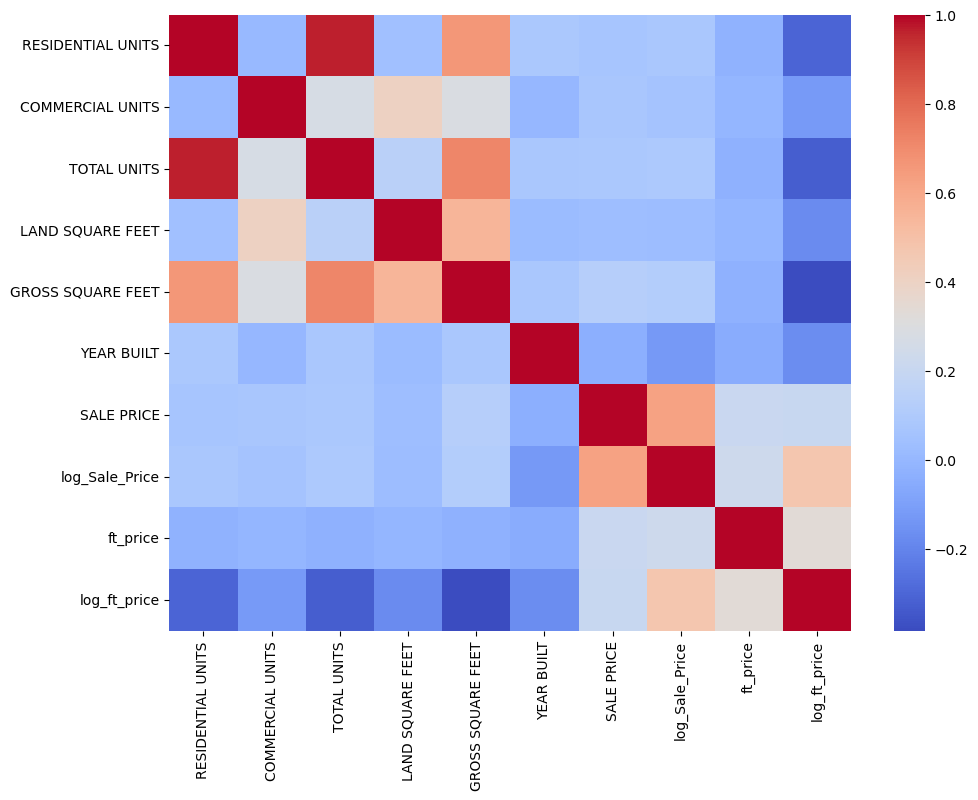

CPU times: total: 328 ms
Wall time: 329 ms


In [56]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="coolwarm",annot=False)
plt.show()

# dummy variable generation

In [57]:
%%time
df_dummies = pd.get_dummies(df)
# df_dummies = pd.get_dummies(df['BOROUGH'], prefix=['BOROUGH'])
df_dummies.shape

CPU times: total: 375 ms
Wall time: 374 ms


(178983, 458)

# train_test_split

In [58]:
sampel = 5
n = len(df_dummies) // sampel
sampled_df_dummies = df_dummies.sample(n=n, random_state=123)

In [59]:
%%time
sampled_df_dummies = sampled_df_dummies.replace([np.inf, -np.inf], np.nan)
sampled_df_dummies = sampled_df_dummies.dropna()
sampled_df_dummies = sampled_df_dummies.reset_index()

x = sampled_df_dummies.drop(['SALE PRICE','log_Sale_Price','ft_price','log_ft_price'], axis=1)
y = sampled_df_dummies['log_Sale_Price']
del x['index']
# unstandardized + dummies
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 2022)

CPU times: total: 93.8 ms
Wall time: 100 ms


# standardized numerical variables

In [60]:
%%time
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# standardized numerical + dummies
scale_x = StandardScaler()
x_train_stan = x_train
y_train_stan = y_train
x_test_stan = x_test
y_test_stan = y_test

x_train_num = x_train_stan[['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET','YEAR BUILT']]
x_train_num_scale = scale_x.fit_transform(x_train_num)

x_train_stan[['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET','YEAR BUILT']] = x_train_num_scale

x_test_num = x_test_stan[['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET','YEAR BUILT']]

x_test_num_scale = scale_x.transform(x_test_num)

x_test_stan[['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET','YEAR BUILT']] = x_test_num_scale

scale_y = StandardScaler()
y_train_stan = scale_y.fit_transform(np.array(y_train).reshape(-1,1)).ravel()
y_test_stan = scale_y.transform(np.array(y_test).reshape(-1,1)).ravel()

CPU times: total: 15.6 ms
Wall time: 23.5 ms


安装CPU加速包

In [61]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# model fine tune
Hyperparameter Tuning for selected model

## decision tree

In [46]:
%%time
# decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

# Maximum number of levels in tree
dt_max_depth = [int(x) for x in np.linspace(5, 55, 11)]

# Number of features to consider at every split
dt_max_features = ['auto', 'sqrt', 'log2']

# Minimum number of samples required to split a node
dt_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]

# Criterion to split on
dt_criterion = ['mse','friedman_mse']

# Minimum decrease in impurity required for split to happen
dt_min_impurity_decrease = [0.0, 0.05, 0.1]

# Create the grid
dt_grid = {'max_depth': dt_max_depth,
           'max_features': dt_max_features,
           'criterion': dt_criterion,
           'min_samples_split': dt_min_samples_split,
           'min_impurity_decrease': dt_min_impurity_decrease}

# Create the model to be tuned
dt_base = DecisionTreeRegressor()

# Create the random search Random Forest
dt_random = RandomizedSearchCV(estimator = dt_base,
                               param_distributions = dt_grid, 
                               n_iter = 200,
                               cv = 5, 
                               verbose = 2,
                               random_state = 123, 
                               n_jobs = -1)

# Fit the random search model
dt_random.fit(x_train_stan, y_train_stan)

# View the best parameters from the random search
dt_random.best_params_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: total: 19.5 s
Wall time: 2min 51s


{'min_samples_split': 6,
 'min_impurity_decrease': 0.0,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'friedman_mse'}

## Random Forest Regressor

In [29]:
%%time
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_n_estimators.append(1500)
rf_n_estimators.append(2000)

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Criterion to split on
rf_criterion = ['squared_error','friedman_mse']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.1]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

# Create the model to be tuned
rf_base = RandomForestRegressor()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = rf_grid, 
                               n_iter = 20, 
                               cv = 5, 
                               verbose = 2, 
                               random_state = 123, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(x_train_stan, y_train_stan)

# View the best parameters from the random search
rf_random.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 1min 3s
Wall time: 38min 7s


{'n_estimators': 600,
 'min_samples_split': 4,
 'min_impurity_decrease': 0.0,
 'max_features': 'log2',
 'max_depth': None,
 'criterion': 'friedman_mse',
 'bootstrap': True}

## Extreme Gradient Boosting(XGBoost)

In [14]:
%%time
# XGBoost
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Number of trees to be used
xgb_n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]

# Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]

# Minimum number of instaces needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]

# Tree construction algorithm used in XGBoost
xgb_tree_method = ['auto', 'exact', 'approx', 'hist']

# Learning rate
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

# Minimum loss reduction required to make further partition
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]

# Learning objective used
xgb_objective = ['reg:squarederror']

params = {
    'n_jobs': 1,                 # 指定只使用1个进程
    'tree_method': 'gpu_hist',   # 使用GPU加速运行
    'predictor': 'gpu_predictor' # 使用GPU预测
}

model = xgb.XGBRegressor(**params)

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}


# Create the random search Random Forest
xgb_random = RandomizedSearchCV(estimator = model,
                                param_distributions = xgb_grid, 
                                n_iter = 50,
                                cv = 5, 
                                verbose = 2,
                                n_jobs=-1,
                                random_state = 123)

# Fit the random search model
xgb_random.fit(x_train_stan, y_train_stan)

# Get the optimal parameters
xgb_random.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: total: 24.2 s
Wall time: 2h 1min 49s


{'tree_method': 'hist',
 'objective': 'reg:squarederror',
 'n_estimators': 1800,
 'min_child_weight': 5,
 'max_depth': 2,
 'gamma': 0,
 'eta': 0.1}

## CatBoost

In [25]:
%%time
import catboost
train_dataset = catboost.Pool(x_train_stan, y_train_stan) 
model = catboost.CatBoostRegressor(loss_function='RMSE',random_state=2022)
grid = {'iterations': [400,800,1000,1200],
        'learning_rate': [0.03, 0.1, 0.3],
        'depth': [2, 4, 6, 10],
        'l2_leaf_reg': [0.15,0.2,0.3]}
model.randomized_search(grid, 
                        train_dataset,
                        cv = 5,
                        n_iter = 10,
                        partition_random_seed = 2022,
                        verbose = 2,
                        plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9320561	test: 0.9332032	best: 0.9332032 (0)	total: 54.3ms	remaining: 21.6s
1:	learn: 0.8887261	test: 0.8857301	best: 0.8857301 (1)	total: 55.7ms	remaining: 11.1s
2:	learn: 0.8522051	test: 0.8467257	best: 0.8467257 (2)	total: 57.1ms	remaining: 7.56s
3:	learn: 0.8334305	test: 0.8256990	best: 0.8256990 (3)	total: 58.5ms	remaining: 5.79s
4:	learn: 0.8193922	test: 0.8108411	best: 0.8108411 (4)	total: 59.9ms	remaining: 4.73s
5:	learn: 0.8094821	test: 0.8011121	best: 0.8011121 (5)	total: 61.6ms	remaining: 4.05s
6:	learn: 0.8005365	test: 0.7917624	best: 0.7917624 (6)	total: 69.8ms	remaining: 3.92s
7:	learn: 0.7952206	test: 0.7856274	best: 0.7856274 (7)	total: 77.3ms	remaining: 3.79s
8:	learn: 0.7905228	test: 0.7798602	best: 0.7798602 (8)	total: 80.5ms	remaining: 3.5s
9:	learn: 0.7864569	test: 0.7753192	best: 0.7753192 (9)	total: 85.8ms	remaining: 3.35s
10:	learn: 0.7825433	test: 0.7719978	best: 0.7719978 (10)	total: 90.9ms	remaining: 3.21s
11:	learn: 0.7788196	test: 0.7678200	best:

131:	learn: 0.6775695	test: 0.6854363	best: 0.6854363 (131)	total: 653ms	remaining: 1.32s
132:	learn: 0.6773207	test: 0.6852785	best: 0.6852785 (132)	total: 655ms	remaining: 1.31s
133:	learn: 0.6770640	test: 0.6852086	best: 0.6852086 (133)	total: 656ms	remaining: 1.3s
134:	learn: 0.6767993	test: 0.6850272	best: 0.6850272 (134)	total: 658ms	remaining: 1.29s
135:	learn: 0.6765447	test: 0.6850973	best: 0.6850272 (134)	total: 660ms	remaining: 1.28s
136:	learn: 0.6762968	test: 0.6850836	best: 0.6850272 (134)	total: 663ms	remaining: 1.27s
137:	learn: 0.6760366	test: 0.6846459	best: 0.6846459 (137)	total: 668ms	remaining: 1.27s
138:	learn: 0.6757837	test: 0.6844554	best: 0.6844554 (138)	total: 674ms	remaining: 1.27s
139:	learn: 0.6754811	test: 0.6844856	best: 0.6844554 (138)	total: 682ms	remaining: 1.27s
140:	learn: 0.6752243	test: 0.6843298	best: 0.6843298 (140)	total: 690ms	remaining: 1.27s
141:	learn: 0.6749779	test: 0.6843219	best: 0.6843219 (141)	total: 694ms	remaining: 1.26s
142:	learn:

246:	learn: 0.6489782	test: 0.6738979	best: 0.6737357 (238)	total: 1.25s	remaining: 773ms
247:	learn: 0.6486830	test: 0.6743331	best: 0.6737357 (238)	total: 1.25s	remaining: 766ms
248:	learn: 0.6484569	test: 0.6742947	best: 0.6737357 (238)	total: 1.25s	remaining: 759ms
249:	learn: 0.6482281	test: 0.6742486	best: 0.6737357 (238)	total: 1.25s	remaining: 752ms
250:	learn: 0.6480321	test: 0.6739997	best: 0.6737357 (238)	total: 1.25s	remaining: 744ms
251:	learn: 0.6478983	test: 0.6739999	best: 0.6737357 (238)	total: 1.25s	remaining: 737ms
252:	learn: 0.6475873	test: 0.6738384	best: 0.6737357 (238)	total: 1.26s	remaining: 730ms
253:	learn: 0.6471046	test: 0.6736683	best: 0.6736683 (253)	total: 1.26s	remaining: 725ms
254:	learn: 0.6468069	test: 0.6738415	best: 0.6736683 (253)	total: 1.27s	remaining: 723ms
255:	learn: 0.6466537	test: 0.6736876	best: 0.6736683 (253)	total: 1.28s	remaining: 720ms
256:	learn: 0.6465191	test: 0.6735644	best: 0.6735644 (256)	total: 1.28s	remaining: 715ms
257:	learn

366:	learn: 0.6289556	test: 0.6687957	best: 0.6687824 (365)	total: 1.84s	remaining: 166ms
367:	learn: 0.6288632	test: 0.6688429	best: 0.6687824 (365)	total: 1.85s	remaining: 161ms
368:	learn: 0.6287329	test: 0.6687051	best: 0.6687051 (368)	total: 1.85s	remaining: 155ms
369:	learn: 0.6285064	test: 0.6686674	best: 0.6686674 (369)	total: 1.85s	remaining: 150ms
370:	learn: 0.6283141	test: 0.6684755	best: 0.6684755 (370)	total: 1.85s	remaining: 145ms
371:	learn: 0.6282513	test: 0.6685381	best: 0.6684755 (370)	total: 1.85s	remaining: 139ms
372:	learn: 0.6281246	test: 0.6683735	best: 0.6683735 (372)	total: 1.86s	remaining: 134ms
373:	learn: 0.6280547	test: 0.6683772	best: 0.6683735 (372)	total: 1.86s	remaining: 129ms
374:	learn: 0.6279911	test: 0.6682792	best: 0.6682792 (374)	total: 1.86s	remaining: 124ms
375:	learn: 0.6278702	test: 0.6681838	best: 0.6681838 (375)	total: 1.86s	remaining: 119ms
376:	learn: 0.6277462	test: 0.6681503	best: 0.6681503 (376)	total: 1.87s	remaining: 114ms
377:	learn

98:	learn: 0.6908883	test: 0.6942284	best: 0.6942284 (98)	total: 445ms	remaining: 4.05s
99:	learn: 0.6904194	test: 0.6937038	best: 0.6937038 (99)	total: 447ms	remaining: 4.02s
100:	learn: 0.6900222	test: 0.6934125	best: 0.6934125 (100)	total: 448ms	remaining: 3.99s
101:	learn: 0.6896377	test: 0.6932064	best: 0.6932064 (101)	total: 450ms	remaining: 3.96s
102:	learn: 0.6892330	test: 0.6928125	best: 0.6928125 (102)	total: 451ms	remaining: 3.92s
103:	learn: 0.6888702	test: 0.6922963	best: 0.6922963 (103)	total: 452ms	remaining: 3.9s
104:	learn: 0.6885152	test: 0.6920168	best: 0.6920168 (104)	total: 454ms	remaining: 3.87s
105:	learn: 0.6879919	test: 0.6919631	best: 0.6919631 (105)	total: 457ms	remaining: 3.85s
106:	learn: 0.6875768	test: 0.6914876	best: 0.6914876 (106)	total: 459ms	remaining: 3.83s
107:	learn: 0.6872120	test: 0.6913927	best: 0.6913927 (107)	total: 472ms	remaining: 3.9s
108:	learn: 0.6868246	test: 0.6911733	best: 0.6911733 (108)	total: 476ms	remaining: 3.89s
109:	learn: 0.68

214:	learn: 0.6547662	test: 0.6772268	best: 0.6771484 (213)	total: 1.04s	remaining: 3.8s
215:	learn: 0.6546052	test: 0.6772814	best: 0.6771484 (213)	total: 1.04s	remaining: 3.78s
216:	learn: 0.6544097	test: 0.6768071	best: 0.6768071 (216)	total: 1.04s	remaining: 3.76s
217:	learn: 0.6542627	test: 0.6766367	best: 0.6766367 (217)	total: 1.04s	remaining: 3.74s
218:	learn: 0.6541207	test: 0.6765144	best: 0.6765144 (218)	total: 1.04s	remaining: 3.73s
219:	learn: 0.6539425	test: 0.6764916	best: 0.6764916 (219)	total: 1.05s	remaining: 3.71s
220:	learn: 0.6537905	test: 0.6764505	best: 0.6764505 (220)	total: 1.05s	remaining: 3.69s
221:	learn: 0.6535623	test: 0.6764233	best: 0.6764233 (221)	total: 1.05s	remaining: 3.68s
222:	learn: 0.6534125	test: 0.6763231	best: 0.6763231 (222)	total: 1.05s	remaining: 3.67s
223:	learn: 0.6532543	test: 0.6762855	best: 0.6762855 (223)	total: 1.06s	remaining: 3.67s
224:	learn: 0.6531197	test: 0.6762522	best: 0.6762522 (224)	total: 1.07s	remaining: 3.68s
225:	learn:

335:	learn: 0.6339828	test: 0.6706700	best: 0.6702586 (323)	total: 1.64s	remaining: 3.24s
336:	learn: 0.6337586	test: 0.6699502	best: 0.6699502 (336)	total: 1.64s	remaining: 3.23s
337:	learn: 0.6336215	test: 0.6698638	best: 0.6698638 (337)	total: 1.64s	remaining: 3.21s
338:	learn: 0.6334929	test: 0.6699284	best: 0.6698638 (337)	total: 1.64s	remaining: 3.2s
339:	learn: 0.6333606	test: 0.6699129	best: 0.6698638 (337)	total: 1.64s	remaining: 3.19s
340:	learn: 0.6331792	test: 0.6696786	best: 0.6696786 (340)	total: 1.65s	remaining: 3.18s
341:	learn: 0.6330680	test: 0.6696967	best: 0.6696786 (340)	total: 1.65s	remaining: 3.18s
342:	learn: 0.6329412	test: 0.6696341	best: 0.6696341 (342)	total: 1.65s	remaining: 3.17s
343:	learn: 0.6328421	test: 0.6696630	best: 0.6696341 (342)	total: 1.66s	remaining: 3.16s
344:	learn: 0.6323806	test: 0.6694785	best: 0.6694785 (344)	total: 1.67s	remaining: 3.16s
345:	learn: 0.6321945	test: 0.6694556	best: 0.6694556 (345)	total: 1.67s	remaining: 3.16s
346:	learn:

479:	learn: 0.6165753	test: 0.6686593	best: 0.6676810 (399)	total: 2.23s	remaining: 2.42s
480:	learn: 0.6164817	test: 0.6685508	best: 0.6676810 (399)	total: 2.23s	remaining: 2.41s
481:	learn: 0.6164362	test: 0.6685712	best: 0.6676810 (399)	total: 2.23s	remaining: 2.4s
482:	learn: 0.6163864	test: 0.6685416	best: 0.6676810 (399)	total: 2.23s	remaining: 2.39s
483:	learn: 0.6162958	test: 0.6684775	best: 0.6676810 (399)	total: 2.24s	remaining: 2.38s
484:	learn: 0.6161601	test: 0.6683566	best: 0.6676810 (399)	total: 2.24s	remaining: 2.38s
485:	learn: 0.6160231	test: 0.6684016	best: 0.6676810 (399)	total: 2.24s	remaining: 2.37s
486:	learn: 0.6159368	test: 0.6684879	best: 0.6676810 (399)	total: 2.24s	remaining: 2.36s
487:	learn: 0.6158518	test: 0.6686220	best: 0.6676810 (399)	total: 2.25s	remaining: 2.36s
488:	learn: 0.6157790	test: 0.6687118	best: 0.6676810 (399)	total: 2.25s	remaining: 2.35s
489:	learn: 0.6157369	test: 0.6686492	best: 0.6676810 (399)	total: 2.25s	remaining: 2.34s
490:	learn:

576:	learn: 0.6066891	test: 0.6682880	best: 0.6676810 (399)	total: 2.63s	remaining: 1.93s
577:	learn: 0.6066481	test: 0.6682778	best: 0.6676810 (399)	total: 2.63s	remaining: 1.92s
578:	learn: 0.6065688	test: 0.6682696	best: 0.6676810 (399)	total: 2.63s	remaining: 1.91s
579:	learn: 0.6065256	test: 0.6682337	best: 0.6676810 (399)	total: 2.63s	remaining: 1.91s
580:	learn: 0.6063229	test: 0.6684374	best: 0.6676810 (399)	total: 2.63s	remaining: 1.9s
581:	learn: 0.6062314	test: 0.6685714	best: 0.6676810 (399)	total: 2.64s	remaining: 1.89s
582:	learn: 0.6061648	test: 0.6685591	best: 0.6676810 (399)	total: 2.64s	remaining: 1.89s
583:	learn: 0.6060200	test: 0.6685269	best: 0.6676810 (399)	total: 2.64s	remaining: 1.88s
584:	learn: 0.6059514	test: 0.6684916	best: 0.6676810 (399)	total: 2.65s	remaining: 1.88s
585:	learn: 0.6059107	test: 0.6684498	best: 0.6676810 (399)	total: 2.65s	remaining: 1.87s
586:	learn: 0.6058168	test: 0.6685809	best: 0.6676810 (399)	total: 2.65s	remaining: 1.86s
587:	learn:

710:	learn: 0.5969926	test: 0.6691086	best: 0.6676810 (399)	total: 3.22s	remaining: 1.31s
711:	learn: 0.5969346	test: 0.6690946	best: 0.6676810 (399)	total: 3.22s	remaining: 1.3s
712:	learn: 0.5968618	test: 0.6690330	best: 0.6676810 (399)	total: 3.22s	remaining: 1.3s
713:	learn: 0.5968186	test: 0.6690564	best: 0.6676810 (399)	total: 3.22s	remaining: 1.29s
714:	learn: 0.5967689	test: 0.6690725	best: 0.6676810 (399)	total: 3.22s	remaining: 1.28s
715:	learn: 0.5967077	test: 0.6690743	best: 0.6676810 (399)	total: 3.23s	remaining: 1.28s
716:	learn: 0.5966739	test: 0.6690777	best: 0.6676810 (399)	total: 3.24s	remaining: 1.28s
717:	learn: 0.5965538	test: 0.6693634	best: 0.6676810 (399)	total: 3.24s	remaining: 1.27s
718:	learn: 0.5965171	test: 0.6693337	best: 0.6676810 (399)	total: 3.25s	remaining: 1.27s
719:	learn: 0.5964083	test: 0.6692101	best: 0.6676810 (399)	total: 3.25s	remaining: 1.26s
720:	learn: 0.5963509	test: 0.6695518	best: 0.6676810 (399)	total: 3.26s	remaining: 1.26s
721:	learn: 

848:	learn: 0.5894072	test: 0.6707075	best: 0.6676810 (399)	total: 3.81s	remaining: 678ms
849:	learn: 0.5893851	test: 0.6709120	best: 0.6676810 (399)	total: 3.81s	remaining: 673ms
850:	learn: 0.5893707	test: 0.6709057	best: 0.6676810 (399)	total: 3.81s	remaining: 668ms
851:	learn: 0.5893512	test: 0.6708543	best: 0.6676810 (399)	total: 3.81s	remaining: 663ms
852:	learn: 0.5892399	test: 0.6708052	best: 0.6676810 (399)	total: 3.82s	remaining: 658ms
853:	learn: 0.5891974	test: 0.6708256	best: 0.6676810 (399)	total: 3.82s	remaining: 653ms
854:	learn: 0.5891655	test: 0.6708291	best: 0.6676810 (399)	total: 3.82s	remaining: 648ms
855:	learn: 0.5891473	test: 0.6708245	best: 0.6676810 (399)	total: 3.82s	remaining: 643ms
856:	learn: 0.5891292	test: 0.6708175	best: 0.6676810 (399)	total: 3.82s	remaining: 638ms
857:	learn: 0.5891003	test: 0.6707921	best: 0.6676810 (399)	total: 3.83s	remaining: 634ms
858:	learn: 0.5890683	test: 0.6708307	best: 0.6676810 (399)	total: 3.83s	remaining: 629ms
859:	learn

970:	learn: 0.5826660	test: 0.6721312	best: 0.6676810 (399)	total: 4.4s	remaining: 131ms
971:	learn: 0.5826509	test: 0.6721159	best: 0.6676810 (399)	total: 4.4s	remaining: 127ms
972:	learn: 0.5826364	test: 0.6722808	best: 0.6676810 (399)	total: 4.41s	remaining: 122ms
973:	learn: 0.5826214	test: 0.6722414	best: 0.6676810 (399)	total: 4.41s	remaining: 118ms
974:	learn: 0.5825955	test: 0.6722637	best: 0.6676810 (399)	total: 4.41s	remaining: 113ms
975:	learn: 0.5825568	test: 0.6722667	best: 0.6676810 (399)	total: 4.41s	remaining: 108ms
976:	learn: 0.5825395	test: 0.6722825	best: 0.6676810 (399)	total: 4.42s	remaining: 104ms
977:	learn: 0.5824668	test: 0.6730141	best: 0.6676810 (399)	total: 4.42s	remaining: 99.5ms
978:	learn: 0.5823892	test: 0.6730044	best: 0.6676810 (399)	total: 4.43s	remaining: 95ms
979:	learn: 0.5823610	test: 0.6732190	best: 0.6676810 (399)	total: 4.43s	remaining: 90.5ms
980:	learn: 0.5822672	test: 0.6732166	best: 0.6676810 (399)	total: 4.44s	remaining: 86ms
981:	learn: 

68:	learn: 0.7801080	test: 0.7737093	best: 0.7737093 (68)	total: 472ms	remaining: 2.26s
69:	learn: 0.7792964	test: 0.7728846	best: 0.7728846 (69)	total: 481ms	remaining: 2.27s
70:	learn: 0.7786427	test: 0.7722803	best: 0.7722803 (70)	total: 492ms	remaining: 2.28s
71:	learn: 0.7779577	test: 0.7714885	best: 0.7714885 (71)	total: 504ms	remaining: 2.29s
72:	learn: 0.7771551	test: 0.7705401	best: 0.7705401 (72)	total: 513ms	remaining: 2.3s
73:	learn: 0.7764342	test: 0.7698397	best: 0.7698397 (73)	total: 523ms	remaining: 2.3s
74:	learn: 0.7756725	test: 0.7690721	best: 0.7690721 (74)	total: 533ms	remaining: 2.31s
75:	learn: 0.7749217	test: 0.7681629	best: 0.7681629 (75)	total: 542ms	remaining: 2.31s
76:	learn: 0.7742426	test: 0.7673555	best: 0.7673555 (76)	total: 551ms	remaining: 2.31s
77:	learn: 0.7735592	test: 0.7666893	best: 0.7666893 (77)	total: 558ms	remaining: 2.3s
78:	learn: 0.7729538	test: 0.7660153	best: 0.7660153 (78)	total: 567ms	remaining: 2.31s
79:	learn: 0.7722925	test: 0.765182

189:	learn: 0.7320761	test: 0.7276797	best: 0.7276797 (189)	total: 1.49s	remaining: 1.65s
190:	learn: 0.7318067	test: 0.7274774	best: 0.7274774 (190)	total: 1.5s	remaining: 1.64s
191:	learn: 0.7316198	test: 0.7271911	best: 0.7271911 (191)	total: 1.51s	remaining: 1.63s
192:	learn: 0.7314414	test: 0.7270430	best: 0.7270430 (192)	total: 1.52s	remaining: 1.63s
193:	learn: 0.7312499	test: 0.7269351	best: 0.7269351 (193)	total: 1.53s	remaining: 1.62s
194:	learn: 0.7309489	test: 0.7268542	best: 0.7268542 (194)	total: 1.53s	remaining: 1.61s
195:	learn: 0.7307182	test: 0.7267098	best: 0.7267098 (195)	total: 1.54s	remaining: 1.61s
196:	learn: 0.7304919	test: 0.7265376	best: 0.7265376 (196)	total: 1.55s	remaining: 1.6s
197:	learn: 0.7302326	test: 0.7262617	best: 0.7262617 (197)	total: 1.56s	remaining: 1.59s
198:	learn: 0.7300357	test: 0.7260595	best: 0.7260595 (198)	total: 1.57s	remaining: 1.59s
199:	learn: 0.7298414	test: 0.7259357	best: 0.7259357 (199)	total: 1.58s	remaining: 1.58s
200:	learn: 

284:	learn: 0.7145345	test: 0.7134131	best: 0.7134131 (284)	total: 2.29s	remaining: 925ms
285:	learn: 0.7143773	test: 0.7133192	best: 0.7133192 (285)	total: 2.29s	remaining: 914ms
286:	learn: 0.7142454	test: 0.7131975	best: 0.7131975 (286)	total: 2.3s	remaining: 904ms
287:	learn: 0.7141239	test: 0.7130999	best: 0.7130999 (287)	total: 2.3s	remaining: 894ms
288:	learn: 0.7139392	test: 0.7128535	best: 0.7128535 (288)	total: 2.3s	remaining: 884ms
289:	learn: 0.7137556	test: 0.7127823	best: 0.7127823 (289)	total: 2.3s	remaining: 874ms
290:	learn: 0.7135914	test: 0.7127276	best: 0.7127276 (290)	total: 2.31s	remaining: 864ms
291:	learn: 0.7134154	test: 0.7126119	best: 0.7126119 (291)	total: 2.31s	remaining: 854ms
292:	learn: 0.7132607	test: 0.7124260	best: 0.7124260 (292)	total: 2.31s	remaining: 845ms
293:	learn: 0.7130140	test: 0.7121958	best: 0.7121958 (293)	total: 2.32s	remaining: 837ms
294:	learn: 0.7128846	test: 0.7120547	best: 0.7120547 (294)	total: 2.33s	remaining: 829ms
295:	learn: 0.

387:	learn: 0.6996224	test: 0.7016468	best: 0.7016468 (387)	total: 2.89s	remaining: 89.5ms
388:	learn: 0.6995055	test: 0.7015698	best: 0.7015698 (388)	total: 2.9s	remaining: 81.9ms
389:	learn: 0.6993984	test: 0.7014236	best: 0.7014236 (389)	total: 2.9s	remaining: 74.4ms
390:	learn: 0.6992854	test: 0.7013185	best: 0.7013185 (390)	total: 2.9s	remaining: 66.8ms
391:	learn: 0.6991622	test: 0.7012502	best: 0.7012502 (391)	total: 2.91s	remaining: 59.3ms
392:	learn: 0.6990477	test: 0.7011692	best: 0.7011692 (392)	total: 2.91s	remaining: 51.8ms
393:	learn: 0.6989056	test: 0.7011334	best: 0.7011334 (393)	total: 2.91s	remaining: 44.3ms
394:	learn: 0.6987895	test: 0.7010656	best: 0.7010656 (394)	total: 2.91s	remaining: 36.9ms
395:	learn: 0.6986692	test: 0.7009685	best: 0.7009685 (395)	total: 2.92s	remaining: 29.5ms
396:	learn: 0.6985677	test: 0.7008909	best: 0.7008909 (396)	total: 2.92s	remaining: 22.1ms
397:	learn: 0.6984573	test: 0.7007851	best: 0.7007851 (397)	total: 2.94s	remaining: 14.8ms
39

92:	learn: 0.7105728	test: 0.7096214	best: 0.7096214 (92)	total: 549ms	remaining: 5.35s
93:	learn: 0.7102039	test: 0.7092069	best: 0.7092069 (93)	total: 551ms	remaining: 5.31s
94:	learn: 0.7097771	test: 0.7089190	best: 0.7089190 (94)	total: 554ms	remaining: 5.28s
95:	learn: 0.7093010	test: 0.7087832	best: 0.7087832 (95)	total: 556ms	remaining: 5.23s
96:	learn: 0.7088323	test: 0.7082015	best: 0.7082015 (96)	total: 558ms	remaining: 5.2s
97:	learn: 0.7083948	test: 0.7078702	best: 0.7078702 (97)	total: 560ms	remaining: 5.16s
98:	learn: 0.7077312	test: 0.7074263	best: 0.7074263 (98)	total: 562ms	remaining: 5.12s
99:	learn: 0.7073652	test: 0.7073473	best: 0.7073473 (99)	total: 564ms	remaining: 5.08s
100:	learn: 0.7068102	test: 0.7071058	best: 0.7071058 (100)	total: 566ms	remaining: 5.04s
101:	learn: 0.7064053	test: 0.7062814	best: 0.7062814 (101)	total: 568ms	remaining: 5s
102:	learn: 0.7058739	test: 0.7056827	best: 0.7056827 (102)	total: 571ms	remaining: 4.97s
103:	learn: 0.7055561	test: 0.

198:	learn: 0.6710166	test: 0.6829953	best: 0.6829953 (198)	total: 1.15s	remaining: 4.62s
199:	learn: 0.6704912	test: 0.6831201	best: 0.6829953 (198)	total: 1.15s	remaining: 4.6s
200:	learn: 0.6702703	test: 0.6829859	best: 0.6829859 (200)	total: 1.15s	remaining: 4.58s
201:	learn: 0.6699008	test: 0.6826990	best: 0.6826990 (201)	total: 1.16s	remaining: 4.57s
202:	learn: 0.6695956	test: 0.6826513	best: 0.6826513 (202)	total: 1.16s	remaining: 4.54s
203:	learn: 0.6692780	test: 0.6823991	best: 0.6823991 (203)	total: 1.16s	remaining: 4.53s
204:	learn: 0.6687440	test: 0.6824278	best: 0.6823991 (203)	total: 1.17s	remaining: 4.53s
205:	learn: 0.6683651	test: 0.6823917	best: 0.6823917 (205)	total: 1.18s	remaining: 4.53s
206:	learn: 0.6681374	test: 0.6824142	best: 0.6823917 (205)	total: 1.18s	remaining: 4.53s
207:	learn: 0.6676568	test: 0.6823115	best: 0.6823115 (207)	total: 1.19s	remaining: 4.53s
208:	learn: 0.6674089	test: 0.6820738	best: 0.6820738 (208)	total: 1.2s	remaining: 4.53s
209:	learn: 

310:	learn: 0.6432990	test: 0.6718501	best: 0.6718501 (310)	total: 1.75s	remaining: 3.88s
311:	learn: 0.6430861	test: 0.6718319	best: 0.6718319 (311)	total: 1.75s	remaining: 3.87s
312:	learn: 0.6427363	test: 0.6718214	best: 0.6718214 (312)	total: 1.76s	remaining: 3.85s
313:	learn: 0.6425345	test: 0.6716667	best: 0.6716667 (313)	total: 1.76s	remaining: 3.84s
314:	learn: 0.6422772	test: 0.6715188	best: 0.6715188 (314)	total: 1.76s	remaining: 3.83s
315:	learn: 0.6420978	test: 0.6714282	best: 0.6714282 (315)	total: 1.76s	remaining: 3.82s
316:	learn: 0.6419053	test: 0.6713886	best: 0.6713886 (316)	total: 1.77s	remaining: 3.81s
317:	learn: 0.6417128	test: 0.6713590	best: 0.6713590 (317)	total: 1.77s	remaining: 3.8s
318:	learn: 0.6412710	test: 0.6713046	best: 0.6713046 (318)	total: 1.78s	remaining: 3.79s
319:	learn: 0.6411492	test: 0.6712492	best: 0.6712492 (319)	total: 1.78s	remaining: 3.79s
320:	learn: 0.6409521	test: 0.6711689	best: 0.6711689 (320)	total: 1.79s	remaining: 3.79s
321:	learn:

410:	learn: 0.6236984	test: 0.6683994	best: 0.6683480 (409)	total: 2.36s	remaining: 3.38s
411:	learn: 0.6235478	test: 0.6683710	best: 0.6683480 (409)	total: 2.36s	remaining: 3.37s
412:	learn: 0.6234507	test: 0.6683256	best: 0.6683256 (412)	total: 2.36s	remaining: 3.36s
413:	learn: 0.6233378	test: 0.6683288	best: 0.6683256 (412)	total: 2.37s	remaining: 3.35s
414:	learn: 0.6229494	test: 0.6683661	best: 0.6683256 (412)	total: 2.37s	remaining: 3.34s
415:	learn: 0.6227734	test: 0.6680951	best: 0.6680951 (415)	total: 2.37s	remaining: 3.33s
416:	learn: 0.6224762	test: 0.6680876	best: 0.6680876 (416)	total: 2.37s	remaining: 3.32s
417:	learn: 0.6223749	test: 0.6680320	best: 0.6680320 (417)	total: 2.38s	remaining: 3.31s
418:	learn: 0.6221199	test: 0.6680745	best: 0.6680320 (417)	total: 2.38s	remaining: 3.3s
419:	learn: 0.6219390	test: 0.6682223	best: 0.6680320 (417)	total: 2.39s	remaining: 3.3s
420:	learn: 0.6218242	test: 0.6681348	best: 0.6680320 (417)	total: 2.4s	remaining: 3.29s
421:	learn: 0

513:	learn: 0.6068645	test: 0.6657024	best: 0.6655714 (502)	total: 2.97s	remaining: 2.81s
514:	learn: 0.6067821	test: 0.6656892	best: 0.6655714 (502)	total: 2.97s	remaining: 2.8s
515:	learn: 0.6066396	test: 0.6656106	best: 0.6655714 (502)	total: 2.97s	remaining: 2.79s
516:	learn: 0.6065229	test: 0.6655128	best: 0.6655128 (516)	total: 2.98s	remaining: 2.78s
517:	learn: 0.6063889	test: 0.6656294	best: 0.6655128 (516)	total: 2.98s	remaining: 2.77s
518:	learn: 0.6062852	test: 0.6656267	best: 0.6655128 (516)	total: 2.99s	remaining: 2.77s
519:	learn: 0.6060914	test: 0.6656536	best: 0.6655128 (516)	total: 2.99s	remaining: 2.76s
520:	learn: 0.6059614	test: 0.6655659	best: 0.6655128 (516)	total: 3s	remaining: 2.76s
521:	learn: 0.6057363	test: 0.6654377	best: 0.6654377 (521)	total: 3s	remaining: 2.75s
522:	learn: 0.6056215	test: 0.6654003	best: 0.6654003 (522)	total: 3.01s	remaining: 2.75s
523:	learn: 0.6054581	test: 0.6652756	best: 0.6652756 (523)	total: 3.02s	remaining: 2.74s
524:	learn: 0.605

611:	learn: 0.5933887	test: 0.6644740	best: 0.6644580 (610)	total: 3.57s	remaining: 2.27s
612:	learn: 0.5932937	test: 0.6645064	best: 0.6644580 (610)	total: 3.58s	remaining: 2.26s
613:	learn: 0.5931897	test: 0.6645360	best: 0.6644580 (610)	total: 3.58s	remaining: 2.25s
614:	learn: 0.5931092	test: 0.6645294	best: 0.6644580 (610)	total: 3.58s	remaining: 2.24s
615:	learn: 0.5929723	test: 0.6645089	best: 0.6644580 (610)	total: 3.58s	remaining: 2.23s
616:	learn: 0.5928577	test: 0.6644032	best: 0.6644032 (616)	total: 3.59s	remaining: 2.23s
617:	learn: 0.5927736	test: 0.6643807	best: 0.6643807 (617)	total: 3.59s	remaining: 2.22s
618:	learn: 0.5926877	test: 0.6643855	best: 0.6643807 (617)	total: 3.6s	remaining: 2.22s
619:	learn: 0.5926273	test: 0.6643710	best: 0.6643710 (619)	total: 3.61s	remaining: 2.21s
620:	learn: 0.5924778	test: 0.6643990	best: 0.6643710 (619)	total: 3.61s	remaining: 2.21s
621:	learn: 0.5922690	test: 0.6642652	best: 0.6642652 (621)	total: 3.62s	remaining: 2.2s
622:	learn: 

710:	learn: 0.5814432	test: 0.6646710	best: 0.6639101 (641)	total: 4.17s	remaining: 1.7s
711:	learn: 0.5813694	test: 0.6646921	best: 0.6639101 (641)	total: 4.18s	remaining: 1.69s
712:	learn: 0.5812150	test: 0.6646560	best: 0.6639101 (641)	total: 4.18s	remaining: 1.68s
713:	learn: 0.5810566	test: 0.6647816	best: 0.6639101 (641)	total: 4.18s	remaining: 1.68s
714:	learn: 0.5809404	test: 0.6646662	best: 0.6639101 (641)	total: 4.18s	remaining: 1.67s
715:	learn: 0.5808549	test: 0.6647199	best: 0.6639101 (641)	total: 4.19s	remaining: 1.66s
716:	learn: 0.5807310	test: 0.6650709	best: 0.6639101 (641)	total: 4.2s	remaining: 1.66s
717:	learn: 0.5806416	test: 0.6651190	best: 0.6639101 (641)	total: 4.21s	remaining: 1.65s
718:	learn: 0.5805700	test: 0.6651005	best: 0.6639101 (641)	total: 4.21s	remaining: 1.65s
719:	learn: 0.5804875	test: 0.6651400	best: 0.6639101 (641)	total: 4.22s	remaining: 1.64s
720:	learn: 0.5803290	test: 0.6650937	best: 0.6639101 (641)	total: 4.23s	remaining: 1.64s
721:	learn: 

825:	learn: 0.5694171	test: 0.6665153	best: 0.6639101 (641)	total: 4.77s	remaining: 1s
826:	learn: 0.5693174	test: 0.6665115	best: 0.6639101 (641)	total: 4.77s	remaining: 999ms
827:	learn: 0.5692622	test: 0.6664693	best: 0.6639101 (641)	total: 4.78s	remaining: 992ms
828:	learn: 0.5691176	test: 0.6664527	best: 0.6639101 (641)	total: 4.78s	remaining: 986ms
829:	learn: 0.5689893	test: 0.6664149	best: 0.6639101 (641)	total: 4.78s	remaining: 979ms
830:	learn: 0.5689400	test: 0.6664124	best: 0.6639101 (641)	total: 4.79s	remaining: 974ms
831:	learn: 0.5688283	test: 0.6664899	best: 0.6639101 (641)	total: 4.79s	remaining: 968ms
832:	learn: 0.5687800	test: 0.6664914	best: 0.6639101 (641)	total: 4.8s	remaining: 963ms
833:	learn: 0.5686660	test: 0.6663675	best: 0.6639101 (641)	total: 4.81s	remaining: 958ms
834:	learn: 0.5685321	test: 0.6663510	best: 0.6639101 (641)	total: 4.82s	remaining: 952ms
835:	learn: 0.5684394	test: 0.6663125	best: 0.6639101 (641)	total: 4.83s	remaining: 947ms
836:	learn: 0.

931:	learn: 0.5600618	test: 0.6658418	best: 0.6639101 (641)	total: 5.38s	remaining: 393ms
932:	learn: 0.5599876	test: 0.6657849	best: 0.6639101 (641)	total: 5.39s	remaining: 387ms
933:	learn: 0.5598861	test: 0.6657850	best: 0.6639101 (641)	total: 5.39s	remaining: 381ms
934:	learn: 0.5598449	test: 0.6657850	best: 0.6639101 (641)	total: 5.39s	remaining: 375ms
935:	learn: 0.5597675	test: 0.6658232	best: 0.6639101 (641)	total: 5.39s	remaining: 369ms
936:	learn: 0.5596873	test: 0.6657668	best: 0.6639101 (641)	total: 5.4s	remaining: 363ms
937:	learn: 0.5595568	test: 0.6657702	best: 0.6639101 (641)	total: 5.4s	remaining: 357ms
938:	learn: 0.5594930	test: 0.6657367	best: 0.6639101 (641)	total: 5.4s	remaining: 351ms
939:	learn: 0.5594358	test: 0.6657329	best: 0.6639101 (641)	total: 5.4s	remaining: 345ms
940:	learn: 0.5593870	test: 0.6657352	best: 0.6639101 (641)	total: 5.41s	remaining: 339ms
941:	learn: 0.5593120	test: 0.6657283	best: 0.6639101 (641)	total: 5.41s	remaining: 333ms
942:	learn: 0.

26:	learn: 0.6530089	test: 0.6944493	best: 0.6944493 (26)	total: 683ms	remaining: 9.43s
27:	learn: 0.6513700	test: 0.6927485	best: 0.6927485 (27)	total: 704ms	remaining: 9.36s
28:	learn: 0.6496049	test: 0.6917897	best: 0.6917897 (28)	total: 726ms	remaining: 9.29s
29:	learn: 0.6474878	test: 0.6919217	best: 0.6917897 (28)	total: 745ms	remaining: 9.19s
30:	learn: 0.6451783	test: 0.6908177	best: 0.6908177 (30)	total: 769ms	remaining: 9.15s
31:	learn: 0.6432444	test: 0.6904882	best: 0.6904882 (31)	total: 792ms	remaining: 9.11s
32:	learn: 0.6400935	test: 0.6893285	best: 0.6893285 (32)	total: 817ms	remaining: 9.09s
33:	learn: 0.6372797	test: 0.6884830	best: 0.6884830 (33)	total: 839ms	remaining: 9.03s
34:	learn: 0.6349794	test: 0.6882324	best: 0.6882324 (34)	total: 866ms	remaining: 9.03s
35:	learn: 0.6331192	test: 0.6873924	best: 0.6873924 (35)	total: 887ms	remaining: 8.96s
36:	learn: 0.6303111	test: 0.6862622	best: 0.6862622 (36)	total: 909ms	remaining: 8.92s
37:	learn: 0.6277093	test: 0.685

124:	learn: 0.4871001	test: 0.6840576	best: 0.6799929 (67)	total: 3.05s	remaining: 6.7s
125:	learn: 0.4859642	test: 0.6840014	best: 0.6799929 (67)	total: 3.07s	remaining: 6.67s
126:	learn: 0.4845518	test: 0.6843978	best: 0.6799929 (67)	total: 3.09s	remaining: 6.64s
127:	learn: 0.4834584	test: 0.6849237	best: 0.6799929 (67)	total: 3.11s	remaining: 6.61s
128:	learn: 0.4828491	test: 0.6852396	best: 0.6799929 (67)	total: 3.13s	remaining: 6.59s
129:	learn: 0.4816289	test: 0.6849343	best: 0.6799929 (67)	total: 3.15s	remaining: 6.55s
130:	learn: 0.4807248	test: 0.6847318	best: 0.6799929 (67)	total: 3.17s	remaining: 6.52s
131:	learn: 0.4793173	test: 0.6831020	best: 0.6799929 (67)	total: 3.19s	remaining: 6.48s
132:	learn: 0.4777281	test: 0.6831740	best: 0.6799929 (67)	total: 3.22s	remaining: 6.46s
133:	learn: 0.4764745	test: 0.6832928	best: 0.6799929 (67)	total: 3.24s	remaining: 6.43s
134:	learn: 0.4757664	test: 0.6834743	best: 0.6799929 (67)	total: 3.27s	remaining: 6.41s
135:	learn: 0.4750874	

222:	learn: 0.4025782	test: 0.6881166	best: 0.6799929 (67)	total: 5.41s	remaining: 4.29s
223:	learn: 0.4021432	test: 0.6882746	best: 0.6799929 (67)	total: 5.43s	remaining: 4.27s
224:	learn: 0.4016068	test: 0.6883764	best: 0.6799929 (67)	total: 5.46s	remaining: 4.25s
225:	learn: 0.4007774	test: 0.6882761	best: 0.6799929 (67)	total: 5.49s	remaining: 4.22s
226:	learn: 0.3998552	test: 0.6886727	best: 0.6799929 (67)	total: 5.51s	remaining: 4.2s
227:	learn: 0.3994620	test: 0.6885624	best: 0.6799929 (67)	total: 5.53s	remaining: 4.17s
228:	learn: 0.3991489	test: 0.6886685	best: 0.6799929 (67)	total: 5.55s	remaining: 4.14s
229:	learn: 0.3987222	test: 0.6885589	best: 0.6799929 (67)	total: 5.57s	remaining: 4.12s
230:	learn: 0.3983436	test: 0.6886031	best: 0.6799929 (67)	total: 5.6s	remaining: 4.09s
231:	learn: 0.3976468	test: 0.6884601	best: 0.6799929 (67)	total: 5.62s	remaining: 4.07s
232:	learn: 0.3972998	test: 0.6884903	best: 0.6799929 (67)	total: 5.64s	remaining: 4.04s
233:	learn: 0.3966966	t

321:	learn: 0.3495440	test: 0.6951927	best: 0.6799929 (67)	total: 7.77s	remaining: 1.88s
322:	learn: 0.3491646	test: 0.6951713	best: 0.6799929 (67)	total: 7.8s	remaining: 1.86s
323:	learn: 0.3487039	test: 0.6952104	best: 0.6799929 (67)	total: 7.82s	remaining: 1.83s
324:	learn: 0.3482846	test: 0.6954375	best: 0.6799929 (67)	total: 7.84s	remaining: 1.81s
325:	learn: 0.3479536	test: 0.6956034	best: 0.6799929 (67)	total: 7.87s	remaining: 1.78s
326:	learn: 0.3475224	test: 0.6956007	best: 0.6799929 (67)	total: 7.89s	remaining: 1.76s
327:	learn: 0.3471237	test: 0.6956069	best: 0.6799929 (67)	total: 7.92s	remaining: 1.74s
328:	learn: 0.3466007	test: 0.6956533	best: 0.6799929 (67)	total: 7.94s	remaining: 1.71s
329:	learn: 0.3461189	test: 0.6954026	best: 0.6799929 (67)	total: 7.96s	remaining: 1.69s
330:	learn: 0.3453979	test: 0.6956028	best: 0.6799929 (67)	total: 7.99s	remaining: 1.67s
331:	learn: 0.3448500	test: 0.6957686	best: 0.6799929 (67)	total: 8.01s	remaining: 1.64s
332:	learn: 0.3444455	

15:	learn: 0.8622891	test: 0.8646570	best: 0.8646570 (15)	total: 399ms	remaining: 19.6s
16:	learn: 0.8563558	test: 0.8587204	best: 0.8587204 (16)	total: 428ms	remaining: 19.7s
17:	learn: 0.8507326	test: 0.8532427	best: 0.8532427 (17)	total: 460ms	remaining: 20s
18:	learn: 0.8458058	test: 0.8486162	best: 0.8486162 (18)	total: 492ms	remaining: 20.2s
19:	learn: 0.8412840	test: 0.8439139	best: 0.8439139 (19)	total: 500ms	remaining: 19.5s
20:	learn: 0.8366334	test: 0.8392132	best: 0.8392132 (20)	total: 523ms	remaining: 19.4s
21:	learn: 0.8322545	test: 0.8348386	best: 0.8348386 (21)	total: 559ms	remaining: 19.8s
22:	learn: 0.8275565	test: 0.8302015	best: 0.8302015 (22)	total: 579ms	remaining: 19.6s
23:	learn: 0.8233709	test: 0.8260320	best: 0.8260320 (23)	total: 602ms	remaining: 19.5s
24:	learn: 0.8192445	test: 0.8215862	best: 0.8215862 (24)	total: 624ms	remaining: 19.3s
25:	learn: 0.8154845	test: 0.8178756	best: 0.8178756 (25)	total: 646ms	remaining: 19.2s
26:	learn: 0.8114035	test: 0.81457

113:	learn: 0.7024779	test: 0.7147022	best: 0.7147022 (113)	total: 2.77s	remaining: 16.7s
114:	learn: 0.7021446	test: 0.7144639	best: 0.7144639 (114)	total: 2.8s	remaining: 16.7s
115:	learn: 0.7018060	test: 0.7141888	best: 0.7141888 (115)	total: 2.82s	remaining: 16.6s
116:	learn: 0.7013280	test: 0.7138096	best: 0.7138096 (116)	total: 2.85s	remaining: 16.6s
117:	learn: 0.7008672	test: 0.7134387	best: 0.7134387 (117)	total: 2.87s	remaining: 16.6s
118:	learn: 0.7004157	test: 0.7130455	best: 0.7130455 (118)	total: 2.89s	remaining: 16.6s
119:	learn: 0.7000579	test: 0.7127821	best: 0.7127821 (119)	total: 2.92s	remaining: 16.6s
120:	learn: 0.6996590	test: 0.7124091	best: 0.7124091 (120)	total: 2.95s	remaining: 16.6s
121:	learn: 0.6992497	test: 0.7122537	best: 0.7122537 (121)	total: 2.97s	remaining: 16.5s
122:	learn: 0.6988038	test: 0.7118143	best: 0.7118143 (122)	total: 2.99s	remaining: 16.5s
123:	learn: 0.6982390	test: 0.7116612	best: 0.7116612 (123)	total: 3.01s	remaining: 16.4s
124:	learn:

211:	learn: 0.6671683	test: 0.6931493	best: 0.6931493 (211)	total: 5.14s	remaining: 14.3s
212:	learn: 0.6669034	test: 0.6929863	best: 0.6929863 (212)	total: 5.17s	remaining: 14.2s
213:	learn: 0.6667020	test: 0.6929469	best: 0.6929469 (213)	total: 5.19s	remaining: 14.2s
214:	learn: 0.6664430	test: 0.6928071	best: 0.6928071 (214)	total: 5.21s	remaining: 14.2s
215:	learn: 0.6660154	test: 0.6927535	best: 0.6927535 (215)	total: 5.24s	remaining: 14.2s
216:	learn: 0.6657495	test: 0.6926844	best: 0.6926844 (216)	total: 5.26s	remaining: 14.1s
217:	learn: 0.6655287	test: 0.6924702	best: 0.6924702 (217)	total: 5.28s	remaining: 14.1s
218:	learn: 0.6652648	test: 0.6922366	best: 0.6922366 (218)	total: 5.31s	remaining: 14.1s
219:	learn: 0.6649707	test: 0.6920965	best: 0.6920965 (219)	total: 5.33s	remaining: 14.1s
220:	learn: 0.6645851	test: 0.6920230	best: 0.6920230 (220)	total: 5.36s	remaining: 14s
221:	learn: 0.6642036	test: 0.6918446	best: 0.6918446 (221)	total: 5.38s	remaining: 14s
222:	learn: 0.

303:	learn: 0.6436450	test: 0.6827538	best: 0.6827538 (303)	total: 7.34s	remaining: 12s
304:	learn: 0.6434379	test: 0.6826567	best: 0.6826567 (304)	total: 7.35s	remaining: 11.9s
305:	learn: 0.6432159	test: 0.6826148	best: 0.6826148 (305)	total: 7.37s	remaining: 11.9s
306:	learn: 0.6430181	test: 0.6825768	best: 0.6825768 (306)	total: 7.39s	remaining: 11.9s
307:	learn: 0.6428327	test: 0.6824169	best: 0.6824169 (307)	total: 7.42s	remaining: 11.9s
308:	learn: 0.6425760	test: 0.6823566	best: 0.6823566 (308)	total: 7.44s	remaining: 11.8s
309:	learn: 0.6422989	test: 0.6823417	best: 0.6823417 (309)	total: 7.47s	remaining: 11.8s
310:	learn: 0.6420911	test: 0.6822082	best: 0.6822082 (310)	total: 7.5s	remaining: 11.8s
311:	learn: 0.6418165	test: 0.6820727	best: 0.6820727 (311)	total: 7.52s	remaining: 11.8s
312:	learn: 0.6415870	test: 0.6820389	best: 0.6820389 (312)	total: 7.54s	remaining: 11.7s
313:	learn: 0.6413077	test: 0.6818908	best: 0.6818908 (313)	total: 7.56s	remaining: 11.7s
314:	learn: 0

400:	learn: 0.6186670	test: 0.6759764	best: 0.6759764 (400)	total: 9.71s	remaining: 9.66s
401:	learn: 0.6184225	test: 0.6759212	best: 0.6759212 (401)	total: 9.73s	remaining: 9.63s
402:	learn: 0.6181526	test: 0.6758424	best: 0.6758424 (402)	total: 9.75s	remaining: 9.61s
403:	learn: 0.6178097	test: 0.6758261	best: 0.6758261 (403)	total: 9.78s	remaining: 9.58s
404:	learn: 0.6176142	test: 0.6757432	best: 0.6757432 (404)	total: 9.8s	remaining: 9.56s
405:	learn: 0.6173155	test: 0.6758365	best: 0.6757432 (404)	total: 9.83s	remaining: 9.54s
406:	learn: 0.6170802	test: 0.6756966	best: 0.6756966 (406)	total: 9.85s	remaining: 9.51s
407:	learn: 0.6168982	test: 0.6756116	best: 0.6756116 (407)	total: 9.88s	remaining: 9.5s
408:	learn: 0.6166743	test: 0.6755548	best: 0.6755548 (408)	total: 9.91s	remaining: 9.48s
409:	learn: 0.6164749	test: 0.6753774	best: 0.6753774 (409)	total: 9.94s	remaining: 9.46s
410:	learn: 0.6162501	test: 0.6752970	best: 0.6752970 (410)	total: 9.97s	remaining: 9.43s
411:	learn: 

492:	learn: 0.5974707	test: 0.6715150	best: 0.6715150 (492)	total: 12s	remaining: 7.47s
493:	learn: 0.5973334	test: 0.6714396	best: 0.6714396 (493)	total: 12s	remaining: 7.44s
494:	learn: 0.5971825	test: 0.6713976	best: 0.6713976 (494)	total: 12s	remaining: 7.42s
495:	learn: 0.5969844	test: 0.6713523	best: 0.6713523 (495)	total: 12.1s	remaining: 7.39s
496:	learn: 0.5966996	test: 0.6713649	best: 0.6713523 (495)	total: 12.1s	remaining: 7.37s
497:	learn: 0.5965123	test: 0.6713121	best: 0.6713121 (497)	total: 12.1s	remaining: 7.35s
498:	learn: 0.5961061	test: 0.6713546	best: 0.6713121 (497)	total: 12.1s	remaining: 7.32s
499:	learn: 0.5959195	test: 0.6713058	best: 0.6713058 (499)	total: 12.2s	remaining: 7.29s
500:	learn: 0.5957375	test: 0.6713000	best: 0.6713000 (500)	total: 12.2s	remaining: 7.27s
501:	learn: 0.5955096	test: 0.6712871	best: 0.6712871 (501)	total: 12.2s	remaining: 7.25s
502:	learn: 0.5952428	test: 0.6713400	best: 0.6712871 (501)	total: 12.2s	remaining: 7.22s
503:	learn: 0.59

589:	learn: 0.5779597	test: 0.6683888	best: 0.6683776 (588)	total: 14.4s	remaining: 5.12s
590:	learn: 0.5777502	test: 0.6683185	best: 0.6683185 (590)	total: 14.4s	remaining: 5.09s
591:	learn: 0.5775842	test: 0.6682900	best: 0.6682900 (591)	total: 14.4s	remaining: 5.06s
592:	learn: 0.5773815	test: 0.6682432	best: 0.6682432 (592)	total: 14.4s	remaining: 5.04s
593:	learn: 0.5772211	test: 0.6682439	best: 0.6682432 (592)	total: 14.5s	remaining: 5.01s
594:	learn: 0.5770765	test: 0.6682581	best: 0.6682432 (592)	total: 14.5s	remaining: 4.99s
595:	learn: 0.5768067	test: 0.6682224	best: 0.6682224 (595)	total: 14.5s	remaining: 4.97s
596:	learn: 0.5766840	test: 0.6681823	best: 0.6681823 (596)	total: 14.5s	remaining: 4.94s
597:	learn: 0.5764818	test: 0.6680949	best: 0.6680949 (597)	total: 14.6s	remaining: 4.92s
598:	learn: 0.5761830	test: 0.6679999	best: 0.6679999 (598)	total: 14.6s	remaining: 4.89s
599:	learn: 0.5760265	test: 0.6679401	best: 0.6679401 (599)	total: 14.6s	remaining: 4.87s
600:	learn

685:	learn: 0.5610056	test: 0.6662197	best: 0.6661879 (682)	total: 16.7s	remaining: 2.77s
686:	learn: 0.5608437	test: 0.6661769	best: 0.6661769 (686)	total: 16.7s	remaining: 2.75s
687:	learn: 0.5606772	test: 0.6662141	best: 0.6661769 (686)	total: 16.7s	remaining: 2.72s
688:	learn: 0.5604988	test: 0.6661970	best: 0.6661769 (686)	total: 16.8s	remaining: 2.7s
689:	learn: 0.5603520	test: 0.6661689	best: 0.6661689 (689)	total: 16.8s	remaining: 2.67s
690:	learn: 0.5602146	test: 0.6661623	best: 0.6661623 (690)	total: 16.8s	remaining: 2.65s
691:	learn: 0.5600515	test: 0.6661736	best: 0.6661623 (690)	total: 16.8s	remaining: 2.63s
692:	learn: 0.5597597	test: 0.6662038	best: 0.6661623 (690)	total: 16.8s	remaining: 2.6s
693:	learn: 0.5595855	test: 0.6661705	best: 0.6661623 (690)	total: 16.9s	remaining: 2.58s
694:	learn: 0.5594924	test: 0.6661783	best: 0.6661623 (690)	total: 16.9s	remaining: 2.55s
695:	learn: 0.5593572	test: 0.6661212	best: 0.6661212 (695)	total: 16.9s	remaining: 2.53s
696:	learn: 

782:	learn: 0.5461613	test: 0.6651379	best: 0.6651379 (782)	total: 19s	remaining: 413ms
783:	learn: 0.5459790	test: 0.6651537	best: 0.6651379 (782)	total: 19.1s	remaining: 389ms
784:	learn: 0.5458754	test: 0.6651164	best: 0.6651164 (784)	total: 19.1s	remaining: 365ms
785:	learn: 0.5456596	test: 0.6651556	best: 0.6651164 (784)	total: 19.1s	remaining: 340ms
786:	learn: 0.5455547	test: 0.6651337	best: 0.6651164 (784)	total: 19.1s	remaining: 316ms
787:	learn: 0.5454547	test: 0.6651220	best: 0.6651164 (784)	total: 19.2s	remaining: 292ms
788:	learn: 0.5453041	test: 0.6651962	best: 0.6651164 (784)	total: 19.2s	remaining: 267ms
789:	learn: 0.5451118	test: 0.6651738	best: 0.6651164 (784)	total: 19.2s	remaining: 243ms
790:	learn: 0.5450036	test: 0.6651922	best: 0.6651164 (784)	total: 19.2s	remaining: 219ms
791:	learn: 0.5448923	test: 0.6651797	best: 0.6651164 (784)	total: 19.2s	remaining: 194ms
792:	learn: 0.5448005	test: 0.6651971	best: 0.6651164 (784)	total: 19.3s	remaining: 170ms
793:	learn: 

77:	learn: 0.5487744	test: 0.6769962	best: 0.6753500 (61)	total: 1.95s	remaining: 18s
78:	learn: 0.5479264	test: 0.6766454	best: 0.6753500 (61)	total: 1.97s	remaining: 18s
79:	learn: 0.5465734	test: 0.6771811	best: 0.6753500 (61)	total: 1.99s	remaining: 18s
80:	learn: 0.5452754	test: 0.6773680	best: 0.6753500 (61)	total: 2.01s	remaining: 17.9s
81:	learn: 0.5441825	test: 0.6774017	best: 0.6753500 (61)	total: 2.04s	remaining: 17.9s
82:	learn: 0.5420849	test: 0.6774333	best: 0.6753500 (61)	total: 2.07s	remaining: 17.9s
83:	learn: 0.5408726	test: 0.6766290	best: 0.6753500 (61)	total: 2.1s	remaining: 17.9s
84:	learn: 0.5399785	test: 0.6763931	best: 0.6753500 (61)	total: 2.12s	remaining: 17.8s
85:	learn: 0.5386842	test: 0.6768175	best: 0.6753500 (61)	total: 2.15s	remaining: 17.8s
86:	learn: 0.5375210	test: 0.6765273	best: 0.6753500 (61)	total: 2.17s	remaining: 17.8s
87:	learn: 0.5364361	test: 0.6765792	best: 0.6753500 (61)	total: 2.19s	remaining: 17.8s
88:	learn: 0.5340536	test: 0.6765735	be

175:	learn: 0.4438442	test: 0.6820642	best: 0.6752291 (99)	total: 4.33s	remaining: 15.4s
176:	learn: 0.4432101	test: 0.6821919	best: 0.6752291 (99)	total: 4.35s	remaining: 15.3s
177:	learn: 0.4424915	test: 0.6822805	best: 0.6752291 (99)	total: 4.38s	remaining: 15.3s
178:	learn: 0.4417071	test: 0.6826053	best: 0.6752291 (99)	total: 4.41s	remaining: 15.3s
179:	learn: 0.4408104	test: 0.6827784	best: 0.6752291 (99)	total: 4.43s	remaining: 15.3s
180:	learn: 0.4402942	test: 0.6826413	best: 0.6752291 (99)	total: 4.46s	remaining: 15.3s
181:	learn: 0.4397544	test: 0.6826713	best: 0.6752291 (99)	total: 4.49s	remaining: 15.3s
182:	learn: 0.4391512	test: 0.6824012	best: 0.6752291 (99)	total: 4.52s	remaining: 15.2s
183:	learn: 0.4376381	test: 0.6828095	best: 0.6752291 (99)	total: 4.54s	remaining: 15.2s
184:	learn: 0.4371470	test: 0.6826449	best: 0.6752291 (99)	total: 4.57s	remaining: 15.2s
185:	learn: 0.4365664	test: 0.6828563	best: 0.6752291 (99)	total: 4.59s	remaining: 15.2s
186:	learn: 0.4358016

269:	learn: 0.3831145	test: 0.6872976	best: 0.6752291 (99)	total: 6.68s	remaining: 13.1s
270:	learn: 0.3829056	test: 0.6871437	best: 0.6752291 (99)	total: 6.71s	remaining: 13.1s
271:	learn: 0.3825287	test: 0.6873026	best: 0.6752291 (99)	total: 6.73s	remaining: 13.1s
272:	learn: 0.3822850	test: 0.6873683	best: 0.6752291 (99)	total: 6.76s	remaining: 13.1s
273:	learn: 0.3816036	test: 0.6873548	best: 0.6752291 (99)	total: 6.79s	remaining: 13s
274:	learn: 0.3809160	test: 0.6875627	best: 0.6752291 (99)	total: 6.83s	remaining: 13s
275:	learn: 0.3803377	test: 0.6877447	best: 0.6752291 (99)	total: 6.86s	remaining: 13s
276:	learn: 0.3796885	test: 0.6877662	best: 0.6752291 (99)	total: 6.89s	remaining: 13s
277:	learn: 0.3794140	test: 0.6878220	best: 0.6752291 (99)	total: 6.91s	remaining: 13s
278:	learn: 0.3788023	test: 0.6877330	best: 0.6752291 (99)	total: 6.94s	remaining: 13s
279:	learn: 0.3781380	test: 0.6879170	best: 0.6752291 (99)	total: 6.97s	remaining: 12.9s
280:	learn: 0.3774998	test: 0.688

362:	learn: 0.3406112	test: 0.6922591	best: 0.6752291 (99)	total: 8.61s	remaining: 10.4s
363:	learn: 0.3404294	test: 0.6921556	best: 0.6752291 (99)	total: 8.63s	remaining: 10.3s
364:	learn: 0.3400808	test: 0.6921571	best: 0.6752291 (99)	total: 8.65s	remaining: 10.3s
365:	learn: 0.3397533	test: 0.6926156	best: 0.6752291 (99)	total: 8.67s	remaining: 10.3s
366:	learn: 0.3392773	test: 0.6928838	best: 0.6752291 (99)	total: 8.69s	remaining: 10.2s
367:	learn: 0.3388411	test: 0.6930189	best: 0.6752291 (99)	total: 8.7s	remaining: 10.2s
368:	learn: 0.3384499	test: 0.6930519	best: 0.6752291 (99)	total: 8.72s	remaining: 10.2s
369:	learn: 0.3380541	test: 0.6930053	best: 0.6752291 (99)	total: 8.75s	remaining: 10.2s
370:	learn: 0.3378309	test: 0.6929755	best: 0.6752291 (99)	total: 8.76s	remaining: 10.1s
371:	learn: 0.3376452	test: 0.6929264	best: 0.6752291 (99)	total: 8.78s	remaining: 10.1s
372:	learn: 0.3372008	test: 0.6933136	best: 0.6752291 (99)	total: 8.79s	remaining: 10.1s
373:	learn: 0.3367556	

466:	learn: 0.3052174	test: 0.6973796	best: 0.6752291 (99)	total: 10.5s	remaining: 7.47s
467:	learn: 0.3049322	test: 0.6974722	best: 0.6752291 (99)	total: 10.5s	remaining: 7.44s
468:	learn: 0.3045955	test: 0.6974772	best: 0.6752291 (99)	total: 10.5s	remaining: 7.41s
469:	learn: 0.3042956	test: 0.6975591	best: 0.6752291 (99)	total: 10.5s	remaining: 7.39s
470:	learn: 0.3040935	test: 0.6975620	best: 0.6752291 (99)	total: 10.5s	remaining: 7.36s
471:	learn: 0.3038428	test: 0.6975614	best: 0.6752291 (99)	total: 10.6s	remaining: 7.34s
472:	learn: 0.3035168	test: 0.6975473	best: 0.6752291 (99)	total: 10.6s	remaining: 7.31s
473:	learn: 0.3033224	test: 0.6975681	best: 0.6752291 (99)	total: 10.6s	remaining: 7.29s
474:	learn: 0.3030134	test: 0.6976814	best: 0.6752291 (99)	total: 10.6s	remaining: 7.26s
475:	learn: 0.3029070	test: 0.6976696	best: 0.6752291 (99)	total: 10.6s	remaining: 7.23s
476:	learn: 0.3027261	test: 0.6977669	best: 0.6752291 (99)	total: 10.6s	remaining: 7.21s
477:	learn: 0.3025737

567:	learn: 0.2789184	test: 0.7026035	best: 0.6752291 (99)	total: 12.4s	remaining: 5.05s
568:	learn: 0.2787692	test: 0.7025995	best: 0.6752291 (99)	total: 12.4s	remaining: 5.02s
569:	learn: 0.2785762	test: 0.7025764	best: 0.6752291 (99)	total: 12.4s	remaining: 5s
570:	learn: 0.2784364	test: 0.7026621	best: 0.6752291 (99)	total: 12.4s	remaining: 4.98s
571:	learn: 0.2782796	test: 0.7028138	best: 0.6752291 (99)	total: 12.4s	remaining: 4.96s
572:	learn: 0.2780228	test: 0.7029282	best: 0.6752291 (99)	total: 12.5s	remaining: 4.93s
573:	learn: 0.2777748	test: 0.7028930	best: 0.6752291 (99)	total: 12.5s	remaining: 4.91s
574:	learn: 0.2775310	test: 0.7029416	best: 0.6752291 (99)	total: 12.5s	remaining: 4.89s
575:	learn: 0.2773548	test: 0.7029534	best: 0.6752291 (99)	total: 12.5s	remaining: 4.87s
576:	learn: 0.2771159	test: 0.7029087	best: 0.6752291 (99)	total: 12.5s	remaining: 4.84s
577:	learn: 0.2769767	test: 0.7029536	best: 0.6752291 (99)	total: 12.6s	remaining: 4.82s
578:	learn: 0.2766237	te

662:	learn: 0.2599496	test: 0.7055526	best: 0.6752291 (99)	total: 14.3s	remaining: 2.95s
663:	learn: 0.2598252	test: 0.7055747	best: 0.6752291 (99)	total: 14.3s	remaining: 2.92s
664:	learn: 0.2595107	test: 0.7056252	best: 0.6752291 (99)	total: 14.3s	remaining: 2.9s
665:	learn: 0.2593630	test: 0.7056440	best: 0.6752291 (99)	total: 14.3s	remaining: 2.88s
666:	learn: 0.2590702	test: 0.7057750	best: 0.6752291 (99)	total: 14.3s	remaining: 2.86s
667:	learn: 0.2589323	test: 0.7059033	best: 0.6752291 (99)	total: 14.4s	remaining: 2.84s
668:	learn: 0.2587825	test: 0.7058617	best: 0.6752291 (99)	total: 14.4s	remaining: 2.81s
669:	learn: 0.2586328	test: 0.7058344	best: 0.6752291 (99)	total: 14.4s	remaining: 2.79s
670:	learn: 0.2585232	test: 0.7058312	best: 0.6752291 (99)	total: 14.4s	remaining: 2.77s
671:	learn: 0.2582030	test: 0.7057519	best: 0.6752291 (99)	total: 14.4s	remaining: 2.75s
672:	learn: 0.2580648	test: 0.7057562	best: 0.6752291 (99)	total: 14.4s	remaining: 2.73s
673:	learn: 0.2576772	

762:	learn: 0.2431746	test: 0.7074577	best: 0.6752291 (99)	total: 16.1s	remaining: 783ms
763:	learn: 0.2430636	test: 0.7072402	best: 0.6752291 (99)	total: 16.2s	remaining: 762ms
764:	learn: 0.2429550	test: 0.7071820	best: 0.6752291 (99)	total: 16.2s	remaining: 741ms
765:	learn: 0.2429070	test: 0.7071953	best: 0.6752291 (99)	total: 16.2s	remaining: 720ms
766:	learn: 0.2427605	test: 0.7073149	best: 0.6752291 (99)	total: 16.2s	remaining: 699ms
767:	learn: 0.2426692	test: 0.7072883	best: 0.6752291 (99)	total: 16.3s	remaining: 678ms
768:	learn: 0.2425874	test: 0.7072448	best: 0.6752291 (99)	total: 16.3s	remaining: 657ms
769:	learn: 0.2425139	test: 0.7071850	best: 0.6752291 (99)	total: 16.3s	remaining: 636ms
770:	learn: 0.2424429	test: 0.7071896	best: 0.6752291 (99)	total: 16.3s	remaining: 614ms
771:	learn: 0.2423115	test: 0.7072596	best: 0.6752291 (99)	total: 16.4s	remaining: 593ms
772:	learn: 0.2421522	test: 0.7072384	best: 0.6752291 (99)	total: 16.4s	remaining: 572ms
773:	learn: 0.2419060

58:	learn: 0.6720857	test: 0.6929639	best: 0.6929639 (58)	total: 1.4s	remaining: 27s
59:	learn: 0.6713818	test: 0.6922910	best: 0.6922910 (59)	total: 1.42s	remaining: 26.9s
60:	learn: 0.6699620	test: 0.6916963	best: 0.6916963 (60)	total: 1.44s	remaining: 26.8s
61:	learn: 0.6692055	test: 0.6910416	best: 0.6910416 (61)	total: 1.46s	remaining: 26.7s
62:	learn: 0.6682386	test: 0.6907375	best: 0.6907375 (62)	total: 1.48s	remaining: 26.6s
63:	learn: 0.6672883	test: 0.6899489	best: 0.6899489 (63)	total: 1.5s	remaining: 26.6s
64:	learn: 0.6666659	test: 0.6893596	best: 0.6893596 (64)	total: 1.53s	remaining: 26.7s
65:	learn: 0.6660654	test: 0.6891311	best: 0.6891311 (65)	total: 1.55s	remaining: 26.7s
66:	learn: 0.6652404	test: 0.6886019	best: 0.6886019 (66)	total: 1.58s	remaining: 26.8s
67:	learn: 0.6643560	test: 0.6885529	best: 0.6885529 (67)	total: 1.61s	remaining: 26.8s
68:	learn: 0.6634484	test: 0.6878078	best: 0.6878078 (68)	total: 1.63s	remaining: 26.8s
69:	learn: 0.6627165	test: 0.6874612

151:	learn: 0.5957352	test: 0.6694187	best: 0.6694187 (151)	total: 3.71s	remaining: 25.6s
152:	learn: 0.5950452	test: 0.6693816	best: 0.6693816 (152)	total: 3.73s	remaining: 25.5s
153:	learn: 0.5941319	test: 0.6696193	best: 0.6693816 (152)	total: 3.75s	remaining: 25.5s
154:	learn: 0.5935437	test: 0.6695414	best: 0.6693816 (152)	total: 3.77s	remaining: 25.4s
155:	learn: 0.5928769	test: 0.6695359	best: 0.6693816 (152)	total: 3.8s	remaining: 25.4s
156:	learn: 0.5924318	test: 0.6693642	best: 0.6693642 (156)	total: 3.82s	remaining: 25.4s
157:	learn: 0.5917162	test: 0.6691404	best: 0.6691404 (157)	total: 3.84s	remaining: 25.3s
158:	learn: 0.5911647	test: 0.6689860	best: 0.6689860 (158)	total: 3.86s	remaining: 25.3s
159:	learn: 0.5907735	test: 0.6687886	best: 0.6687886 (159)	total: 3.88s	remaining: 25.2s
160:	learn: 0.5902652	test: 0.6686711	best: 0.6686711 (160)	total: 3.9s	remaining: 25.1s
161:	learn: 0.5896134	test: 0.6685024	best: 0.6685024 (161)	total: 3.92s	remaining: 25.1s
162:	learn: 

247:	learn: 0.5422213	test: 0.6666554	best: 0.6663940 (229)	total: 5.83s	remaining: 22.4s
248:	learn: 0.5417658	test: 0.6666099	best: 0.6663940 (229)	total: 5.88s	remaining: 22.4s
249:	learn: 0.5410755	test: 0.6663038	best: 0.6663038 (249)	total: 5.92s	remaining: 22.5s
250:	learn: 0.5404723	test: 0.6664795	best: 0.6663038 (249)	total: 5.96s	remaining: 22.5s
251:	learn: 0.5402364	test: 0.6663968	best: 0.6663038 (249)	total: 5.99s	remaining: 22.5s
252:	learn: 0.5397589	test: 0.6663793	best: 0.6663038 (249)	total: 6.02s	remaining: 22.5s
253:	learn: 0.5390308	test: 0.6664963	best: 0.6663038 (249)	total: 6.04s	remaining: 22.5s
254:	learn: 0.5385510	test: 0.6664987	best: 0.6663038 (249)	total: 6.06s	remaining: 22.5s
255:	learn: 0.5379916	test: 0.6665474	best: 0.6663038 (249)	total: 6.09s	remaining: 22.4s
256:	learn: 0.5376967	test: 0.6664934	best: 0.6663038 (249)	total: 6.11s	remaining: 22.4s
257:	learn: 0.5369601	test: 0.6664691	best: 0.6663038 (249)	total: 6.13s	remaining: 22.4s
258:	learn

346:	learn: 0.4984691	test: 0.6667519	best: 0.6661035 (306)	total: 8.17s	remaining: 20.1s
347:	learn: 0.4981819	test: 0.6667074	best: 0.6661035 (306)	total: 8.19s	remaining: 20.1s
348:	learn: 0.4977774	test: 0.6666754	best: 0.6661035 (306)	total: 8.21s	remaining: 20s
349:	learn: 0.4974542	test: 0.6666839	best: 0.6661035 (306)	total: 8.23s	remaining: 20s
350:	learn: 0.4972328	test: 0.6666279	best: 0.6661035 (306)	total: 8.25s	remaining: 20s
351:	learn: 0.4969563	test: 0.6665112	best: 0.6661035 (306)	total: 8.28s	remaining: 19.9s
352:	learn: 0.4966939	test: 0.6664533	best: 0.6661035 (306)	total: 8.3s	remaining: 19.9s
353:	learn: 0.4962895	test: 0.6665062	best: 0.6661035 (306)	total: 8.33s	remaining: 19.9s
354:	learn: 0.4960197	test: 0.6665731	best: 0.6661035 (306)	total: 8.36s	remaining: 19.9s
355:	learn: 0.4957837	test: 0.6665323	best: 0.6661035 (306)	total: 8.38s	remaining: 19.9s
356:	learn: 0.4952938	test: 0.6662184	best: 0.6661035 (306)	total: 8.4s	remaining: 19.8s
357:	learn: 0.4948

444:	learn: 0.4648592	test: 0.6676915	best: 0.6660999 (359)	total: 10.3s	remaining: 17.5s
445:	learn: 0.4645674	test: 0.6677737	best: 0.6660999 (359)	total: 10.3s	remaining: 17.5s
446:	learn: 0.4641478	test: 0.6677720	best: 0.6660999 (359)	total: 10.4s	remaining: 17.4s
447:	learn: 0.4638104	test: 0.6678501	best: 0.6660999 (359)	total: 10.4s	remaining: 17.4s
448:	learn: 0.4634842	test: 0.6678962	best: 0.6660999 (359)	total: 10.4s	remaining: 17.4s
449:	learn: 0.4630577	test: 0.6679716	best: 0.6660999 (359)	total: 10.4s	remaining: 17.4s
450:	learn: 0.4626235	test: 0.6679666	best: 0.6660999 (359)	total: 10.4s	remaining: 17.3s
451:	learn: 0.4623125	test: 0.6678669	best: 0.6660999 (359)	total: 10.4s	remaining: 17.3s
452:	learn: 0.4619051	test: 0.6678647	best: 0.6660999 (359)	total: 10.5s	remaining: 17.3s
453:	learn: 0.4614231	test: 0.6679309	best: 0.6660999 (359)	total: 10.5s	remaining: 17.2s
454:	learn: 0.4607960	test: 0.6680478	best: 0.6660999 (359)	total: 10.5s	remaining: 17.2s
455:	learn

543:	learn: 0.4343107	test: 0.6685376	best: 0.6660999 (359)	total: 12.4s	remaining: 15s
544:	learn: 0.4340413	test: 0.6686339	best: 0.6660999 (359)	total: 12.4s	remaining: 14.9s
545:	learn: 0.4335580	test: 0.6686820	best: 0.6660999 (359)	total: 12.5s	remaining: 14.9s
546:	learn: 0.4333398	test: 0.6687126	best: 0.6660999 (359)	total: 12.5s	remaining: 14.9s
547:	learn: 0.4329844	test: 0.6686997	best: 0.6660999 (359)	total: 12.5s	remaining: 14.9s
548:	learn: 0.4327777	test: 0.6687792	best: 0.6660999 (359)	total: 12.5s	remaining: 14.9s
549:	learn: 0.4324934	test: 0.6687803	best: 0.6660999 (359)	total: 12.6s	remaining: 14.8s
550:	learn: 0.4323333	test: 0.6688016	best: 0.6660999 (359)	total: 12.6s	remaining: 14.8s
551:	learn: 0.4320902	test: 0.6688362	best: 0.6660999 (359)	total: 12.6s	remaining: 14.8s
552:	learn: 0.4317490	test: 0.6688384	best: 0.6660999 (359)	total: 12.6s	remaining: 14.8s
553:	learn: 0.4313646	test: 0.6689484	best: 0.6660999 (359)	total: 12.6s	remaining: 14.8s
554:	learn: 

635:	learn: 0.4113322	test: 0.6702000	best: 0.6660999 (359)	total: 14.5s	remaining: 12.9s
636:	learn: 0.4106554	test: 0.6702212	best: 0.6660999 (359)	total: 14.5s	remaining: 12.8s
637:	learn: 0.4105057	test: 0.6702174	best: 0.6660999 (359)	total: 14.6s	remaining: 12.8s
638:	learn: 0.4103131	test: 0.6702512	best: 0.6660999 (359)	total: 14.6s	remaining: 12.8s
639:	learn: 0.4100200	test: 0.6703269	best: 0.6660999 (359)	total: 14.6s	remaining: 12.8s
640:	learn: 0.4098213	test: 0.6702667	best: 0.6660999 (359)	total: 14.6s	remaining: 12.8s
641:	learn: 0.4095337	test: 0.6702536	best: 0.6660999 (359)	total: 14.6s	remaining: 12.7s
642:	learn: 0.4092973	test: 0.6703086	best: 0.6660999 (359)	total: 14.7s	remaining: 12.7s
643:	learn: 0.4090470	test: 0.6702669	best: 0.6660999 (359)	total: 14.7s	remaining: 12.7s
644:	learn: 0.4088769	test: 0.6704750	best: 0.6660999 (359)	total: 14.7s	remaining: 12.7s
645:	learn: 0.4086496	test: 0.6705120	best: 0.6660999 (359)	total: 14.7s	remaining: 12.6s
646:	learn

732:	learn: 0.3898848	test: 0.6728369	best: 0.6660999 (359)	total: 16.7s	remaining: 10.6s
733:	learn: 0.3895164	test: 0.6728707	best: 0.6660999 (359)	total: 16.7s	remaining: 10.6s
734:	learn: 0.3893247	test: 0.6730627	best: 0.6660999 (359)	total: 16.7s	remaining: 10.6s
735:	learn: 0.3891881	test: 0.6730181	best: 0.6660999 (359)	total: 16.7s	remaining: 10.5s
736:	learn: 0.3890372	test: 0.6729949	best: 0.6660999 (359)	total: 16.7s	remaining: 10.5s
737:	learn: 0.3888162	test: 0.6729975	best: 0.6660999 (359)	total: 16.7s	remaining: 10.5s
738:	learn: 0.3887257	test: 0.6730393	best: 0.6660999 (359)	total: 16.8s	remaining: 10.5s
739:	learn: 0.3885162	test: 0.6730204	best: 0.6660999 (359)	total: 16.8s	remaining: 10.4s
740:	learn: 0.3883603	test: 0.6730415	best: 0.6660999 (359)	total: 16.8s	remaining: 10.4s
741:	learn: 0.3880561	test: 0.6730644	best: 0.6660999 (359)	total: 16.8s	remaining: 10.4s
742:	learn: 0.3878776	test: 0.6731067	best: 0.6660999 (359)	total: 16.9s	remaining: 10.4s
743:	learn

826:	learn: 0.3719958	test: 0.6742014	best: 0.6660999 (359)	total: 18.8s	remaining: 8.49s
827:	learn: 0.3717923	test: 0.6741869	best: 0.6660999 (359)	total: 18.8s	remaining: 8.46s
828:	learn: 0.3716602	test: 0.6741438	best: 0.6660999 (359)	total: 18.9s	remaining: 8.44s
829:	learn: 0.3713733	test: 0.6741805	best: 0.6660999 (359)	total: 18.9s	remaining: 8.42s
830:	learn: 0.3713008	test: 0.6741793	best: 0.6660999 (359)	total: 18.9s	remaining: 8.4s
831:	learn: 0.3710386	test: 0.6741022	best: 0.6660999 (359)	total: 19s	remaining: 8.39s
832:	learn: 0.3708854	test: 0.6741346	best: 0.6660999 (359)	total: 19s	remaining: 8.37s
833:	learn: 0.3707581	test: 0.6741309	best: 0.6660999 (359)	total: 19s	remaining: 8.34s
834:	learn: 0.3705888	test: 0.6742005	best: 0.6660999 (359)	total: 19s	remaining: 8.32s
835:	learn: 0.3703160	test: 0.6741911	best: 0.6660999 (359)	total: 19.1s	remaining: 8.3s
836:	learn: 0.3701521	test: 0.6742387	best: 0.6660999 (359)	total: 19.1s	remaining: 8.28s
837:	learn: 0.369998

926:	learn: 0.3547146	test: 0.6750015	best: 0.6660999 (359)	total: 20.9s	remaining: 6.16s
927:	learn: 0.3546329	test: 0.6750507	best: 0.6660999 (359)	total: 20.9s	remaining: 6.13s
928:	learn: 0.3544308	test: 0.6750652	best: 0.6660999 (359)	total: 20.9s	remaining: 6.11s
929:	learn: 0.3542302	test: 0.6750325	best: 0.6660999 (359)	total: 21s	remaining: 6.08s
930:	learn: 0.3541483	test: 0.6750860	best: 0.6660999 (359)	total: 21s	remaining: 6.06s
931:	learn: 0.3539502	test: 0.6752456	best: 0.6660999 (359)	total: 21s	remaining: 6.04s
932:	learn: 0.3538809	test: 0.6753306	best: 0.6660999 (359)	total: 21s	remaining: 6.01s
933:	learn: 0.3537296	test: 0.6753223	best: 0.6660999 (359)	total: 21s	remaining: 5.99s
934:	learn: 0.3536384	test: 0.6753265	best: 0.6660999 (359)	total: 21.1s	remaining: 5.97s
935:	learn: 0.3535464	test: 0.6753491	best: 0.6660999 (359)	total: 21.1s	remaining: 5.95s
936:	learn: 0.3533048	test: 0.6753306	best: 0.6660999 (359)	total: 21.1s	remaining: 5.92s
937:	learn: 0.353134

1027:	learn: 0.3398761	test: 0.6762208	best: 0.6660999 (359)	total: 22.8s	remaining: 3.81s
1028:	learn: 0.3397636	test: 0.6762464	best: 0.6660999 (359)	total: 22.8s	remaining: 3.79s
1029:	learn: 0.3397012	test: 0.6762331	best: 0.6660999 (359)	total: 22.8s	remaining: 3.77s
1030:	learn: 0.3396032	test: 0.6761951	best: 0.6660999 (359)	total: 22.9s	remaining: 3.75s
1031:	learn: 0.3395200	test: 0.6762023	best: 0.6660999 (359)	total: 22.9s	remaining: 3.72s
1032:	learn: 0.3393666	test: 0.6762751	best: 0.6660999 (359)	total: 22.9s	remaining: 3.7s
1033:	learn: 0.3392182	test: 0.6762926	best: 0.6660999 (359)	total: 22.9s	remaining: 3.68s
1034:	learn: 0.3390619	test: 0.6762244	best: 0.6660999 (359)	total: 22.9s	remaining: 3.66s
1035:	learn: 0.3389582	test: 0.6762250	best: 0.6660999 (359)	total: 23s	remaining: 3.63s
1036:	learn: 0.3388621	test: 0.6762031	best: 0.6660999 (359)	total: 23s	remaining: 3.61s
1037:	learn: 0.3387462	test: 0.6762560	best: 0.6660999 (359)	total: 23s	remaining: 3.59s
1038:	

1124:	learn: 0.3273713	test: 0.6778039	best: 0.6660999 (359)	total: 24.7s	remaining: 1.64s
1125:	learn: 0.3272825	test: 0.6777648	best: 0.6660999 (359)	total: 24.7s	remaining: 1.62s
1126:	learn: 0.3271365	test: 0.6779053	best: 0.6660999 (359)	total: 24.7s	remaining: 1.6s
1127:	learn: 0.3270427	test: 0.6779420	best: 0.6660999 (359)	total: 24.7s	remaining: 1.58s
1128:	learn: 0.3269658	test: 0.6779682	best: 0.6660999 (359)	total: 24.7s	remaining: 1.56s
1129:	learn: 0.3268496	test: 0.6780656	best: 0.6660999 (359)	total: 24.8s	remaining: 1.53s
1130:	learn: 0.3268083	test: 0.6780912	best: 0.6660999 (359)	total: 24.8s	remaining: 1.51s
1131:	learn: 0.3266808	test: 0.6781149	best: 0.6660999 (359)	total: 24.8s	remaining: 1.49s
1132:	learn: 0.3265845	test: 0.6781579	best: 0.6660999 (359)	total: 24.8s	remaining: 1.47s
1133:	learn: 0.3264818	test: 0.6781945	best: 0.6660999 (359)	total: 24.8s	remaining: 1.45s
1134:	learn: 0.3263396	test: 0.6782387	best: 0.6660999 (359)	total: 24.9s	remaining: 1.42s


22:	learn: 0.7255509	test: 0.7317407	best: 0.7317407 (22)	total: 425ms	remaining: 21.8s
23:	learn: 0.7231727	test: 0.7297652	best: 0.7297652 (23)	total: 444ms	remaining: 21.7s
24:	learn: 0.7206851	test: 0.7279152	best: 0.7279152 (24)	total: 461ms	remaining: 21.7s
25:	learn: 0.7183511	test: 0.7266069	best: 0.7266069 (25)	total: 478ms	remaining: 21.6s
26:	learn: 0.7164554	test: 0.7247551	best: 0.7247551 (26)	total: 499ms	remaining: 21.7s
27:	learn: 0.7139561	test: 0.7235867	best: 0.7235867 (27)	total: 522ms	remaining: 21.9s
28:	learn: 0.7119006	test: 0.7216042	best: 0.7216042 (28)	total: 541ms	remaining: 21.9s
29:	learn: 0.7099807	test: 0.7194356	best: 0.7194356 (29)	total: 560ms	remaining: 21.8s
30:	learn: 0.7082214	test: 0.7179987	best: 0.7179987 (30)	total: 577ms	remaining: 21.7s
31:	learn: 0.7063859	test: 0.7166497	best: 0.7166497 (31)	total: 595ms	remaining: 21.7s
32:	learn: 0.7047310	test: 0.7151199	best: 0.7151199 (32)	total: 610ms	remaining: 21.6s
33:	learn: 0.7034199	test: 0.714

117:	learn: 0.6213561	test: 0.6746295	best: 0.6746295 (117)	total: 2.29s	remaining: 21s
118:	learn: 0.6203753	test: 0.6740873	best: 0.6740873 (118)	total: 2.31s	remaining: 21s
119:	learn: 0.6193889	test: 0.6737343	best: 0.6737343 (119)	total: 2.33s	remaining: 21s
120:	learn: 0.6188148	test: 0.6736018	best: 0.6736018 (120)	total: 2.36s	remaining: 21s
121:	learn: 0.6181661	test: 0.6733725	best: 0.6733725 (121)	total: 2.37s	remaining: 21s
122:	learn: 0.6171497	test: 0.6732880	best: 0.6732880 (122)	total: 2.39s	remaining: 20.9s
123:	learn: 0.6164379	test: 0.6730093	best: 0.6730093 (123)	total: 2.41s	remaining: 20.9s
124:	learn: 0.6159003	test: 0.6725607	best: 0.6725607 (124)	total: 2.43s	remaining: 20.9s
125:	learn: 0.6152160	test: 0.6724372	best: 0.6724372 (125)	total: 2.45s	remaining: 20.9s
126:	learn: 0.6146317	test: 0.6721348	best: 0.6721348 (126)	total: 2.47s	remaining: 20.8s
127:	learn: 0.6139608	test: 0.6718633	best: 0.6718633 (127)	total: 2.48s	remaining: 20.8s
128:	learn: 0.612692

212:	learn: 0.5600656	test: 0.6649978	best: 0.6649493 (209)	total: 4.19s	remaining: 19.4s
213:	learn: 0.5592505	test: 0.6649596	best: 0.6649493 (209)	total: 4.21s	remaining: 19.4s
214:	learn: 0.5588358	test: 0.6648628	best: 0.6648628 (214)	total: 4.24s	remaining: 19.4s
215:	learn: 0.5584455	test: 0.6648678	best: 0.6648628 (214)	total: 4.26s	remaining: 19.4s
216:	learn: 0.5578367	test: 0.6648619	best: 0.6648619 (216)	total: 4.28s	remaining: 19.4s
217:	learn: 0.5572901	test: 0.6648327	best: 0.6648327 (217)	total: 4.3s	remaining: 19.4s
218:	learn: 0.5566012	test: 0.6647705	best: 0.6647705 (218)	total: 4.32s	remaining: 19.4s
219:	learn: 0.5562604	test: 0.6644214	best: 0.6644214 (219)	total: 4.34s	remaining: 19.3s
220:	learn: 0.5557918	test: 0.6644631	best: 0.6644214 (219)	total: 4.36s	remaining: 19.3s
221:	learn: 0.5551976	test: 0.6645776	best: 0.6644214 (219)	total: 4.38s	remaining: 19.3s
222:	learn: 0.5546774	test: 0.6648182	best: 0.6644214 (219)	total: 4.41s	remaining: 19.3s
223:	learn:

314:	learn: 0.5124850	test: 0.6657054	best: 0.6643106 (284)	total: 6.32s	remaining: 17.8s
315:	learn: 0.5121195	test: 0.6656298	best: 0.6643106 (284)	total: 6.34s	remaining: 17.7s
316:	learn: 0.5112893	test: 0.6656005	best: 0.6643106 (284)	total: 6.36s	remaining: 17.7s
317:	learn: 0.5110033	test: 0.6655967	best: 0.6643106 (284)	total: 6.38s	remaining: 17.7s
318:	learn: 0.5107710	test: 0.6656034	best: 0.6643106 (284)	total: 6.39s	remaining: 17.7s
319:	learn: 0.5104471	test: 0.6656244	best: 0.6643106 (284)	total: 6.42s	remaining: 17.6s
320:	learn: 0.5101006	test: 0.6655917	best: 0.6643106 (284)	total: 6.43s	remaining: 17.6s
321:	learn: 0.5097973	test: 0.6655810	best: 0.6643106 (284)	total: 6.45s	remaining: 17.6s
322:	learn: 0.5091038	test: 0.6654983	best: 0.6643106 (284)	total: 6.47s	remaining: 17.6s
323:	learn: 0.5086547	test: 0.6655102	best: 0.6643106 (284)	total: 6.49s	remaining: 17.5s
324:	learn: 0.5082540	test: 0.6655137	best: 0.6643106 (284)	total: 6.51s	remaining: 17.5s
325:	learn

408:	learn: 0.4764410	test: 0.6668486	best: 0.6643106 (284)	total: 8.22s	remaining: 15.9s
409:	learn: 0.4758475	test: 0.6670168	best: 0.6643106 (284)	total: 8.23s	remaining: 15.9s
410:	learn: 0.4754521	test: 0.6670817	best: 0.6643106 (284)	total: 8.26s	remaining: 15.8s
411:	learn: 0.4751060	test: 0.6671062	best: 0.6643106 (284)	total: 8.27s	remaining: 15.8s
412:	learn: 0.4748200	test: 0.6671861	best: 0.6643106 (284)	total: 8.29s	remaining: 15.8s
413:	learn: 0.4743641	test: 0.6673734	best: 0.6643106 (284)	total: 8.31s	remaining: 15.8s
414:	learn: 0.4740941	test: 0.6673408	best: 0.6643106 (284)	total: 8.33s	remaining: 15.8s
415:	learn: 0.4738107	test: 0.6673828	best: 0.6643106 (284)	total: 8.35s	remaining: 15.7s
416:	learn: 0.4735378	test: 0.6672170	best: 0.6643106 (284)	total: 8.36s	remaining: 15.7s
417:	learn: 0.4731446	test: 0.6671928	best: 0.6643106 (284)	total: 8.38s	remaining: 15.7s
418:	learn: 0.4727511	test: 0.6671521	best: 0.6643106 (284)	total: 8.4s	remaining: 15.7s
419:	learn:

507:	learn: 0.4460240	test: 0.6680982	best: 0.6643106 (284)	total: 10.1s	remaining: 13.8s
508:	learn: 0.4458200	test: 0.6681145	best: 0.6643106 (284)	total: 10.1s	remaining: 13.7s
509:	learn: 0.4453832	test: 0.6680909	best: 0.6643106 (284)	total: 10.1s	remaining: 13.7s
510:	learn: 0.4449688	test: 0.6682256	best: 0.6643106 (284)	total: 10.2s	remaining: 13.7s
511:	learn: 0.4447077	test: 0.6683007	best: 0.6643106 (284)	total: 10.2s	remaining: 13.7s
512:	learn: 0.4443693	test: 0.6682502	best: 0.6643106 (284)	total: 10.2s	remaining: 13.7s
513:	learn: 0.4440720	test: 0.6682225	best: 0.6643106 (284)	total: 10.2s	remaining: 13.7s
514:	learn: 0.4439464	test: 0.6682444	best: 0.6643106 (284)	total: 10.3s	remaining: 13.6s
515:	learn: 0.4436311	test: 0.6681925	best: 0.6643106 (284)	total: 10.3s	remaining: 13.6s
516:	learn: 0.4434083	test: 0.6682277	best: 0.6643106 (284)	total: 10.3s	remaining: 13.6s
517:	learn: 0.4432439	test: 0.6681592	best: 0.6643106 (284)	total: 10.3s	remaining: 13.6s
518:	learn

606:	learn: 0.4197629	test: 0.6703663	best: 0.6643106 (284)	total: 12.4s	remaining: 12.1s
607:	learn: 0.4196270	test: 0.6703493	best: 0.6643106 (284)	total: 12.5s	remaining: 12.1s
608:	learn: 0.4194151	test: 0.6704397	best: 0.6643106 (284)	total: 12.5s	remaining: 12.1s
609:	learn: 0.4190687	test: 0.6704245	best: 0.6643106 (284)	total: 12.5s	remaining: 12.1s
610:	learn: 0.4187787	test: 0.6705636	best: 0.6643106 (284)	total: 12.5s	remaining: 12.1s
611:	learn: 0.4186108	test: 0.6705280	best: 0.6643106 (284)	total: 12.5s	remaining: 12.1s
612:	learn: 0.4184132	test: 0.6705585	best: 0.6643106 (284)	total: 12.6s	remaining: 12s
613:	learn: 0.4182314	test: 0.6705522	best: 0.6643106 (284)	total: 12.6s	remaining: 12s
614:	learn: 0.4181030	test: 0.6707056	best: 0.6643106 (284)	total: 12.6s	remaining: 12s
615:	learn: 0.4179710	test: 0.6707120	best: 0.6643106 (284)	total: 12.6s	remaining: 12s
616:	learn: 0.4177799	test: 0.6706759	best: 0.6643106 (284)	total: 12.7s	remaining: 12s
617:	learn: 0.417582

703:	learn: 0.3979664	test: 0.6728550	best: 0.6643106 (284)	total: 14.7s	remaining: 10.4s
704:	learn: 0.3976919	test: 0.6728311	best: 0.6643106 (284)	total: 14.8s	remaining: 10.4s
705:	learn: 0.3974862	test: 0.6727420	best: 0.6643106 (284)	total: 14.8s	remaining: 10.3s
706:	learn: 0.3973378	test: 0.6727783	best: 0.6643106 (284)	total: 14.8s	remaining: 10.3s
707:	learn: 0.3969659	test: 0.6728049	best: 0.6643106 (284)	total: 14.8s	remaining: 10.3s
708:	learn: 0.3966194	test: 0.6728142	best: 0.6643106 (284)	total: 14.9s	remaining: 10.3s
709:	learn: 0.3963627	test: 0.6728373	best: 0.6643106 (284)	total: 14.9s	remaining: 10.3s
710:	learn: 0.3962201	test: 0.6728032	best: 0.6643106 (284)	total: 14.9s	remaining: 10.2s
711:	learn: 0.3960079	test: 0.6728363	best: 0.6643106 (284)	total: 14.9s	remaining: 10.2s
712:	learn: 0.3958081	test: 0.6729036	best: 0.6643106 (284)	total: 15s	remaining: 10.2s
713:	learn: 0.3956766	test: 0.6728828	best: 0.6643106 (284)	total: 15s	remaining: 10.2s
714:	learn: 0.

795:	learn: 0.3801403	test: 0.6738868	best: 0.6643106 (284)	total: 16.9s	remaining: 8.58s
796:	learn: 0.3800159	test: 0.6738852	best: 0.6643106 (284)	total: 16.9s	remaining: 8.56s
797:	learn: 0.3798592	test: 0.6738841	best: 0.6643106 (284)	total: 17s	remaining: 8.54s
798:	learn: 0.3796889	test: 0.6738779	best: 0.6643106 (284)	total: 17s	remaining: 8.52s
799:	learn: 0.3794092	test: 0.6738789	best: 0.6643106 (284)	total: 17s	remaining: 8.5s
800:	learn: 0.3792788	test: 0.6739481	best: 0.6643106 (284)	total: 17s	remaining: 8.48s
801:	learn: 0.3791084	test: 0.6738748	best: 0.6643106 (284)	total: 17.1s	remaining: 8.46s
802:	learn: 0.3789082	test: 0.6739128	best: 0.6643106 (284)	total: 17.1s	remaining: 8.44s
803:	learn: 0.3786010	test: 0.6738646	best: 0.6643106 (284)	total: 17.1s	remaining: 8.42s
804:	learn: 0.3784554	test: 0.6739309	best: 0.6643106 (284)	total: 17.1s	remaining: 8.4s
805:	learn: 0.3782830	test: 0.6739254	best: 0.6643106 (284)	total: 17.1s	remaining: 8.38s
806:	learn: 0.378116

887:	learn: 0.3634729	test: 0.6755981	best: 0.6643106 (284)	total: 19.1s	remaining: 6.69s
888:	learn: 0.3633509	test: 0.6756006	best: 0.6643106 (284)	total: 19.1s	remaining: 6.67s
889:	learn: 0.3632596	test: 0.6756453	best: 0.6643106 (284)	total: 19.1s	remaining: 6.65s
890:	learn: 0.3631358	test: 0.6756815	best: 0.6643106 (284)	total: 19.1s	remaining: 6.63s
891:	learn: 0.3630629	test: 0.6757217	best: 0.6643106 (284)	total: 19.1s	remaining: 6.61s
892:	learn: 0.3629104	test: 0.6757306	best: 0.6643106 (284)	total: 19.2s	remaining: 6.59s
893:	learn: 0.3627972	test: 0.6757722	best: 0.6643106 (284)	total: 19.2s	remaining: 6.57s
894:	learn: 0.3627171	test: 0.6757235	best: 0.6643106 (284)	total: 19.2s	remaining: 6.55s
895:	learn: 0.3624379	test: 0.6757318	best: 0.6643106 (284)	total: 19.2s	remaining: 6.53s
896:	learn: 0.3622743	test: 0.6757429	best: 0.6643106 (284)	total: 19.3s	remaining: 6.51s
897:	learn: 0.3621787	test: 0.6757683	best: 0.6643106 (284)	total: 19.3s	remaining: 6.49s
898:	learn

984:	learn: 0.3491690	test: 0.6767866	best: 0.6643106 (284)	total: 21.4s	remaining: 4.67s
985:	learn: 0.3489943	test: 0.6767729	best: 0.6643106 (284)	total: 21.4s	remaining: 4.65s
986:	learn: 0.3488339	test: 0.6767298	best: 0.6643106 (284)	total: 21.4s	remaining: 4.63s
987:	learn: 0.3487001	test: 0.6767505	best: 0.6643106 (284)	total: 21.5s	remaining: 4.6s
988:	learn: 0.3485890	test: 0.6767654	best: 0.6643106 (284)	total: 21.5s	remaining: 4.58s
989:	learn: 0.3484501	test: 0.6766291	best: 0.6643106 (284)	total: 21.5s	remaining: 4.56s
990:	learn: 0.3483013	test: 0.6766822	best: 0.6643106 (284)	total: 21.5s	remaining: 4.54s
991:	learn: 0.3481901	test: 0.6766877	best: 0.6643106 (284)	total: 21.6s	remaining: 4.52s
992:	learn: 0.3480742	test: 0.6767263	best: 0.6643106 (284)	total: 21.6s	remaining: 4.5s
993:	learn: 0.3479381	test: 0.6767246	best: 0.6643106 (284)	total: 21.6s	remaining: 4.48s
994:	learn: 0.3476636	test: 0.6767380	best: 0.6643106 (284)	total: 21.6s	remaining: 4.45s
995:	learn: 

1081:	learn: 0.3349953	test: 0.6781739	best: 0.6643106 (284)	total: 23.7s	remaining: 2.58s
1082:	learn: 0.3349138	test: 0.6781612	best: 0.6643106 (284)	total: 23.7s	remaining: 2.56s
1083:	learn: 0.3347802	test: 0.6781621	best: 0.6643106 (284)	total: 23.8s	remaining: 2.54s
1084:	learn: 0.3346644	test: 0.6781857	best: 0.6643106 (284)	total: 23.8s	remaining: 2.52s
1085:	learn: 0.3344564	test: 0.6781782	best: 0.6643106 (284)	total: 23.8s	remaining: 2.5s
1086:	learn: 0.3343140	test: 0.6782132	best: 0.6643106 (284)	total: 23.8s	remaining: 2.48s
1087:	learn: 0.3342102	test: 0.6782443	best: 0.6643106 (284)	total: 23.9s	remaining: 2.46s
1088:	learn: 0.3341209	test: 0.6782417	best: 0.6643106 (284)	total: 23.9s	remaining: 2.43s
1089:	learn: 0.3340357	test: 0.6782795	best: 0.6643106 (284)	total: 23.9s	remaining: 2.41s
1090:	learn: 0.3339389	test: 0.6782963	best: 0.6643106 (284)	total: 23.9s	remaining: 2.39s
1091:	learn: 0.3337982	test: 0.6783025	best: 0.6643106 (284)	total: 24s	remaining: 2.37s
10

1178:	learn: 0.3222662	test: 0.6787258	best: 0.6643106 (284)	total: 26.1s	remaining: 465ms
1179:	learn: 0.3221612	test: 0.6787246	best: 0.6643106 (284)	total: 26.1s	remaining: 442ms
1180:	learn: 0.3220661	test: 0.6787517	best: 0.6643106 (284)	total: 26.1s	remaining: 420ms
1181:	learn: 0.3219439	test: 0.6785661	best: 0.6643106 (284)	total: 26.1s	remaining: 398ms
1182:	learn: 0.3218393	test: 0.6785984	best: 0.6643106 (284)	total: 26.2s	remaining: 376ms
1183:	learn: 0.3217607	test: 0.6786358	best: 0.6643106 (284)	total: 26.2s	remaining: 354ms
1184:	learn: 0.3216619	test: 0.6786618	best: 0.6643106 (284)	total: 26.2s	remaining: 332ms
1185:	learn: 0.3216000	test: 0.6786604	best: 0.6643106 (284)	total: 26.2s	remaining: 310ms
1186:	learn: 0.3214862	test: 0.6787103	best: 0.6643106 (284)	total: 26.3s	remaining: 288ms
1187:	learn: 0.3213590	test: 0.6788073	best: 0.6643106 (284)	total: 26.3s	remaining: 266ms
1188:	learn: 0.3212108	test: 0.6788485	best: 0.6643106 (284)	total: 26.3s	remaining: 243ms

75:	learn: 0.7261066	test: 0.7334193	best: 0.7334193 (75)	total: 1.85s	remaining: 27.4s
76:	learn: 0.7252375	test: 0.7325470	best: 0.7325470 (76)	total: 1.87s	remaining: 27.3s
77:	learn: 0.7244476	test: 0.7318763	best: 0.7318763 (77)	total: 1.9s	remaining: 27.3s
78:	learn: 0.7238141	test: 0.7313730	best: 0.7313730 (78)	total: 1.92s	remaining: 27.2s
79:	learn: 0.7227955	test: 0.7304869	best: 0.7304869 (79)	total: 1.94s	remaining: 27.2s
80:	learn: 0.7220837	test: 0.7296291	best: 0.7296291 (80)	total: 1.96s	remaining: 27.1s
81:	learn: 0.7213835	test: 0.7291589	best: 0.7291589 (81)	total: 1.99s	remaining: 27.1s
82:	learn: 0.7207562	test: 0.7284557	best: 0.7284557 (82)	total: 2.02s	remaining: 27.1s
83:	learn: 0.7199720	test: 0.7278945	best: 0.7278945 (83)	total: 2.04s	remaining: 27.1s
84:	learn: 0.7192274	test: 0.7272521	best: 0.7272521 (84)	total: 2.07s	remaining: 27.2s
85:	learn: 0.7186090	test: 0.7268051	best: 0.7268051 (85)	total: 2.1s	remaining: 27.2s
86:	learn: 0.7179593	test: 0.72626

171:	learn: 0.6786238	test: 0.7003669	best: 0.7003669 (171)	total: 4.2s	remaining: 25.1s
172:	learn: 0.6783196	test: 0.7002077	best: 0.7002077 (172)	total: 4.22s	remaining: 25.1s
173:	learn: 0.6780479	test: 0.6999785	best: 0.6999785 (173)	total: 4.25s	remaining: 25s
174:	learn: 0.6775565	test: 0.6995664	best: 0.6995664 (174)	total: 4.27s	remaining: 25s
175:	learn: 0.6772871	test: 0.6994435	best: 0.6994435 (175)	total: 4.29s	remaining: 25s
176:	learn: 0.6770524	test: 0.6993364	best: 0.6993364 (176)	total: 4.32s	remaining: 25s
177:	learn: 0.6765788	test: 0.6992147	best: 0.6992147 (177)	total: 4.35s	remaining: 25s
178:	learn: 0.6762700	test: 0.6988983	best: 0.6988983 (178)	total: 4.38s	remaining: 25s
179:	learn: 0.6760015	test: 0.6989294	best: 0.6988983 (178)	total: 4.4s	remaining: 24.9s
180:	learn: 0.6757175	test: 0.6987034	best: 0.6987034 (180)	total: 4.42s	remaining: 24.9s
181:	learn: 0.6753340	test: 0.6984420	best: 0.6984420 (181)	total: 4.45s	remaining: 24.9s
182:	learn: 0.6749910	te

268:	learn: 0.6518301	test: 0.6859354	best: 0.6859354 (268)	total: 6.55s	remaining: 22.7s
269:	learn: 0.6516424	test: 0.6858898	best: 0.6858898 (269)	total: 6.57s	remaining: 22.6s
270:	learn: 0.6512415	test: 0.6859099	best: 0.6858898 (269)	total: 6.6s	remaining: 22.6s
271:	learn: 0.6509680	test: 0.6857850	best: 0.6857850 (271)	total: 6.62s	remaining: 22.6s
272:	learn: 0.6507787	test: 0.6857151	best: 0.6857151 (272)	total: 6.65s	remaining: 22.6s
273:	learn: 0.6505155	test: 0.6855909	best: 0.6855909 (273)	total: 6.67s	remaining: 22.5s
274:	learn: 0.6503332	test: 0.6854855	best: 0.6854855 (274)	total: 6.69s	remaining: 22.5s
275:	learn: 0.6501760	test: 0.6853643	best: 0.6853643 (275)	total: 6.72s	remaining: 22.5s
276:	learn: 0.6498438	test: 0.6851992	best: 0.6851992 (276)	total: 6.75s	remaining: 22.5s
277:	learn: 0.6496376	test: 0.6851554	best: 0.6851554 (277)	total: 6.77s	remaining: 22.5s
278:	learn: 0.6494328	test: 0.6850249	best: 0.6850249 (278)	total: 6.79s	remaining: 22.4s
279:	learn:

366:	learn: 0.6278618	test: 0.6775753	best: 0.6775753 (366)	total: 8.95s	remaining: 20.3s
367:	learn: 0.6275871	test: 0.6774595	best: 0.6774595 (367)	total: 8.98s	remaining: 20.3s
368:	learn: 0.6273692	test: 0.6773766	best: 0.6773766 (368)	total: 9.01s	remaining: 20.3s
369:	learn: 0.6271739	test: 0.6773074	best: 0.6773074 (369)	total: 9.03s	remaining: 20.3s
370:	learn: 0.6269746	test: 0.6771721	best: 0.6771721 (370)	total: 9.05s	remaining: 20.2s
371:	learn: 0.6267932	test: 0.6771148	best: 0.6771148 (371)	total: 9.07s	remaining: 20.2s
372:	learn: 0.6266352	test: 0.6770641	best: 0.6770641 (372)	total: 9.1s	remaining: 20.2s
373:	learn: 0.6263373	test: 0.6769948	best: 0.6769948 (373)	total: 9.13s	remaining: 20.2s
374:	learn: 0.6260966	test: 0.6769372	best: 0.6769372 (374)	total: 9.16s	remaining: 20.1s
375:	learn: 0.6258855	test: 0.6768387	best: 0.6768387 (375)	total: 9.18s	remaining: 20.1s
376:	learn: 0.6256769	test: 0.6767710	best: 0.6767710 (376)	total: 9.2s	remaining: 20.1s
377:	learn: 

461:	learn: 0.6060618	test: 0.6717590	best: 0.6717590 (461)	total: 11.3s	remaining: 18s
462:	learn: 0.6059158	test: 0.6716466	best: 0.6716466 (462)	total: 11.3s	remaining: 18s
463:	learn: 0.6057311	test: 0.6715899	best: 0.6715899 (463)	total: 11.3s	remaining: 18s
464:	learn: 0.6054412	test: 0.6715007	best: 0.6715007 (464)	total: 11.4s	remaining: 17.9s
465:	learn: 0.6052507	test: 0.6714482	best: 0.6714482 (465)	total: 11.4s	remaining: 17.9s
466:	learn: 0.6050705	test: 0.6712720	best: 0.6712720 (466)	total: 11.4s	remaining: 17.9s
467:	learn: 0.6049256	test: 0.6712476	best: 0.6712476 (467)	total: 11.4s	remaining: 17.9s
468:	learn: 0.6046320	test: 0.6712295	best: 0.6712295 (468)	total: 11.5s	remaining: 17.9s
469:	learn: 0.6043905	test: 0.6712157	best: 0.6712157 (469)	total: 11.5s	remaining: 17.8s
470:	learn: 0.6042140	test: 0.6711239	best: 0.6711239 (470)	total: 11.5s	remaining: 17.8s
471:	learn: 0.6040246	test: 0.6711107	best: 0.6711107 (471)	total: 11.5s	remaining: 17.8s
472:	learn: 0.60

558:	learn: 0.5869650	test: 0.6682141	best: 0.6682141 (558)	total: 13.6s	remaining: 15.6s
559:	learn: 0.5867965	test: 0.6681948	best: 0.6681948 (559)	total: 13.6s	remaining: 15.6s
560:	learn: 0.5866200	test: 0.6680179	best: 0.6680179 (560)	total: 13.6s	remaining: 15.5s
561:	learn: 0.5863455	test: 0.6680434	best: 0.6680179 (560)	total: 13.7s	remaining: 15.5s
562:	learn: 0.5861669	test: 0.6680306	best: 0.6680179 (560)	total: 13.7s	remaining: 15.5s
563:	learn: 0.5860272	test: 0.6680244	best: 0.6680179 (560)	total: 13.7s	remaining: 15.5s
564:	learn: 0.5858381	test: 0.6680512	best: 0.6680179 (560)	total: 13.7s	remaining: 15.4s
565:	learn: 0.5857220	test: 0.6680151	best: 0.6680151 (565)	total: 13.8s	remaining: 15.4s
566:	learn: 0.5855511	test: 0.6679700	best: 0.6679700 (566)	total: 13.8s	remaining: 15.4s
567:	learn: 0.5852543	test: 0.6679466	best: 0.6679466 (567)	total: 13.8s	remaining: 15.4s
568:	learn: 0.5850898	test: 0.6679350	best: 0.6679350 (568)	total: 13.8s	remaining: 15.3s
569:	learn

655:	learn: 0.5700515	test: 0.6656571	best: 0.6656571 (655)	total: 15.9s	remaining: 13.2s
656:	learn: 0.5699094	test: 0.6657261	best: 0.6656571 (655)	total: 16s	remaining: 13.2s
657:	learn: 0.5697269	test: 0.6656989	best: 0.6656571 (655)	total: 16s	remaining: 13.2s
658:	learn: 0.5695902	test: 0.6656934	best: 0.6656571 (655)	total: 16s	remaining: 13.2s
659:	learn: 0.5694733	test: 0.6656948	best: 0.6656571 (655)	total: 16s	remaining: 13.1s
660:	learn: 0.5693442	test: 0.6656844	best: 0.6656571 (655)	total: 16.1s	remaining: 13.1s
661:	learn: 0.5691777	test: 0.6656760	best: 0.6656571 (655)	total: 16.1s	remaining: 13.1s
662:	learn: 0.5690777	test: 0.6656911	best: 0.6656571 (655)	total: 16.1s	remaining: 13s
663:	learn: 0.5689695	test: 0.6656954	best: 0.6656571 (655)	total: 16.1s	remaining: 13s
664:	learn: 0.5687679	test: 0.6656873	best: 0.6656571 (655)	total: 16.2s	remaining: 13s
665:	learn: 0.5686521	test: 0.6656391	best: 0.6656391 (665)	total: 16.2s	remaining: 13s
666:	learn: 0.5685174	test

752:	learn: 0.5551715	test: 0.6638933	best: 0.6637396 (749)	total: 18.3s	remaining: 10.9s
753:	learn: 0.5550874	test: 0.6638891	best: 0.6637396 (749)	total: 18.3s	remaining: 10.8s
754:	learn: 0.5549457	test: 0.6638638	best: 0.6637396 (749)	total: 18.4s	remaining: 10.8s
755:	learn: 0.5547615	test: 0.6637876	best: 0.6637396 (749)	total: 18.4s	remaining: 10.8s
756:	learn: 0.5546333	test: 0.6637585	best: 0.6637396 (749)	total: 18.4s	remaining: 10.8s
757:	learn: 0.5544257	test: 0.6638147	best: 0.6637396 (749)	total: 18.4s	remaining: 10.7s
758:	learn: 0.5543191	test: 0.6637524	best: 0.6637396 (749)	total: 18.4s	remaining: 10.7s
759:	learn: 0.5541529	test: 0.6638001	best: 0.6637396 (749)	total: 18.5s	remaining: 10.7s
760:	learn: 0.5540582	test: 0.6638469	best: 0.6637396 (749)	total: 18.5s	remaining: 10.7s
761:	learn: 0.5539472	test: 0.6638621	best: 0.6637396 (749)	total: 18.5s	remaining: 10.6s
762:	learn: 0.5538338	test: 0.6638407	best: 0.6637396 (749)	total: 18.5s	remaining: 10.6s
763:	learn

852:	learn: 0.5412625	test: 0.6635183	best: 0.6634539 (789)	total: 20.7s	remaining: 8.42s
853:	learn: 0.5411155	test: 0.6634806	best: 0.6634539 (789)	total: 20.7s	remaining: 8.39s
854:	learn: 0.5409358	test: 0.6633523	best: 0.6633523 (854)	total: 20.7s	remaining: 8.37s
855:	learn: 0.5408085	test: 0.6633636	best: 0.6633523 (854)	total: 20.8s	remaining: 8.34s
856:	learn: 0.5406972	test: 0.6633546	best: 0.6633523 (854)	total: 20.8s	remaining: 8.32s
857:	learn: 0.5405737	test: 0.6633162	best: 0.6633162 (857)	total: 20.8s	remaining: 8.29s
858:	learn: 0.5404895	test: 0.6633187	best: 0.6633162 (857)	total: 20.8s	remaining: 8.27s
859:	learn: 0.5402467	test: 0.6633045	best: 0.6633045 (859)	total: 20.9s	remaining: 8.24s
860:	learn: 0.5401287	test: 0.6632957	best: 0.6632957 (860)	total: 20.9s	remaining: 8.22s
861:	learn: 0.5399530	test: 0.6633292	best: 0.6632957 (860)	total: 20.9s	remaining: 8.2s
862:	learn: 0.5398452	test: 0.6633408	best: 0.6632957 (860)	total: 20.9s	remaining: 8.17s
863:	learn:

949:	learn: 0.5286153	test: 0.6629071	best: 0.6628878 (945)	total: 23s	remaining: 6.06s
950:	learn: 0.5284257	test: 0.6629446	best: 0.6628878 (945)	total: 23s	remaining: 6.03s
951:	learn: 0.5282919	test: 0.6629499	best: 0.6628878 (945)	total: 23.1s	remaining: 6.01s
952:	learn: 0.5281389	test: 0.6629417	best: 0.6628878 (945)	total: 23.1s	remaining: 5.99s
953:	learn: 0.5279208	test: 0.6628799	best: 0.6628799 (953)	total: 23.1s	remaining: 5.96s
954:	learn: 0.5277827	test: 0.6628529	best: 0.6628529 (954)	total: 23.2s	remaining: 5.94s
955:	learn: 0.5276734	test: 0.6628617	best: 0.6628529 (954)	total: 23.2s	remaining: 5.92s
956:	learn: 0.5275632	test: 0.6628629	best: 0.6628529 (954)	total: 23.2s	remaining: 5.89s
957:	learn: 0.5274150	test: 0.6628114	best: 0.6628114 (957)	total: 23.2s	remaining: 5.87s
958:	learn: 0.5272427	test: 0.6628420	best: 0.6628114 (957)	total: 23.3s	remaining: 5.84s
959:	learn: 0.5271318	test: 0.6628551	best: 0.6628114 (957)	total: 23.3s	remaining: 5.82s
960:	learn: 0.

1045:	learn: 0.5161786	test: 0.6625278	best: 0.6623775 (1006)	total: 25.3s	remaining: 3.73s
1046:	learn: 0.5160798	test: 0.6625206	best: 0.6623775 (1006)	total: 25.4s	remaining: 3.71s
1047:	learn: 0.5159648	test: 0.6625218	best: 0.6623775 (1006)	total: 25.4s	remaining: 3.68s
1048:	learn: 0.5158958	test: 0.6625165	best: 0.6623775 (1006)	total: 25.4s	remaining: 3.66s
1049:	learn: 0.5157525	test: 0.6625193	best: 0.6623775 (1006)	total: 25.4s	remaining: 3.63s
1050:	learn: 0.5155976	test: 0.6625409	best: 0.6623775 (1006)	total: 25.5s	remaining: 3.61s
1051:	learn: 0.5154664	test: 0.6625307	best: 0.6623775 (1006)	total: 25.5s	remaining: 3.59s
1052:	learn: 0.5153882	test: 0.6625216	best: 0.6623775 (1006)	total: 25.5s	remaining: 3.56s
1053:	learn: 0.5151909	test: 0.6624626	best: 0.6623775 (1006)	total: 25.5s	remaining: 3.54s
1054:	learn: 0.5150565	test: 0.6624885	best: 0.6623775 (1006)	total: 25.6s	remaining: 3.51s
1055:	learn: 0.5149814	test: 0.6625062	best: 0.6623775 (1006)	total: 25.6s	remai

1136:	learn: 0.5057277	test: 0.6624741	best: 0.6621710 (1076)	total: 27.5s	remaining: 1.53s
1137:	learn: 0.5055764	test: 0.6625332	best: 0.6621710 (1076)	total: 27.6s	remaining: 1.5s
1138:	learn: 0.5054390	test: 0.6625599	best: 0.6621710 (1076)	total: 27.6s	remaining: 1.48s
1139:	learn: 0.5052711	test: 0.6625960	best: 0.6621710 (1076)	total: 27.6s	remaining: 1.45s
1140:	learn: 0.5051981	test: 0.6626143	best: 0.6621710 (1076)	total: 27.6s	remaining: 1.43s
1141:	learn: 0.5050747	test: 0.6626519	best: 0.6621710 (1076)	total: 27.7s	remaining: 1.4s
1142:	learn: 0.5049148	test: 0.6626571	best: 0.6621710 (1076)	total: 27.7s	remaining: 1.38s
1143:	learn: 0.5047934	test: 0.6626601	best: 0.6621710 (1076)	total: 27.7s	remaining: 1.36s
1144:	learn: 0.5046445	test: 0.6626969	best: 0.6621710 (1076)	total: 27.7s	remaining: 1.33s
1145:	learn: 0.5045641	test: 0.6626951	best: 0.6621710 (1076)	total: 27.8s	remaining: 1.31s
1146:	learn: 0.5044296	test: 0.6627120	best: 0.6621710 (1076)	total: 27.8s	remaini

25:	learn: 0.8171245	test: 0.8050685	best: 0.8050685 (25)	total: 669ms	remaining: 30.2s
26:	learn: 0.8133960	test: 0.8018857	best: 0.8018857 (26)	total: 691ms	remaining: 30s
27:	learn: 0.8097885	test: 0.7988427	best: 0.7988427 (27)	total: 709ms	remaining: 29.7s
28:	learn: 0.8064214	test: 0.7958854	best: 0.7958854 (28)	total: 728ms	remaining: 29.4s
29:	learn: 0.8034361	test: 0.7932324	best: 0.7932324 (29)	total: 749ms	remaining: 29.2s
30:	learn: 0.7999722	test: 0.7903582	best: 0.7903582 (30)	total: 772ms	remaining: 29.1s
31:	learn: 0.7968255	test: 0.7877594	best: 0.7877594 (31)	total: 788ms	remaining: 28.8s
32:	learn: 0.7936669	test: 0.7850473	best: 0.7850473 (32)	total: 813ms	remaining: 28.8s
33:	learn: 0.7907407	test: 0.7825665	best: 0.7825665 (33)	total: 835ms	remaining: 28.6s
34:	learn: 0.7880192	test: 0.7804216	best: 0.7804216 (34)	total: 862ms	remaining: 28.7s
35:	learn: 0.7853248	test: 0.7781839	best: 0.7781839 (35)	total: 891ms	remaining: 28.8s
36:	learn: 0.7829376	test: 0.77603

126:	learn: 0.6962417	test: 0.7158897	best: 0.7158897 (126)	total: 3.02s	remaining: 25.5s
127:	learn: 0.6958255	test: 0.7154589	best: 0.7154589 (127)	total: 3.04s	remaining: 25.4s
128:	learn: 0.6954047	test: 0.7154383	best: 0.7154383 (128)	total: 3.06s	remaining: 25.4s
129:	learn: 0.6949728	test: 0.7151598	best: 0.7151598 (129)	total: 3.08s	remaining: 25.4s
130:	learn: 0.6946117	test: 0.7148314	best: 0.7148314 (130)	total: 3.1s	remaining: 25.3s
131:	learn: 0.6942067	test: 0.7145092	best: 0.7145092 (131)	total: 3.13s	remaining: 25.3s
132:	learn: 0.6936825	test: 0.7143080	best: 0.7143080 (132)	total: 3.15s	remaining: 25.3s
133:	learn: 0.6932450	test: 0.7140016	best: 0.7140016 (133)	total: 3.18s	remaining: 25.3s
134:	learn: 0.6929391	test: 0.7137932	best: 0.7137932 (134)	total: 3.21s	remaining: 25.3s
135:	learn: 0.6924640	test: 0.7137745	best: 0.7137745 (135)	total: 3.24s	remaining: 25.3s
136:	learn: 0.6920175	test: 0.7136460	best: 0.7136460 (136)	total: 3.26s	remaining: 25.3s
137:	learn:

222:	learn: 0.6654583	test: 0.6998482	best: 0.6998482 (222)	total: 5.38s	remaining: 23.6s
223:	learn: 0.6651822	test: 0.6996422	best: 0.6996422 (223)	total: 5.4s	remaining: 23.5s
224:	learn: 0.6649797	test: 0.6995078	best: 0.6995078 (224)	total: 5.43s	remaining: 23.5s
225:	learn: 0.6646339	test: 0.6994380	best: 0.6994380 (225)	total: 5.45s	remaining: 23.5s
226:	learn: 0.6643740	test: 0.6992799	best: 0.6992799 (226)	total: 5.47s	remaining: 23.5s
227:	learn: 0.6641708	test: 0.6992332	best: 0.6992332 (227)	total: 5.5s	remaining: 23.4s
228:	learn: 0.6638167	test: 0.6991146	best: 0.6991146 (228)	total: 5.52s	remaining: 23.4s
229:	learn: 0.6635966	test: 0.6989704	best: 0.6989704 (229)	total: 5.54s	remaining: 23.4s
230:	learn: 0.6633807	test: 0.6987905	best: 0.6987905 (230)	total: 5.57s	remaining: 23.4s
231:	learn: 0.6631316	test: 0.6986918	best: 0.6986918 (231)	total: 5.59s	remaining: 23.3s
232:	learn: 0.6628808	test: 0.6985183	best: 0.6985183 (232)	total: 5.61s	remaining: 23.3s
233:	learn: 

316:	learn: 0.6428037	test: 0.6914822	best: 0.6914822 (316)	total: 7.5s	remaining: 20.9s
317:	learn: 0.6426143	test: 0.6914632	best: 0.6914632 (317)	total: 7.52s	remaining: 20.9s
318:	learn: 0.6422851	test: 0.6915337	best: 0.6914632 (317)	total: 7.55s	remaining: 20.8s
319:	learn: 0.6421247	test: 0.6914118	best: 0.6914118 (319)	total: 7.57s	remaining: 20.8s
320:	learn: 0.6419653	test: 0.6913059	best: 0.6913059 (320)	total: 7.59s	remaining: 20.8s
321:	learn: 0.6417583	test: 0.6912312	best: 0.6912312 (321)	total: 7.61s	remaining: 20.8s
322:	learn: 0.6414370	test: 0.6911454	best: 0.6911454 (322)	total: 7.64s	remaining: 20.7s
323:	learn: 0.6411367	test: 0.6911446	best: 0.6911446 (323)	total: 7.67s	remaining: 20.7s
324:	learn: 0.6408261	test: 0.6910263	best: 0.6910263 (324)	total: 7.69s	remaining: 20.7s
325:	learn: 0.6406585	test: 0.6909117	best: 0.6909117 (325)	total: 7.71s	remaining: 20.7s
326:	learn: 0.6403537	test: 0.6908535	best: 0.6908535 (326)	total: 7.74s	remaining: 20.7s
327:	learn:

408:	learn: 0.6210912	test: 0.6858561	best: 0.6858561 (408)	total: 9.67s	remaining: 18.7s
409:	learn: 0.6207847	test: 0.6857817	best: 0.6857817 (409)	total: 9.69s	remaining: 18.7s
410:	learn: 0.6205926	test: 0.6857673	best: 0.6857673 (410)	total: 9.71s	remaining: 18.6s
411:	learn: 0.6203242	test: 0.6856483	best: 0.6856483 (411)	total: 9.73s	remaining: 18.6s
412:	learn: 0.6200654	test: 0.6856472	best: 0.6856472 (412)	total: 9.75s	remaining: 18.6s
413:	learn: 0.6198560	test: 0.6855366	best: 0.6855366 (413)	total: 9.78s	remaining: 18.6s
414:	learn: 0.6196576	test: 0.6855059	best: 0.6855059 (414)	total: 9.81s	remaining: 18.6s
415:	learn: 0.6194286	test: 0.6854751	best: 0.6854751 (415)	total: 9.84s	remaining: 18.5s
416:	learn: 0.6191839	test: 0.6854907	best: 0.6854751 (415)	total: 9.86s	remaining: 18.5s
417:	learn: 0.6190075	test: 0.6855194	best: 0.6854751 (415)	total: 9.88s	remaining: 18.5s
418:	learn: 0.6188297	test: 0.6854618	best: 0.6854618 (418)	total: 9.9s	remaining: 18.4s
419:	learn:

500:	learn: 0.6023416	test: 0.6822124	best: 0.6822124 (500)	total: 11.8s	remaining: 16.5s
501:	learn: 0.6022138	test: 0.6821306	best: 0.6821306 (501)	total: 11.8s	remaining: 16.5s
502:	learn: 0.6020359	test: 0.6821474	best: 0.6821306 (501)	total: 11.9s	remaining: 16.5s
503:	learn: 0.6018020	test: 0.6821337	best: 0.6821306 (501)	total: 11.9s	remaining: 16.4s
504:	learn: 0.6016266	test: 0.6821561	best: 0.6821306 (501)	total: 11.9s	remaining: 16.4s
505:	learn: 0.6014987	test: 0.6821144	best: 0.6821144 (505)	total: 11.9s	remaining: 16.4s
506:	learn: 0.6013256	test: 0.6820868	best: 0.6820868 (506)	total: 12s	remaining: 16.4s
507:	learn: 0.6009916	test: 0.6820873	best: 0.6820868 (506)	total: 12s	remaining: 16.3s
508:	learn: 0.6008591	test: 0.6820232	best: 0.6820232 (508)	total: 12s	remaining: 16.3s
509:	learn: 0.6006884	test: 0.6819958	best: 0.6819958 (509)	total: 12s	remaining: 16.3s
510:	learn: 0.6005515	test: 0.6819785	best: 0.6819785 (510)	total: 12.1s	remaining: 16.3s
511:	learn: 0.6003

599:	learn: 0.5833227	test: 0.6797363	best: 0.6796616 (595)	total: 14.2s	remaining: 14.2s
600:	learn: 0.5831439	test: 0.6797121	best: 0.6796616 (595)	total: 14.2s	remaining: 14.2s
601:	learn: 0.5829862	test: 0.6796382	best: 0.6796382 (601)	total: 14.2s	remaining: 14.1s
602:	learn: 0.5828333	test: 0.6797301	best: 0.6796382 (601)	total: 14.3s	remaining: 14.1s
603:	learn: 0.5825745	test: 0.6797148	best: 0.6796382 (601)	total: 14.3s	remaining: 14.1s
604:	learn: 0.5824342	test: 0.6796890	best: 0.6796382 (601)	total: 14.3s	remaining: 14.1s
605:	learn: 0.5822241	test: 0.6797375	best: 0.6796382 (601)	total: 14.3s	remaining: 14s
606:	learn: 0.5820183	test: 0.6797860	best: 0.6796382 (601)	total: 14.3s	remaining: 14s
607:	learn: 0.5817858	test: 0.6797860	best: 0.6796382 (601)	total: 14.4s	remaining: 14s
608:	learn: 0.5815736	test: 0.6796680	best: 0.6796382 (601)	total: 14.4s	remaining: 14s
609:	learn: 0.5813925	test: 0.6796507	best: 0.6796382 (601)	total: 14.4s	remaining: 13.9s
610:	learn: 0.5810

698:	learn: 0.5667655	test: 0.6781094	best: 0.6781074 (688)	total: 16.6s	remaining: 11.9s
699:	learn: 0.5666749	test: 0.6780711	best: 0.6780711 (699)	total: 16.6s	remaining: 11.8s
700:	learn: 0.5665259	test: 0.6781112	best: 0.6780711 (699)	total: 16.6s	remaining: 11.8s
701:	learn: 0.5663512	test: 0.6780145	best: 0.6780145 (701)	total: 16.6s	remaining: 11.8s
702:	learn: 0.5661788	test: 0.6780988	best: 0.6780145 (701)	total: 16.6s	remaining: 11.8s
703:	learn: 0.5660659	test: 0.6781228	best: 0.6780145 (701)	total: 16.7s	remaining: 11.7s
704:	learn: 0.5658807	test: 0.6782184	best: 0.6780145 (701)	total: 16.7s	remaining: 11.7s
705:	learn: 0.5657203	test: 0.6782515	best: 0.6780145 (701)	total: 16.7s	remaining: 11.7s
706:	learn: 0.5654914	test: 0.6782427	best: 0.6780145 (701)	total: 16.7s	remaining: 11.7s
707:	learn: 0.5653813	test: 0.6782050	best: 0.6780145 (701)	total: 16.8s	remaining: 11.7s
708:	learn: 0.5652758	test: 0.6782359	best: 0.6780145 (701)	total: 16.8s	remaining: 11.6s
709:	learn

797:	learn: 0.5512712	test: 0.6781340	best: 0.6780145 (701)	total: 19.1s	remaining: 9.63s
798:	learn: 0.5511115	test: 0.6781195	best: 0.6780145 (701)	total: 19.1s	remaining: 9.61s
799:	learn: 0.5508477	test: 0.6779771	best: 0.6779771 (799)	total: 19.2s	remaining: 9.58s
800:	learn: 0.5507208	test: 0.6779327	best: 0.6779327 (800)	total: 19.2s	remaining: 9.56s
801:	learn: 0.5505806	test: 0.6779478	best: 0.6779327 (800)	total: 19.2s	remaining: 9.53s
802:	learn: 0.5503920	test: 0.6780239	best: 0.6779327 (800)	total: 19.2s	remaining: 9.5s
803:	learn: 0.5502931	test: 0.6780369	best: 0.6779327 (800)	total: 19.2s	remaining: 9.48s
804:	learn: 0.5501834	test: 0.6780063	best: 0.6779327 (800)	total: 19.3s	remaining: 9.45s
805:	learn: 0.5499573	test: 0.6778784	best: 0.6778784 (805)	total: 19.3s	remaining: 9.43s
806:	learn: 0.5498397	test: 0.6778279	best: 0.6778279 (806)	total: 19.3s	remaining: 9.4s
807:	learn: 0.5496966	test: 0.6778030	best: 0.6778030 (807)	total: 19.3s	remaining: 9.38s
808:	learn: 

889:	learn: 0.5378361	test: 0.6772333	best: 0.6771094 (860)	total: 21.3s	remaining: 7.41s
890:	learn: 0.5377325	test: 0.6772397	best: 0.6771094 (860)	total: 21.3s	remaining: 7.38s
891:	learn: 0.5375836	test: 0.6772429	best: 0.6771094 (860)	total: 21.3s	remaining: 7.36s
892:	learn: 0.5374744	test: 0.6772084	best: 0.6771094 (860)	total: 21.3s	remaining: 7.34s
893:	learn: 0.5373542	test: 0.6772282	best: 0.6771094 (860)	total: 21.4s	remaining: 7.31s
894:	learn: 0.5372066	test: 0.6772306	best: 0.6771094 (860)	total: 21.4s	remaining: 7.29s
895:	learn: 0.5370853	test: 0.6772569	best: 0.6771094 (860)	total: 21.4s	remaining: 7.26s
896:	learn: 0.5368478	test: 0.6772519	best: 0.6771094 (860)	total: 21.4s	remaining: 7.24s
897:	learn: 0.5367495	test: 0.6772380	best: 0.6771094 (860)	total: 21.5s	remaining: 7.21s
898:	learn: 0.5366672	test: 0.6772153	best: 0.6771094 (860)	total: 21.5s	remaining: 7.19s
899:	learn: 0.5365488	test: 0.6772584	best: 0.6771094 (860)	total: 21.5s	remaining: 7.17s
900:	learn

985:	learn: 0.5254425	test: 0.6777501	best: 0.6771094 (860)	total: 23.6s	remaining: 5.12s
986:	learn: 0.5253364	test: 0.6777825	best: 0.6771094 (860)	total: 23.6s	remaining: 5.09s
987:	learn: 0.5252356	test: 0.6777799	best: 0.6771094 (860)	total: 23.6s	remaining: 5.07s
988:	learn: 0.5250538	test: 0.6776989	best: 0.6771094 (860)	total: 23.7s	remaining: 5.05s
989:	learn: 0.5249432	test: 0.6776995	best: 0.6771094 (860)	total: 23.7s	remaining: 5.02s
990:	learn: 0.5248702	test: 0.6776611	best: 0.6771094 (860)	total: 23.7s	remaining: 5s
991:	learn: 0.5247187	test: 0.6776925	best: 0.6771094 (860)	total: 23.7s	remaining: 4.98s
992:	learn: 0.5245083	test: 0.6777202	best: 0.6771094 (860)	total: 23.8s	remaining: 4.95s
993:	learn: 0.5244032	test: 0.6776875	best: 0.6771094 (860)	total: 23.8s	remaining: 4.93s
994:	learn: 0.5243105	test: 0.6777010	best: 0.6771094 (860)	total: 23.8s	remaining: 4.91s
995:	learn: 0.5241511	test: 0.6776960	best: 0.6771094 (860)	total: 23.8s	remaining: 4.88s
996:	learn: 0

1079:	learn: 0.5137933	test: 0.6780709	best: 0.6771094 (860)	total: 25.9s	remaining: 2.88s
1080:	learn: 0.5137268	test: 0.6780627	best: 0.6771094 (860)	total: 25.9s	remaining: 2.85s
1081:	learn: 0.5136008	test: 0.6779907	best: 0.6771094 (860)	total: 26s	remaining: 2.83s
1082:	learn: 0.5134939	test: 0.6779346	best: 0.6771094 (860)	total: 26s	remaining: 2.81s
1083:	learn: 0.5133990	test: 0.6779334	best: 0.6771094 (860)	total: 26s	remaining: 2.78s
1084:	learn: 0.5132836	test: 0.6779806	best: 0.6771094 (860)	total: 26s	remaining: 2.76s
1085:	learn: 0.5131794	test: 0.6780105	best: 0.6771094 (860)	total: 26s	remaining: 2.73s
1086:	learn: 0.5130989	test: 0.6780231	best: 0.6771094 (860)	total: 26.1s	remaining: 2.71s
1087:	learn: 0.5129756	test: 0.6780433	best: 0.6771094 (860)	total: 26.1s	remaining: 2.69s
1088:	learn: 0.5128368	test: 0.6780981	best: 0.6771094 (860)	total: 26.1s	remaining: 2.66s
1089:	learn: 0.5125946	test: 0.6781309	best: 0.6771094 (860)	total: 26.1s	remaining: 2.64s
1090:	lea

1172:	learn: 0.5031497	test: 0.6789214	best: 0.6771094 (860)	total: 28.2s	remaining: 650ms
1173:	learn: 0.5029681	test: 0.6789116	best: 0.6771094 (860)	total: 28.2s	remaining: 626ms
1174:	learn: 0.5028726	test: 0.6789298	best: 0.6771094 (860)	total: 28.3s	remaining: 601ms
1175:	learn: 0.5028041	test: 0.6789723	best: 0.6771094 (860)	total: 28.3s	remaining: 577ms
1176:	learn: 0.5027112	test: 0.6789769	best: 0.6771094 (860)	total: 28.3s	remaining: 553ms
1177:	learn: 0.5026385	test: 0.6789736	best: 0.6771094 (860)	total: 28.3s	remaining: 529ms
1178:	learn: 0.5025110	test: 0.6789992	best: 0.6771094 (860)	total: 28.4s	remaining: 505ms
1179:	learn: 0.5024344	test: 0.6790046	best: 0.6771094 (860)	total: 28.4s	remaining: 481ms
1180:	learn: 0.5023304	test: 0.6789285	best: 0.6771094 (860)	total: 28.4s	remaining: 457ms
1181:	learn: 0.5022233	test: 0.6788895	best: 0.6771094 (860)	total: 28.4s	remaining: 433ms
1182:	learn: 0.5019985	test: 0.6788677	best: 0.6771094 (860)	total: 28.5s	remaining: 409ms

70:	learn: 0.7209985	test: 0.7771804	best: 0.7771804 (70)	total: 1.77s	remaining: 28.2s
71:	learn: 0.7197620	test: 0.7765094	best: 0.7765094 (71)	total: 1.79s	remaining: 28.1s
72:	learn: 0.7188588	test: 0.7760521	best: 0.7760521 (72)	total: 1.82s	remaining: 28.2s
73:	learn: 0.7180458	test: 0.7754674	best: 0.7754674 (73)	total: 1.85s	remaining: 28.2s
74:	learn: 0.7171718	test: 0.7746597	best: 0.7746597 (74)	total: 1.88s	remaining: 28.2s
75:	learn: 0.7162376	test: 0.7740206	best: 0.7740206 (75)	total: 1.91s	remaining: 28.3s
76:	learn: 0.7155166	test: 0.7734159	best: 0.7734159 (76)	total: 1.94s	remaining: 28.3s
77:	learn: 0.7147672	test: 0.7728560	best: 0.7728560 (77)	total: 1.97s	remaining: 28.3s
78:	learn: 0.7137880	test: 0.7720269	best: 0.7720269 (78)	total: 1.99s	remaining: 28.3s
79:	learn: 0.7129515	test: 0.7715145	best: 0.7715145 (79)	total: 2.01s	remaining: 28.2s
80:	learn: 0.7122362	test: 0.7708431	best: 0.7708431 (80)	total: 2.03s	remaining: 28.1s
81:	learn: 0.7114841	test: 0.770

170:	learn: 0.6693333	test: 0.7450034	best: 0.7449535 (169)	total: 4.3s	remaining: 25.9s
171:	learn: 0.6690294	test: 0.7448044	best: 0.7448044 (171)	total: 4.32s	remaining: 25.8s
172:	learn: 0.6687164	test: 0.7446210	best: 0.7446210 (172)	total: 4.34s	remaining: 25.7s
173:	learn: 0.6683232	test: 0.7444520	best: 0.7444520 (173)	total: 4.36s	remaining: 25.7s
174:	learn: 0.6680734	test: 0.7442396	best: 0.7442396 (174)	total: 4.39s	remaining: 25.7s
175:	learn: 0.6677348	test: 0.7441116	best: 0.7441116 (175)	total: 4.41s	remaining: 25.7s
176:	learn: 0.6674479	test: 0.7438874	best: 0.7438874 (176)	total: 4.44s	remaining: 25.7s
177:	learn: 0.6671840	test: 0.7437548	best: 0.7437548 (177)	total: 4.46s	remaining: 25.6s
178:	learn: 0.6667989	test: 0.7434509	best: 0.7434509 (178)	total: 4.48s	remaining: 25.6s
179:	learn: 0.6665303	test: 0.7432836	best: 0.7432836 (179)	total: 4.52s	remaining: 25.6s
180:	learn: 0.6662171	test: 0.7430816	best: 0.7430816 (180)	total: 4.54s	remaining: 25.5s
181:	learn:

268:	learn: 0.6430564	test: 0.7323392	best: 0.7323392 (268)	total: 6.6s	remaining: 22.8s
269:	learn: 0.6428506	test: 0.7321493	best: 0.7321493 (269)	total: 6.62s	remaining: 22.8s
270:	learn: 0.6426465	test: 0.7320717	best: 0.7320717 (270)	total: 6.64s	remaining: 22.8s
271:	learn: 0.6423920	test: 0.7319758	best: 0.7319758 (271)	total: 6.66s	remaining: 22.7s
272:	learn: 0.6421736	test: 0.7318366	best: 0.7318366 (272)	total: 6.68s	remaining: 22.7s
273:	learn: 0.6419319	test: 0.7318132	best: 0.7318132 (273)	total: 6.71s	remaining: 22.7s
274:	learn: 0.6417917	test: 0.7317112	best: 0.7317112 (274)	total: 6.72s	remaining: 22.6s
275:	learn: 0.6416370	test: 0.7315754	best: 0.7315754 (275)	total: 6.75s	remaining: 22.6s
276:	learn: 0.6414071	test: 0.7314444	best: 0.7314444 (276)	total: 6.77s	remaining: 22.6s
277:	learn: 0.6412558	test: 0.7312950	best: 0.7312950 (277)	total: 6.79s	remaining: 22.5s
278:	learn: 0.6410469	test: 0.7310813	best: 0.7310813 (278)	total: 6.82s	remaining: 22.5s
279:	learn:

369:	learn: 0.6193340	test: 0.7225965	best: 0.7225965 (369)	total: 8.94s	remaining: 20.1s
370:	learn: 0.6190216	test: 0.7224955	best: 0.7224955 (370)	total: 8.96s	remaining: 20s
371:	learn: 0.6188506	test: 0.7222800	best: 0.7222800 (371)	total: 8.98s	remaining: 20s
372:	learn: 0.6186489	test: 0.7221595	best: 0.7221595 (372)	total: 9.01s	remaining: 20s
373:	learn: 0.6184793	test: 0.7220498	best: 0.7220498 (373)	total: 9.03s	remaining: 19.9s
374:	learn: 0.6182318	test: 0.7219884	best: 0.7219884 (374)	total: 9.05s	remaining: 19.9s
375:	learn: 0.6179423	test: 0.7219771	best: 0.7219771 (375)	total: 9.07s	remaining: 19.9s
376:	learn: 0.6177058	test: 0.7218652	best: 0.7218652 (376)	total: 9.09s	remaining: 19.9s
377:	learn: 0.6174764	test: 0.7218768	best: 0.7218652 (376)	total: 9.12s	remaining: 19.8s
378:	learn: 0.6172656	test: 0.7218194	best: 0.7218194 (378)	total: 9.14s	remaining: 19.8s
379:	learn: 0.6170892	test: 0.7217246	best: 0.7217246 (379)	total: 9.17s	remaining: 19.8s
380:	learn: 0.61

468:	learn: 0.5975163	test: 0.7152967	best: 0.7152668 (467)	total: 11.2s	remaining: 17.5s
469:	learn: 0.5971713	test: 0.7151388	best: 0.7151388 (469)	total: 11.3s	remaining: 17.5s
470:	learn: 0.5969904	test: 0.7151235	best: 0.7151235 (470)	total: 11.3s	remaining: 17.5s
471:	learn: 0.5967096	test: 0.7151708	best: 0.7151235 (470)	total: 11.3s	remaining: 17.4s
472:	learn: 0.5965273	test: 0.7150905	best: 0.7150905 (472)	total: 11.3s	remaining: 17.4s
473:	learn: 0.5963107	test: 0.7150163	best: 0.7150163 (473)	total: 11.3s	remaining: 17.4s
474:	learn: 0.5961513	test: 0.7148994	best: 0.7148994 (474)	total: 11.4s	remaining: 17.4s
475:	learn: 0.5960043	test: 0.7148832	best: 0.7148832 (475)	total: 11.4s	remaining: 17.3s
476:	learn: 0.5958707	test: 0.7147366	best: 0.7147366 (476)	total: 11.4s	remaining: 17.3s
477:	learn: 0.5954866	test: 0.7146450	best: 0.7146450 (477)	total: 11.4s	remaining: 17.3s
478:	learn: 0.5953213	test: 0.7145911	best: 0.7145911 (478)	total: 11.5s	remaining: 17.2s
479:	learn

563:	learn: 0.5793836	test: 0.7106437	best: 0.7106437 (563)	total: 13.6s	remaining: 15.3s
564:	learn: 0.5791286	test: 0.7106222	best: 0.7106222 (564)	total: 13.6s	remaining: 15.3s
565:	learn: 0.5789546	test: 0.7106246	best: 0.7106222 (564)	total: 13.6s	remaining: 15.3s
566:	learn: 0.5787793	test: 0.7105666	best: 0.7105666 (566)	total: 13.7s	remaining: 15.3s
567:	learn: 0.5786097	test: 0.7105119	best: 0.7105119 (567)	total: 13.7s	remaining: 15.2s
568:	learn: 0.5784561	test: 0.7104663	best: 0.7104663 (568)	total: 13.7s	remaining: 15.2s
569:	learn: 0.5783098	test: 0.7104262	best: 0.7104262 (569)	total: 13.7s	remaining: 15.2s
570:	learn: 0.5781580	test: 0.7103994	best: 0.7103994 (570)	total: 13.8s	remaining: 15.2s
571:	learn: 0.5779647	test: 0.7102552	best: 0.7102552 (571)	total: 13.8s	remaining: 15.1s
572:	learn: 0.5778052	test: 0.7101897	best: 0.7101897 (572)	total: 13.8s	remaining: 15.1s
573:	learn: 0.5775661	test: 0.7101612	best: 0.7101612 (573)	total: 13.8s	remaining: 15.1s
574:	learn

662:	learn: 0.5618782	test: 0.7071717	best: 0.7071717 (662)	total: 15.9s	remaining: 12.9s
663:	learn: 0.5617206	test: 0.7072184	best: 0.7071717 (662)	total: 16s	remaining: 12.9s
664:	learn: 0.5615130	test: 0.7072039	best: 0.7071717 (662)	total: 16s	remaining: 12.9s
665:	learn: 0.5612967	test: 0.7071711	best: 0.7071711 (665)	total: 16s	remaining: 12.8s
666:	learn: 0.5610892	test: 0.7071692	best: 0.7071692 (666)	total: 16.1s	remaining: 12.8s
667:	learn: 0.5608520	test: 0.7072310	best: 0.7071692 (666)	total: 16.1s	remaining: 12.8s
668:	learn: 0.5606948	test: 0.7071512	best: 0.7071512 (668)	total: 16.1s	remaining: 12.8s
669:	learn: 0.5605060	test: 0.7070995	best: 0.7070995 (669)	total: 16.1s	remaining: 12.8s
670:	learn: 0.5602927	test: 0.7070644	best: 0.7070644 (670)	total: 16.1s	remaining: 12.7s
671:	learn: 0.5601498	test: 0.7070283	best: 0.7070283 (671)	total: 16.2s	remaining: 12.7s
672:	learn: 0.5599657	test: 0.7070247	best: 0.7070247 (672)	total: 16.2s	remaining: 12.7s
673:	learn: 0.55

759:	learn: 0.5460341	test: 0.7049315	best: 0.7048818 (757)	total: 18.3s	remaining: 10.6s
760:	learn: 0.5458116	test: 0.7049005	best: 0.7048818 (757)	total: 18.3s	remaining: 10.6s
761:	learn: 0.5455979	test: 0.7049313	best: 0.7048818 (757)	total: 18.3s	remaining: 10.5s
762:	learn: 0.5455101	test: 0.7048951	best: 0.7048818 (757)	total: 18.4s	remaining: 10.5s
763:	learn: 0.5452645	test: 0.7049329	best: 0.7048818 (757)	total: 18.4s	remaining: 10.5s
764:	learn: 0.5451062	test: 0.7049514	best: 0.7048818 (757)	total: 18.4s	remaining: 10.5s
765:	learn: 0.5449469	test: 0.7049857	best: 0.7048818 (757)	total: 18.4s	remaining: 10.5s
766:	learn: 0.5447813	test: 0.7050013	best: 0.7048818 (757)	total: 18.5s	remaining: 10.4s
767:	learn: 0.5446233	test: 0.7049552	best: 0.7048818 (757)	total: 18.5s	remaining: 10.4s
768:	learn: 0.5445028	test: 0.7048895	best: 0.7048818 (757)	total: 18.5s	remaining: 10.4s
769:	learn: 0.5443595	test: 0.7049110	best: 0.7048818 (757)	total: 18.5s	remaining: 10.4s
770:	learn

852:	learn: 0.5325908	test: 0.7033623	best: 0.7033561 (851)	total: 20.4s	remaining: 8.3s
853:	learn: 0.5325002	test: 0.7033192	best: 0.7033192 (853)	total: 20.4s	remaining: 8.28s
854:	learn: 0.5323972	test: 0.7033134	best: 0.7033134 (854)	total: 20.4s	remaining: 8.25s
855:	learn: 0.5323058	test: 0.7033181	best: 0.7033134 (854)	total: 20.5s	remaining: 8.23s
856:	learn: 0.5322096	test: 0.7032864	best: 0.7032864 (856)	total: 20.5s	remaining: 8.2s
857:	learn: 0.5320730	test: 0.7033054	best: 0.7032864 (856)	total: 20.5s	remaining: 8.18s
858:	learn: 0.5319595	test: 0.7032892	best: 0.7032864 (856)	total: 20.5s	remaining: 8.16s
859:	learn: 0.5318068	test: 0.7032908	best: 0.7032864 (856)	total: 20.6s	remaining: 8.13s
860:	learn: 0.5316650	test: 0.7032874	best: 0.7032864 (856)	total: 20.6s	remaining: 8.11s
861:	learn: 0.5314863	test: 0.7032836	best: 0.7032836 (861)	total: 20.6s	remaining: 8.09s
862:	learn: 0.5314039	test: 0.7032489	best: 0.7032489 (862)	total: 20.6s	remaining: 8.06s
863:	learn: 

944:	learn: 0.5203148	test: 0.7015889	best: 0.7015889 (944)	total: 22.5s	remaining: 6.07s
945:	learn: 0.5201656	test: 0.7015736	best: 0.7015736 (945)	total: 22.5s	remaining: 6.05s
946:	learn: 0.5200664	test: 0.7015982	best: 0.7015736 (945)	total: 22.6s	remaining: 6.03s
947:	learn: 0.5199768	test: 0.7015862	best: 0.7015736 (945)	total: 22.6s	remaining: 6.01s
948:	learn: 0.5198886	test: 0.7015795	best: 0.7015736 (945)	total: 22.6s	remaining: 5.98s
949:	learn: 0.5197802	test: 0.7015556	best: 0.7015556 (949)	total: 22.6s	remaining: 5.96s
950:	learn: 0.5196050	test: 0.7015024	best: 0.7015024 (950)	total: 22.7s	remaining: 5.93s
951:	learn: 0.5193979	test: 0.7014582	best: 0.7014582 (951)	total: 22.7s	remaining: 5.91s
952:	learn: 0.5192792	test: 0.7014111	best: 0.7014111 (952)	total: 22.7s	remaining: 5.89s
953:	learn: 0.5191283	test: 0.7013616	best: 0.7013616 (953)	total: 22.7s	remaining: 5.86s
954:	learn: 0.5190198	test: 0.7013058	best: 0.7013058 (954)	total: 22.8s	remaining: 5.84s
955:	learn

1037:	learn: 0.5087381	test: 0.7001359	best: 0.7001318 (1035)	total: 24.6s	remaining: 3.84s
1038:	learn: 0.5085561	test: 0.7001508	best: 0.7001318 (1035)	total: 24.7s	remaining: 3.82s
1039:	learn: 0.5084732	test: 0.7000999	best: 0.7000999 (1039)	total: 24.7s	remaining: 3.8s
1040:	learn: 0.5083599	test: 0.7000969	best: 0.7000969 (1040)	total: 24.7s	remaining: 3.77s
1041:	learn: 0.5082142	test: 0.7000973	best: 0.7000969 (1040)	total: 24.7s	remaining: 3.75s
1042:	learn: 0.5081168	test: 0.7000617	best: 0.7000617 (1042)	total: 24.7s	remaining: 3.72s
1043:	learn: 0.5080323	test: 0.7000608	best: 0.7000608 (1043)	total: 24.7s	remaining: 3.7s
1044:	learn: 0.5079419	test: 0.7000582	best: 0.7000582 (1044)	total: 24.8s	remaining: 3.67s
1045:	learn: 0.5078119	test: 0.7000494	best: 0.7000494 (1045)	total: 24.8s	remaining: 3.65s
1046:	learn: 0.5077378	test: 0.7000531	best: 0.7000494 (1045)	total: 24.8s	remaining: 3.63s
1047:	learn: 0.5076593	test: 0.6999940	best: 0.6999940 (1047)	total: 24.8s	remaini

1131:	learn: 0.4980228	test: 0.6997544	best: 0.6996751 (1100)	total: 26.8s	remaining: 1.61s
1132:	learn: 0.4979108	test: 0.6997598	best: 0.6996751 (1100)	total: 26.8s	remaining: 1.58s
1133:	learn: 0.4977931	test: 0.6997619	best: 0.6996751 (1100)	total: 26.8s	remaining: 1.56s
1134:	learn: 0.4976992	test: 0.6997613	best: 0.6996751 (1100)	total: 26.8s	remaining: 1.54s
1135:	learn: 0.4975897	test: 0.6997394	best: 0.6996751 (1100)	total: 26.9s	remaining: 1.51s
1136:	learn: 0.4975047	test: 0.6997462	best: 0.6996751 (1100)	total: 26.9s	remaining: 1.49s
1137:	learn: 0.4973971	test: 0.6997045	best: 0.6996751 (1100)	total: 26.9s	remaining: 1.47s
1138:	learn: 0.4972882	test: 0.6997058	best: 0.6996751 (1100)	total: 26.9s	remaining: 1.44s
1139:	learn: 0.4971054	test: 0.6997164	best: 0.6996751 (1100)	total: 27s	remaining: 1.42s
1140:	learn: 0.4970049	test: 0.6997500	best: 0.6996751 (1100)	total: 27s	remaining: 1.4s
1141:	learn: 0.4969434	test: 0.6998027	best: 0.6996751 (1100)	total: 27s	remaining: 1

28:	learn: 0.8096267	test: 0.7930439	best: 0.7930439 (28)	total: 662ms	remaining: 26.7s
29:	learn: 0.8062621	test: 0.7898662	best: 0.7898662 (29)	total: 685ms	remaining: 26.7s
30:	learn: 0.8029099	test: 0.7867218	best: 0.7867218 (30)	total: 704ms	remaining: 26.6s
31:	learn: 0.7997785	test: 0.7836171	best: 0.7836171 (31)	total: 729ms	remaining: 26.6s
32:	learn: 0.7968500	test: 0.7807711	best: 0.7807711 (32)	total: 756ms	remaining: 26.7s
33:	learn: 0.7941365	test: 0.7781235	best: 0.7781235 (33)	total: 776ms	remaining: 26.6s
34:	learn: 0.7913597	test: 0.7755823	best: 0.7755823 (34)	total: 801ms	remaining: 26.7s
35:	learn: 0.7884185	test: 0.7727817	best: 0.7727817 (35)	total: 826ms	remaining: 26.7s
36:	learn: 0.7860137	test: 0.7706515	best: 0.7706515 (36)	total: 855ms	remaining: 26.9s
37:	learn: 0.7835263	test: 0.7685555	best: 0.7685555 (37)	total: 886ms	remaining: 27.1s
38:	learn: 0.7812901	test: 0.7662196	best: 0.7662196 (38)	total: 907ms	remaining: 27s
39:	learn: 0.7789725	test: 0.76417

126:	learn: 0.7000998	test: 0.6975567	best: 0.6975567 (126)	total: 2.98s	remaining: 25.1s
127:	learn: 0.6997230	test: 0.6973508	best: 0.6973508 (127)	total: 2.99s	remaining: 25.1s
128:	learn: 0.6991534	test: 0.6972059	best: 0.6972059 (128)	total: 3.02s	remaining: 25s
129:	learn: 0.6987323	test: 0.6970142	best: 0.6970142 (129)	total: 3.04s	remaining: 25s
130:	learn: 0.6982528	test: 0.6966113	best: 0.6966113 (130)	total: 3.06s	remaining: 25s
131:	learn: 0.6978997	test: 0.6965066	best: 0.6965066 (131)	total: 3.08s	remaining: 24.9s
132:	learn: 0.6974170	test: 0.6963645	best: 0.6963645 (132)	total: 3.1s	remaining: 24.9s
133:	learn: 0.6970526	test: 0.6960233	best: 0.6960233 (133)	total: 3.13s	remaining: 24.9s
134:	learn: 0.6967833	test: 0.6957933	best: 0.6957933 (134)	total: 3.15s	remaining: 24.9s
135:	learn: 0.6963630	test: 0.6955039	best: 0.6955039 (135)	total: 3.18s	remaining: 24.8s
136:	learn: 0.6958726	test: 0.6953091	best: 0.6953091 (136)	total: 3.2s	remaining: 24.8s
137:	learn: 0.6954

225:	learn: 0.6668909	test: 0.6805434	best: 0.6805434 (225)	total: 5.31s	remaining: 22.9s
226:	learn: 0.6665724	test: 0.6803257	best: 0.6803257 (226)	total: 5.33s	remaining: 22.9s
227:	learn: 0.6663424	test: 0.6801346	best: 0.6801346 (227)	total: 5.35s	remaining: 22.8s
228:	learn: 0.6661373	test: 0.6799298	best: 0.6799298 (228)	total: 5.38s	remaining: 22.8s
229:	learn: 0.6659541	test: 0.6797997	best: 0.6797997 (229)	total: 5.39s	remaining: 22.8s
230:	learn: 0.6656621	test: 0.6795473	best: 0.6795473 (230)	total: 5.42s	remaining: 22.8s
231:	learn: 0.6654064	test: 0.6793716	best: 0.6793716 (231)	total: 5.45s	remaining: 22.7s
232:	learn: 0.6652315	test: 0.6793505	best: 0.6793505 (232)	total: 5.47s	remaining: 22.7s
233:	learn: 0.6649626	test: 0.6791976	best: 0.6791976 (233)	total: 5.5s	remaining: 22.7s
234:	learn: 0.6647629	test: 0.6790768	best: 0.6790768 (234)	total: 5.52s	remaining: 22.7s
235:	learn: 0.6644269	test: 0.6789191	best: 0.6789191 (235)	total: 5.54s	remaining: 22.6s
236:	learn:

324:	learn: 0.6431040	test: 0.6713503	best: 0.6713503 (324)	total: 7.67s	remaining: 20.6s
325:	learn: 0.6428919	test: 0.6712514	best: 0.6712514 (325)	total: 7.69s	remaining: 20.6s
326:	learn: 0.6425615	test: 0.6712919	best: 0.6712514 (325)	total: 7.71s	remaining: 20.6s
327:	learn: 0.6422855	test: 0.6712760	best: 0.6712514 (325)	total: 7.73s	remaining: 20.6s
328:	learn: 0.6420300	test: 0.6712639	best: 0.6712514 (325)	total: 7.76s	remaining: 20.5s
329:	learn: 0.6417975	test: 0.6711347	best: 0.6711347 (329)	total: 7.77s	remaining: 20.5s
330:	learn: 0.6415418	test: 0.6711041	best: 0.6711041 (330)	total: 7.8s	remaining: 20.5s
331:	learn: 0.6413238	test: 0.6710130	best: 0.6710130 (331)	total: 7.82s	remaining: 20.4s
332:	learn: 0.6410816	test: 0.6709196	best: 0.6709196 (332)	total: 7.83s	remaining: 20.4s
333:	learn: 0.6408728	test: 0.6708120	best: 0.6708120 (333)	total: 7.86s	remaining: 20.4s
334:	learn: 0.6405446	test: 0.6707320	best: 0.6707320 (334)	total: 7.88s	remaining: 20.4s
335:	learn:

416:	learn: 0.6207093	test: 0.6656656	best: 0.6656656 (416)	total: 9.79s	remaining: 18.4s
417:	learn: 0.6204959	test: 0.6656725	best: 0.6656656 (416)	total: 9.81s	remaining: 18.4s
418:	learn: 0.6203452	test: 0.6656032	best: 0.6656032 (418)	total: 9.84s	remaining: 18.3s
419:	learn: 0.6201286	test: 0.6654134	best: 0.6654134 (419)	total: 9.86s	remaining: 18.3s
420:	learn: 0.6198909	test: 0.6653212	best: 0.6653212 (420)	total: 9.88s	remaining: 18.3s
421:	learn: 0.6197212	test: 0.6652103	best: 0.6652103 (421)	total: 9.91s	remaining: 18.3s
422:	learn: 0.6195106	test: 0.6650973	best: 0.6650973 (422)	total: 9.93s	remaining: 18.2s
423:	learn: 0.6193444	test: 0.6650210	best: 0.6650210 (423)	total: 9.95s	remaining: 18.2s
424:	learn: 0.6191123	test: 0.6649490	best: 0.6649490 (424)	total: 9.98s	remaining: 18.2s
425:	learn: 0.6189089	test: 0.6649148	best: 0.6649148 (425)	total: 10s	remaining: 18.2s
426:	learn: 0.6186950	test: 0.6649278	best: 0.6649148 (425)	total: 10s	remaining: 18.1s
427:	learn: 0.

508:	learn: 0.6015816	test: 0.6605996	best: 0.6605996 (508)	total: 11.9s	remaining: 16.2s
509:	learn: 0.6013069	test: 0.6605890	best: 0.6605890 (509)	total: 12s	remaining: 16.2s
510:	learn: 0.6011245	test: 0.6605821	best: 0.6605821 (510)	total: 12s	remaining: 16.2s
511:	learn: 0.6009551	test: 0.6605838	best: 0.6605821 (510)	total: 12s	remaining: 16.1s
512:	learn: 0.6006885	test: 0.6605534	best: 0.6605534 (512)	total: 12s	remaining: 16.1s
513:	learn: 0.6005292	test: 0.6605279	best: 0.6605279 (513)	total: 12.1s	remaining: 16.1s
514:	learn: 0.6003593	test: 0.6604614	best: 0.6604614 (514)	total: 12.1s	remaining: 16.1s
515:	learn: 0.6001774	test: 0.6604403	best: 0.6604403 (515)	total: 12.1s	remaining: 16s
516:	learn: 0.5999365	test: 0.6604154	best: 0.6604154 (516)	total: 12.1s	remaining: 16s
517:	learn: 0.5997530	test: 0.6603236	best: 0.6603236 (517)	total: 12.1s	remaining: 16s
518:	learn: 0.5995832	test: 0.6602967	best: 0.6602967 (518)	total: 12.2s	remaining: 16s
519:	learn: 0.5993455	test

602:	learn: 0.5835457	test: 0.6579184	best: 0.6577819 (594)	total: 14.1s	remaining: 14s
603:	learn: 0.5833831	test: 0.6579146	best: 0.6577819 (594)	total: 14.1s	remaining: 13.9s
604:	learn: 0.5832205	test: 0.6579341	best: 0.6577819 (594)	total: 14.1s	remaining: 13.9s
605:	learn: 0.5829670	test: 0.6579103	best: 0.6577819 (594)	total: 14.2s	remaining: 13.9s
606:	learn: 0.5827645	test: 0.6579024	best: 0.6577819 (594)	total: 14.2s	remaining: 13.9s
607:	learn: 0.5826263	test: 0.6578402	best: 0.6577819 (594)	total: 14.2s	remaining: 13.8s
608:	learn: 0.5824568	test: 0.6578256	best: 0.6577819 (594)	total: 14.2s	remaining: 13.8s
609:	learn: 0.5823070	test: 0.6577512	best: 0.6577512 (609)	total: 14.3s	remaining: 13.8s
610:	learn: 0.5821370	test: 0.6577344	best: 0.6577344 (610)	total: 14.3s	remaining: 13.8s
611:	learn: 0.5819786	test: 0.6577306	best: 0.6577306 (611)	total: 14.3s	remaining: 13.8s
612:	learn: 0.5817555	test: 0.6576925	best: 0.6576925 (612)	total: 14.3s	remaining: 13.7s
613:	learn: 

701:	learn: 0.5671939	test: 0.6560811	best: 0.6560811 (701)	total: 16.4s	remaining: 11.7s
702:	learn: 0.5669520	test: 0.6560667	best: 0.6560667 (702)	total: 16.5s	remaining: 11.6s
703:	learn: 0.5668192	test: 0.6560845	best: 0.6560667 (702)	total: 16.5s	remaining: 11.6s
704:	learn: 0.5666873	test: 0.6560832	best: 0.6560667 (702)	total: 16.5s	remaining: 11.6s
705:	learn: 0.5664920	test: 0.6560639	best: 0.6560639 (705)	total: 16.5s	remaining: 11.6s
706:	learn: 0.5662956	test: 0.6560566	best: 0.6560566 (706)	total: 16.6s	remaining: 11.5s
707:	learn: 0.5661543	test: 0.6560654	best: 0.6560566 (706)	total: 16.6s	remaining: 11.5s
708:	learn: 0.5660177	test: 0.6560627	best: 0.6560566 (706)	total: 16.6s	remaining: 11.5s
709:	learn: 0.5658603	test: 0.6560632	best: 0.6560566 (706)	total: 16.6s	remaining: 11.5s
710:	learn: 0.5657141	test: 0.6560128	best: 0.6560128 (710)	total: 16.6s	remaining: 11.4s
711:	learn: 0.5655293	test: 0.6559862	best: 0.6559862 (711)	total: 16.7s	remaining: 11.4s
712:	learn

799:	learn: 0.5522480	test: 0.6554859	best: 0.6553263 (794)	total: 18.8s	remaining: 9.38s
800:	learn: 0.5520623	test: 0.6554682	best: 0.6553263 (794)	total: 18.8s	remaining: 9.35s
801:	learn: 0.5519219	test: 0.6554673	best: 0.6553263 (794)	total: 18.8s	remaining: 9.33s
802:	learn: 0.5518042	test: 0.6554746	best: 0.6553263 (794)	total: 18.8s	remaining: 9.31s
803:	learn: 0.5516884	test: 0.6555021	best: 0.6553263 (794)	total: 18.8s	remaining: 9.28s
804:	learn: 0.5515685	test: 0.6554849	best: 0.6553263 (794)	total: 18.9s	remaining: 9.26s
805:	learn: 0.5514362	test: 0.6554742	best: 0.6553263 (794)	total: 18.9s	remaining: 9.24s
806:	learn: 0.5513582	test: 0.6554710	best: 0.6553263 (794)	total: 18.9s	remaining: 9.22s
807:	learn: 0.5512607	test: 0.6555074	best: 0.6553263 (794)	total: 18.9s	remaining: 9.19s
808:	learn: 0.5511090	test: 0.6554884	best: 0.6553263 (794)	total: 19s	remaining: 9.17s
809:	learn: 0.5509685	test: 0.6554859	best: 0.6553263 (794)	total: 19s	remaining: 9.14s
810:	learn: 0.

900:	learn: 0.5389024	test: 0.6545720	best: 0.6544571 (893)	total: 21.1s	remaining: 6.99s
901:	learn: 0.5387421	test: 0.6545645	best: 0.6544571 (893)	total: 21.1s	remaining: 6.97s
902:	learn: 0.5386208	test: 0.6545799	best: 0.6544571 (893)	total: 21.1s	remaining: 6.95s
903:	learn: 0.5385130	test: 0.6546292	best: 0.6544571 (893)	total: 21.1s	remaining: 6.92s
904:	learn: 0.5384085	test: 0.6546626	best: 0.6544571 (893)	total: 21.2s	remaining: 6.9s
905:	learn: 0.5382700	test: 0.6545981	best: 0.6544571 (893)	total: 21.2s	remaining: 6.87s
906:	learn: 0.5382050	test: 0.6545495	best: 0.6544571 (893)	total: 21.2s	remaining: 6.85s
907:	learn: 0.5381196	test: 0.6545340	best: 0.6544571 (893)	total: 21.2s	remaining: 6.83s
908:	learn: 0.5379681	test: 0.6545465	best: 0.6544571 (893)	total: 21.3s	remaining: 6.8s
909:	learn: 0.5378797	test: 0.6545540	best: 0.6544571 (893)	total: 21.3s	remaining: 6.78s
910:	learn: 0.5377685	test: 0.6545426	best: 0.6544571 (893)	total: 21.3s	remaining: 6.76s
911:	learn: 

992:	learn: 0.5272829	test: 0.6550962	best: 0.6544571 (893)	total: 23.2s	remaining: 4.84s
993:	learn: 0.5271918	test: 0.6550928	best: 0.6544571 (893)	total: 23.2s	remaining: 4.82s
994:	learn: 0.5270481	test: 0.6551338	best: 0.6544571 (893)	total: 23.3s	remaining: 4.79s
995:	learn: 0.5269187	test: 0.6551814	best: 0.6544571 (893)	total: 23.3s	remaining: 4.77s
996:	learn: 0.5267990	test: 0.6552065	best: 0.6544571 (893)	total: 23.3s	remaining: 4.74s
997:	learn: 0.5267388	test: 0.6551774	best: 0.6544571 (893)	total: 23.3s	remaining: 4.72s
998:	learn: 0.5265982	test: 0.6551997	best: 0.6544571 (893)	total: 23.4s	remaining: 4.7s
999:	learn: 0.5264511	test: 0.6551895	best: 0.6544571 (893)	total: 23.4s	remaining: 4.67s
1000:	learn: 0.5263554	test: 0.6551705	best: 0.6544571 (893)	total: 23.4s	remaining: 4.65s
1001:	learn: 0.5262277	test: 0.6551126	best: 0.6544571 (893)	total: 23.4s	remaining: 4.63s
1002:	learn: 0.5260703	test: 0.6551116	best: 0.6544571 (893)	total: 23.4s	remaining: 4.6s
1003:	lea

1083:	learn: 0.5168903	test: 0.6556238	best: 0.6544571 (893)	total: 25.3s	remaining: 2.71s
1084:	learn: 0.5167372	test: 0.6556584	best: 0.6544571 (893)	total: 25.4s	remaining: 2.69s
1085:	learn: 0.5166292	test: 0.6556804	best: 0.6544571 (893)	total: 25.4s	remaining: 2.66s
1086:	learn: 0.5165472	test: 0.6557147	best: 0.6544571 (893)	total: 25.4s	remaining: 2.64s
1087:	learn: 0.5164384	test: 0.6557333	best: 0.6544571 (893)	total: 25.4s	remaining: 2.62s
1088:	learn: 0.5163435	test: 0.6557621	best: 0.6544571 (893)	total: 25.5s	remaining: 2.59s
1089:	learn: 0.5162700	test: 0.6557449	best: 0.6544571 (893)	total: 25.5s	remaining: 2.57s
1090:	learn: 0.5160995	test: 0.6557821	best: 0.6544571 (893)	total: 25.5s	remaining: 2.55s
1091:	learn: 0.5159815	test: 0.6559363	best: 0.6544571 (893)	total: 25.5s	remaining: 2.52s
1092:	learn: 0.5158768	test: 0.6559445	best: 0.6544571 (893)	total: 25.6s	remaining: 2.5s
1093:	learn: 0.5157776	test: 0.6560191	best: 0.6544571 (893)	total: 25.6s	remaining: 2.48s


1178:	learn: 0.5056261	test: 0.6568097	best: 0.6544571 (893)	total: 27.7s	remaining: 493ms
1179:	learn: 0.5055071	test: 0.6568044	best: 0.6544571 (893)	total: 27.7s	remaining: 470ms
1180:	learn: 0.5053903	test: 0.6568673	best: 0.6544571 (893)	total: 27.7s	remaining: 446ms
1181:	learn: 0.5052977	test: 0.6568591	best: 0.6544571 (893)	total: 27.8s	remaining: 423ms
1182:	learn: 0.5052197	test: 0.6568470	best: 0.6544571 (893)	total: 27.8s	remaining: 400ms
1183:	learn: 0.5050367	test: 0.6568381	best: 0.6544571 (893)	total: 27.9s	remaining: 376ms
1184:	learn: 0.5049351	test: 0.6568520	best: 0.6544571 (893)	total: 27.9s	remaining: 353ms
1185:	learn: 0.5048487	test: 0.6568409	best: 0.6544571 (893)	total: 27.9s	remaining: 329ms
1186:	learn: 0.5046792	test: 0.6568638	best: 0.6544571 (893)	total: 27.9s	remaining: 306ms
1187:	learn: 0.5045666	test: 0.6568554	best: 0.6544571 (893)	total: 28s	remaining: 282ms
1188:	learn: 0.5044424	test: 0.6568673	best: 0.6544571 (893)	total: 28s	remaining: 259ms
118

72:	learn: 0.7213389	test: 0.7689556	best: 0.7689556 (72)	total: 1.69s	remaining: 26.1s
73:	learn: 0.7203977	test: 0.7683698	best: 0.7683698 (73)	total: 1.71s	remaining: 26.1s
74:	learn: 0.7195309	test: 0.7679270	best: 0.7679270 (74)	total: 1.74s	remaining: 26s
75:	learn: 0.7188074	test: 0.7675603	best: 0.7675603 (75)	total: 1.76s	remaining: 26s
76:	learn: 0.7180456	test: 0.7670948	best: 0.7670948 (76)	total: 1.78s	remaining: 26s
77:	learn: 0.7171772	test: 0.7662853	best: 0.7662853 (77)	total: 1.8s	remaining: 26s
78:	learn: 0.7163109	test: 0.7655043	best: 0.7655043 (78)	total: 1.83s	remaining: 26s
79:	learn: 0.7156334	test: 0.7649598	best: 0.7649598 (79)	total: 1.85s	remaining: 25.9s
80:	learn: 0.7148879	test: 0.7644746	best: 0.7644746 (80)	total: 1.88s	remaining: 25.9s
81:	learn: 0.7141671	test: 0.7639791	best: 0.7639791 (81)	total: 1.9s	remaining: 25.9s
82:	learn: 0.7135411	test: 0.7634599	best: 0.7634599 (82)	total: 1.92s	remaining: 25.9s
83:	learn: 0.7126670	test: 0.7629027	best: 0

173:	learn: 0.6744995	test: 0.7411192	best: 0.7411192 (173)	total: 4.01s	remaining: 23.7s
174:	learn: 0.6741780	test: 0.7409358	best: 0.7409358 (174)	total: 4.03s	remaining: 23.6s
175:	learn: 0.6738614	test: 0.7407740	best: 0.7407740 (175)	total: 4.05s	remaining: 23.6s
176:	learn: 0.6736341	test: 0.7407581	best: 0.7407581 (176)	total: 4.07s	remaining: 23.6s
177:	learn: 0.6733635	test: 0.7405464	best: 0.7405464 (177)	total: 4.09s	remaining: 23.5s
178:	learn: 0.6729278	test: 0.7403086	best: 0.7403086 (178)	total: 4.12s	remaining: 23.5s
179:	learn: 0.6727047	test: 0.7401996	best: 0.7401996 (179)	total: 4.14s	remaining: 23.5s
180:	learn: 0.6724828	test: 0.7400379	best: 0.7400379 (180)	total: 4.17s	remaining: 23.5s
181:	learn: 0.6720698	test: 0.7398431	best: 0.7398431 (181)	total: 4.19s	remaining: 23.4s
182:	learn: 0.6717746	test: 0.7397898	best: 0.7397898 (182)	total: 4.22s	remaining: 23.4s
183:	learn: 0.6715391	test: 0.7395418	best: 0.7395418 (183)	total: 4.24s	remaining: 23.4s
184:	learn

265:	learn: 0.6502397	test: 0.7300465	best: 0.7300397 (263)	total: 6.13s	remaining: 21.5s
266:	learn: 0.6500350	test: 0.7298516	best: 0.7298516 (266)	total: 6.16s	remaining: 21.5s
267:	learn: 0.6497970	test: 0.7298097	best: 0.7298097 (267)	total: 6.18s	remaining: 21.5s
268:	learn: 0.6496010	test: 0.7290985	best: 0.7290985 (268)	total: 6.2s	remaining: 21.4s
269:	learn: 0.6493705	test: 0.7289530	best: 0.7289530 (269)	total: 6.22s	remaining: 21.4s
270:	learn: 0.6491178	test: 0.7288703	best: 0.7288703 (270)	total: 6.24s	remaining: 21.4s
271:	learn: 0.6487924	test: 0.7288462	best: 0.7288462 (271)	total: 6.26s	remaining: 21.4s
272:	learn: 0.6485736	test: 0.7288223	best: 0.7288223 (272)	total: 6.28s	remaining: 21.3s
273:	learn: 0.6481647	test: 0.7289965	best: 0.7288223 (272)	total: 6.3s	remaining: 21.3s
274:	learn: 0.6479511	test: 0.7289084	best: 0.7288223 (272)	total: 6.32s	remaining: 21.3s
275:	learn: 0.6477144	test: 0.7288301	best: 0.7288223 (272)	total: 6.35s	remaining: 21.2s
276:	learn: 

363:	learn: 0.6277051	test: 0.7207175	best: 0.7207175 (363)	total: 8.45s	remaining: 19.4s
364:	learn: 0.6275113	test: 0.7206284	best: 0.7206284 (364)	total: 8.48s	remaining: 19.4s
365:	learn: 0.6272475	test: 0.7205476	best: 0.7205476 (365)	total: 8.5s	remaining: 19.4s
366:	learn: 0.6270564	test: 0.7203904	best: 0.7203904 (366)	total: 8.53s	remaining: 19.4s
367:	learn: 0.6268217	test: 0.7203047	best: 0.7203047 (367)	total: 8.56s	remaining: 19.3s
368:	learn: 0.6266107	test: 0.7203166	best: 0.7203047 (367)	total: 8.58s	remaining: 19.3s
369:	learn: 0.6263253	test: 0.7202479	best: 0.7202479 (369)	total: 8.6s	remaining: 19.3s
370:	learn: 0.6261069	test: 0.7201456	best: 0.7201456 (370)	total: 8.63s	remaining: 19.3s
371:	learn: 0.6258694	test: 0.7201437	best: 0.7201437 (371)	total: 8.65s	remaining: 19.3s
372:	learn: 0.6256311	test: 0.7202155	best: 0.7201437 (371)	total: 8.68s	remaining: 19.2s
373:	learn: 0.6254687	test: 0.7201163	best: 0.7201163 (373)	total: 8.7s	remaining: 19.2s
374:	learn: 0

460:	learn: 0.6061445	test: 0.7173899	best: 0.7173717 (459)	total: 10.8s	remaining: 17.3s
461:	learn: 0.6059477	test: 0.7174854	best: 0.7173717 (459)	total: 10.8s	remaining: 17.3s
462:	learn: 0.6057095	test: 0.7173950	best: 0.7173717 (459)	total: 10.8s	remaining: 17.3s
463:	learn: 0.6055287	test: 0.7172714	best: 0.7172714 (463)	total: 10.9s	remaining: 17.2s
464:	learn: 0.6053426	test: 0.7171355	best: 0.7171355 (464)	total: 10.9s	remaining: 17.2s
465:	learn: 0.6050906	test: 0.7171590	best: 0.7171355 (464)	total: 10.9s	remaining: 17.2s
466:	learn: 0.6048539	test: 0.7171123	best: 0.7171123 (466)	total: 10.9s	remaining: 17.2s
467:	learn: 0.6046861	test: 0.7170485	best: 0.7170485 (467)	total: 10.9s	remaining: 17.1s
468:	learn: 0.6045001	test: 0.7170793	best: 0.7170485 (467)	total: 11s	remaining: 17.1s
469:	learn: 0.6043184	test: 0.7170215	best: 0.7170215 (469)	total: 11s	remaining: 17.1s
470:	learn: 0.6041673	test: 0.7169410	best: 0.7169410 (470)	total: 11s	remaining: 17.1s
471:	learn: 0.60

559:	learn: 0.5865627	test: 0.7157070	best: 0.7153877 (546)	total: 13.1s	remaining: 15s
560:	learn: 0.5864317	test: 0.7156615	best: 0.7153877 (546)	total: 13.2s	remaining: 15s
561:	learn: 0.5862890	test: 0.7155802	best: 0.7153877 (546)	total: 13.2s	remaining: 15s
562:	learn: 0.5861412	test: 0.7154851	best: 0.7153877 (546)	total: 13.2s	remaining: 15s
563:	learn: 0.5859914	test: 0.7153283	best: 0.7153283 (563)	total: 13.3s	remaining: 15s
564:	learn: 0.5857754	test: 0.7153392	best: 0.7153283 (563)	total: 13.3s	remaining: 14.9s
565:	learn: 0.5855861	test: 0.7152722	best: 0.7152722 (565)	total: 13.3s	remaining: 14.9s
566:	learn: 0.5854077	test: 0.7152229	best: 0.7152229 (566)	total: 13.3s	remaining: 14.9s
567:	learn: 0.5851250	test: 0.7151905	best: 0.7151905 (567)	total: 13.4s	remaining: 14.9s
568:	learn: 0.5849645	test: 0.7151307	best: 0.7151307 (568)	total: 13.4s	remaining: 14.8s
569:	learn: 0.5847626	test: 0.7150876	best: 0.7150876 (569)	total: 13.4s	remaining: 14.8s
570:	learn: 0.584566

657:	learn: 0.5697790	test: 0.7137201	best: 0.7133606 (646)	total: 15.5s	remaining: 12.8s
658:	learn: 0.5695567	test: 0.7137344	best: 0.7133606 (646)	total: 15.5s	remaining: 12.7s
659:	learn: 0.5694168	test: 0.7138572	best: 0.7133606 (646)	total: 15.5s	remaining: 12.7s
660:	learn: 0.5692835	test: 0.7139763	best: 0.7133606 (646)	total: 15.6s	remaining: 12.7s
661:	learn: 0.5690854	test: 0.7135778	best: 0.7133606 (646)	total: 15.6s	remaining: 12.7s
662:	learn: 0.5689082	test: 0.7135834	best: 0.7133606 (646)	total: 15.6s	remaining: 12.6s
663:	learn: 0.5687863	test: 0.7136211	best: 0.7133606 (646)	total: 15.6s	remaining: 12.6s
664:	learn: 0.5686389	test: 0.7136157	best: 0.7133606 (646)	total: 15.6s	remaining: 12.6s
665:	learn: 0.5684801	test: 0.7136236	best: 0.7133606 (646)	total: 15.7s	remaining: 12.6s
666:	learn: 0.5683115	test: 0.7136100	best: 0.7133606 (646)	total: 15.7s	remaining: 12.5s
667:	learn: 0.5681634	test: 0.7135464	best: 0.7133606 (646)	total: 15.7s	remaining: 12.5s
668:	learn

750:	learn: 0.5551419	test: 0.7126459	best: 0.7125260 (735)	total: 17.7s	remaining: 10.6s
751:	learn: 0.5548881	test: 0.7127238	best: 0.7125260 (735)	total: 17.7s	remaining: 10.5s
752:	learn: 0.5547887	test: 0.7127571	best: 0.7125260 (735)	total: 17.7s	remaining: 10.5s
753:	learn: 0.5546499	test: 0.7127212	best: 0.7125260 (735)	total: 17.7s	remaining: 10.5s
754:	learn: 0.5542168	test: 0.7127419	best: 0.7125260 (735)	total: 17.8s	remaining: 10.5s
755:	learn: 0.5540119	test: 0.7128715	best: 0.7125260 (735)	total: 17.8s	remaining: 10.4s
756:	learn: 0.5537938	test: 0.7128480	best: 0.7125260 (735)	total: 17.8s	remaining: 10.4s
757:	learn: 0.5536311	test: 0.7127928	best: 0.7125260 (735)	total: 17.8s	remaining: 10.4s
758:	learn: 0.5534474	test: 0.7129266	best: 0.7125260 (735)	total: 17.9s	remaining: 10.4s
759:	learn: 0.5532886	test: 0.7128935	best: 0.7125260 (735)	total: 17.9s	remaining: 10.4s
760:	learn: 0.5530919	test: 0.7127863	best: 0.7125260 (735)	total: 17.9s	remaining: 10.3s
761:	learn

848:	learn: 0.5404750	test: 0.7126125	best: 0.7120886 (817)	total: 20s	remaining: 8.28s
849:	learn: 0.5403700	test: 0.7125956	best: 0.7120886 (817)	total: 20s	remaining: 8.25s
850:	learn: 0.5402013	test: 0.7126712	best: 0.7120886 (817)	total: 20.1s	remaining: 8.23s
851:	learn: 0.5400889	test: 0.7126443	best: 0.7120886 (817)	total: 20.1s	remaining: 8.21s
852:	learn: 0.5400127	test: 0.7126138	best: 0.7120886 (817)	total: 20.1s	remaining: 8.18s
853:	learn: 0.5398458	test: 0.7126322	best: 0.7120886 (817)	total: 20.1s	remaining: 8.16s
854:	learn: 0.5397403	test: 0.7126212	best: 0.7120886 (817)	total: 20.2s	remaining: 8.14s
855:	learn: 0.5395330	test: 0.7126546	best: 0.7120886 (817)	total: 20.2s	remaining: 8.12s
856:	learn: 0.5393929	test: 0.7126236	best: 0.7120886 (817)	total: 20.2s	remaining: 8.09s
857:	learn: 0.5392899	test: 0.7127171	best: 0.7120886 (817)	total: 20.2s	remaining: 8.07s
858:	learn: 0.5391303	test: 0.7127345	best: 0.7120886 (817)	total: 20.3s	remaining: 8.05s
859:	learn: 0.

945:	learn: 0.5278293	test: 0.7133261	best: 0.7120886 (817)	total: 22.3s	remaining: 6s
946:	learn: 0.5277195	test: 0.7133198	best: 0.7120886 (817)	total: 22.4s	remaining: 5.97s
947:	learn: 0.5275613	test: 0.7135040	best: 0.7120886 (817)	total: 22.4s	remaining: 5.95s
948:	learn: 0.5274730	test: 0.7134825	best: 0.7120886 (817)	total: 22.4s	remaining: 5.93s
949:	learn: 0.5273185	test: 0.7134608	best: 0.7120886 (817)	total: 22.4s	remaining: 5.9s
950:	learn: 0.5271520	test: 0.7134516	best: 0.7120886 (817)	total: 22.5s	remaining: 5.88s
951:	learn: 0.5270312	test: 0.7134508	best: 0.7120886 (817)	total: 22.5s	remaining: 5.86s
952:	learn: 0.5269107	test: 0.7133967	best: 0.7120886 (817)	total: 22.5s	remaining: 5.83s
953:	learn: 0.5268141	test: 0.7133930	best: 0.7120886 (817)	total: 22.5s	remaining: 5.81s
954:	learn: 0.5267103	test: 0.7134060	best: 0.7120886 (817)	total: 22.5s	remaining: 5.78s
955:	learn: 0.5266327	test: 0.7133716	best: 0.7120886 (817)	total: 22.6s	remaining: 5.76s
956:	learn: 0.

1043:	learn: 0.5158527	test: 0.7140809	best: 0.7120886 (817)	total: 24.7s	remaining: 3.69s
1044:	learn: 0.5156879	test: 0.7140713	best: 0.7120886 (817)	total: 24.7s	remaining: 3.67s
1045:	learn: 0.5155636	test: 0.7140674	best: 0.7120886 (817)	total: 24.7s	remaining: 3.64s
1046:	learn: 0.5154421	test: 0.7140745	best: 0.7120886 (817)	total: 24.8s	remaining: 3.62s
1047:	learn: 0.5153338	test: 0.7140849	best: 0.7120886 (817)	total: 24.8s	remaining: 3.6s
1048:	learn: 0.5152367	test: 0.7141478	best: 0.7120886 (817)	total: 24.8s	remaining: 3.57s
1049:	learn: 0.5150322	test: 0.7141632	best: 0.7120886 (817)	total: 24.8s	remaining: 3.55s
1050:	learn: 0.5149356	test: 0.7142713	best: 0.7120886 (817)	total: 24.9s	remaining: 3.52s
1051:	learn: 0.5148080	test: 0.7143104	best: 0.7120886 (817)	total: 24.9s	remaining: 3.5s
1052:	learn: 0.5147276	test: 0.7142880	best: 0.7120886 (817)	total: 24.9s	remaining: 3.48s
1053:	learn: 0.5145957	test: 0.7142471	best: 0.7120886 (817)	total: 24.9s	remaining: 3.45s
1

1140:	learn: 0.5046468	test: 0.7152210	best: 0.7120886 (817)	total: 27s	remaining: 1.4s
1141:	learn: 0.5045458	test: 0.7152655	best: 0.7120886 (817)	total: 27s	remaining: 1.37s
1142:	learn: 0.5044237	test: 0.7152566	best: 0.7120886 (817)	total: 27s	remaining: 1.35s
1143:	learn: 0.5042759	test: 0.7152798	best: 0.7120886 (817)	total: 27.1s	remaining: 1.32s
1144:	learn: 0.5041401	test: 0.7152786	best: 0.7120886 (817)	total: 27.1s	remaining: 1.3s
1145:	learn: 0.5040609	test: 0.7153393	best: 0.7120886 (817)	total: 27.1s	remaining: 1.28s
1146:	learn: 0.5039322	test: 0.7153322	best: 0.7120886 (817)	total: 27.1s	remaining: 1.25s
1147:	learn: 0.5038387	test: 0.7153519	best: 0.7120886 (817)	total: 27.1s	remaining: 1.23s
1148:	learn: 0.5037402	test: 0.7153673	best: 0.7120886 (817)	total: 27.2s	remaining: 1.21s
1149:	learn: 0.5036492	test: 0.7154584	best: 0.7120886 (817)	total: 27.2s	remaining: 1.18s
1150:	learn: 0.5035774	test: 0.7154524	best: 0.7120886 (817)	total: 27.2s	remaining: 1.16s
1151:	l

36:	learn: 0.7833573	test: 0.7853983	best: 0.7853983 (36)	total: 891ms	remaining: 28s
37:	learn: 0.7810447	test: 0.7830024	best: 0.7830024 (37)	total: 912ms	remaining: 27.9s
38:	learn: 0.7784634	test: 0.7804269	best: 0.7804269 (38)	total: 937ms	remaining: 27.9s
39:	learn: 0.7760703	test: 0.7783476	best: 0.7783476 (39)	total: 957ms	remaining: 27.8s
40:	learn: 0.7738886	test: 0.7762992	best: 0.7762992 (40)	total: 981ms	remaining: 27.7s
41:	learn: 0.7715301	test: 0.7740952	best: 0.7740952 (41)	total: 1s	remaining: 27.6s
42:	learn: 0.7696401	test: 0.7722708	best: 0.7722708 (42)	total: 1.03s	remaining: 27.6s
43:	learn: 0.7674419	test: 0.7703586	best: 0.7703586 (43)	total: 1.05s	remaining: 27.7s
44:	learn: 0.7655641	test: 0.7683058	best: 0.7683058 (44)	total: 1.08s	remaining: 27.7s
45:	learn: 0.7637314	test: 0.7664492	best: 0.7664492 (45)	total: 1.1s	remaining: 27.7s
46:	learn: 0.7619277	test: 0.7649505	best: 0.7649505 (46)	total: 1.13s	remaining: 27.6s
47:	learn: 0.7601678	test: 0.7631875	b

135:	learn: 0.6927626	test: 0.7087283	best: 0.7087283 (135)	total: 3.27s	remaining: 25.6s
136:	learn: 0.6924843	test: 0.7085291	best: 0.7085291 (136)	total: 3.29s	remaining: 25.6s
137:	learn: 0.6920764	test: 0.7083157	best: 0.7083157 (137)	total: 3.32s	remaining: 25.5s
138:	learn: 0.6916682	test: 0.7080801	best: 0.7080801 (138)	total: 3.34s	remaining: 25.5s
139:	learn: 0.6912899	test: 0.7079059	best: 0.7079059 (139)	total: 3.37s	remaining: 25.5s
140:	learn: 0.6908903	test: 0.7077078	best: 0.7077078 (140)	total: 3.39s	remaining: 25.5s
141:	learn: 0.6905113	test: 0.7073843	best: 0.7073843 (141)	total: 3.41s	remaining: 25.4s
142:	learn: 0.6901684	test: 0.7069779	best: 0.7069779 (142)	total: 3.44s	remaining: 25.5s
143:	learn: 0.6898262	test: 0.7066458	best: 0.7066458 (143)	total: 3.47s	remaining: 25.4s
144:	learn: 0.6894558	test: 0.7063826	best: 0.7063826 (144)	total: 3.5s	remaining: 25.5s
145:	learn: 0.6890440	test: 0.7062173	best: 0.7062173 (145)	total: 3.52s	remaining: 25.4s
146:	learn:

233:	learn: 0.6618134	test: 0.6914833	best: 0.6914833 (233)	total: 5.63s	remaining: 23.3s
234:	learn: 0.6615502	test: 0.6914141	best: 0.6914141 (234)	total: 5.66s	remaining: 23.2s
235:	learn: 0.6613562	test: 0.6913301	best: 0.6913301 (235)	total: 5.68s	remaining: 23.2s
236:	learn: 0.6609690	test: 0.6911869	best: 0.6911869 (236)	total: 5.7s	remaining: 23.2s
237:	learn: 0.6605757	test: 0.6910428	best: 0.6910428 (237)	total: 5.73s	remaining: 23.1s
238:	learn: 0.6603357	test: 0.6908829	best: 0.6908829 (238)	total: 5.75s	remaining: 23.1s
239:	learn: 0.6600652	test: 0.6906326	best: 0.6906326 (239)	total: 5.78s	remaining: 23.1s
240:	learn: 0.6598677	test: 0.6905182	best: 0.6905182 (240)	total: 5.8s	remaining: 23.1s
241:	learn: 0.6596279	test: 0.6904422	best: 0.6904422 (241)	total: 5.83s	remaining: 23.1s
242:	learn: 0.6594376	test: 0.6903047	best: 0.6903047 (242)	total: 5.86s	remaining: 23.1s
243:	learn: 0.6592805	test: 0.6902178	best: 0.6902178 (243)	total: 5.89s	remaining: 23.1s
244:	learn: 

327:	learn: 0.6381922	test: 0.6817276	best: 0.6817276 (327)	total: 7.93s	remaining: 21.1s
328:	learn: 0.6379881	test: 0.6816466	best: 0.6816466 (328)	total: 7.96s	remaining: 21.1s
329:	learn: 0.6377820	test: 0.6816126	best: 0.6816126 (329)	total: 7.98s	remaining: 21s
330:	learn: 0.6375996	test: 0.6814263	best: 0.6814263 (330)	total: 8.02s	remaining: 21s
331:	learn: 0.6374097	test: 0.6812189	best: 0.6812189 (331)	total: 8.04s	remaining: 21s
332:	learn: 0.6370715	test: 0.6811911	best: 0.6811911 (332)	total: 8.07s	remaining: 21s
333:	learn: 0.6367730	test: 0.6810005	best: 0.6810005 (333)	total: 8.09s	remaining: 21s
334:	learn: 0.6365582	test: 0.6809211	best: 0.6809211 (334)	total: 8.11s	remaining: 20.9s
335:	learn: 0.6363471	test: 0.6807484	best: 0.6807484 (335)	total: 8.14s	remaining: 20.9s
336:	learn: 0.6361054	test: 0.6806320	best: 0.6806320 (336)	total: 8.16s	remaining: 20.9s
337:	learn: 0.6358419	test: 0.6805540	best: 0.6805540 (337)	total: 8.19s	remaining: 20.9s
338:	learn: 0.635615

426:	learn: 0.6143233	test: 0.6748122	best: 0.6748122 (426)	total: 10.3s	remaining: 18.6s
427:	learn: 0.6140094	test: 0.6747974	best: 0.6747974 (427)	total: 10.3s	remaining: 18.5s
428:	learn: 0.6136674	test: 0.6747055	best: 0.6747055 (428)	total: 10.3s	remaining: 18.5s
429:	learn: 0.6134358	test: 0.6746501	best: 0.6746501 (429)	total: 10.3s	remaining: 18.5s
430:	learn: 0.6132034	test: 0.6746608	best: 0.6746501 (429)	total: 10.3s	remaining: 18.5s
431:	learn: 0.6129108	test: 0.6745677	best: 0.6745677 (431)	total: 10.4s	remaining: 18.4s
432:	learn: 0.6127163	test: 0.6744861	best: 0.6744861 (432)	total: 10.4s	remaining: 18.4s
433:	learn: 0.6125780	test: 0.6744160	best: 0.6744160 (433)	total: 10.4s	remaining: 18.4s
434:	learn: 0.6123805	test: 0.6743828	best: 0.6743828 (434)	total: 10.4s	remaining: 18.3s
435:	learn: 0.6121838	test: 0.6742865	best: 0.6742865 (435)	total: 10.4s	remaining: 18.3s
436:	learn: 0.6119917	test: 0.6742942	best: 0.6742865 (435)	total: 10.5s	remaining: 18.3s
437:	learn

527:	learn: 0.5927374	test: 0.6704604	best: 0.6704604 (527)	total: 12.6s	remaining: 16s
528:	learn: 0.5925218	test: 0.6704480	best: 0.6704480 (528)	total: 12.6s	remaining: 16s
529:	learn: 0.5923439	test: 0.6703971	best: 0.6703971 (529)	total: 12.6s	remaining: 16s
530:	learn: 0.5921653	test: 0.6703305	best: 0.6703305 (530)	total: 12.7s	remaining: 15.9s
531:	learn: 0.5919593	test: 0.6703457	best: 0.6703305 (530)	total: 12.7s	remaining: 15.9s
532:	learn: 0.5918334	test: 0.6702639	best: 0.6702639 (532)	total: 12.7s	remaining: 15.9s
533:	learn: 0.5916821	test: 0.6702358	best: 0.6702358 (533)	total: 12.7s	remaining: 15.9s
534:	learn: 0.5914490	test: 0.6702795	best: 0.6702358 (533)	total: 12.7s	remaining: 15.8s
535:	learn: 0.5912692	test: 0.6702326	best: 0.6702326 (535)	total: 12.8s	remaining: 15.8s
536:	learn: 0.5910967	test: 0.6702499	best: 0.6702326 (535)	total: 12.8s	remaining: 15.8s
537:	learn: 0.5907932	test: 0.6702236	best: 0.6702236 (537)	total: 12.8s	remaining: 15.8s
538:	learn: 0.59

626:	learn: 0.5747195	test: 0.6681244	best: 0.6681244 (626)	total: 14.9s	remaining: 13.6s
627:	learn: 0.5745404	test: 0.6681058	best: 0.6681058 (627)	total: 14.9s	remaining: 13.6s
628:	learn: 0.5744429	test: 0.6681007	best: 0.6681007 (628)	total: 14.9s	remaining: 13.6s
629:	learn: 0.5742364	test: 0.6681103	best: 0.6681007 (628)	total: 15s	remaining: 13.5s
630:	learn: 0.5740544	test: 0.6681098	best: 0.6681007 (628)	total: 15s	remaining: 13.5s
631:	learn: 0.5739292	test: 0.6681241	best: 0.6681007 (628)	total: 15s	remaining: 13.5s
632:	learn: 0.5737771	test: 0.6680888	best: 0.6680888 (632)	total: 15s	remaining: 13.5s
633:	learn: 0.5735956	test: 0.6680538	best: 0.6680538 (633)	total: 15.1s	remaining: 13.4s
634:	learn: 0.5734836	test: 0.6680524	best: 0.6680524 (634)	total: 15.1s	remaining: 13.4s
635:	learn: 0.5733139	test: 0.6680582	best: 0.6680524 (634)	total: 15.1s	remaining: 13.4s
636:	learn: 0.5731587	test: 0.6680379	best: 0.6680379 (636)	total: 15.1s	remaining: 13.4s
637:	learn: 0.5730

727:	learn: 0.5586125	test: 0.6666690	best: 0.6666466 (723)	total: 17.2s	remaining: 11.2s
728:	learn: 0.5584881	test: 0.6666542	best: 0.6666466 (723)	total: 17.3s	remaining: 11.1s
729:	learn: 0.5583640	test: 0.6666158	best: 0.6666158 (729)	total: 17.3s	remaining: 11.1s
730:	learn: 0.5581883	test: 0.6665688	best: 0.6665688 (730)	total: 17.3s	remaining: 11.1s
731:	learn: 0.5580367	test: 0.6665992	best: 0.6665688 (730)	total: 17.3s	remaining: 11.1s
732:	learn: 0.5579259	test: 0.6665926	best: 0.6665688 (730)	total: 17.3s	remaining: 11.1s
733:	learn: 0.5578181	test: 0.6666265	best: 0.6665688 (730)	total: 17.4s	remaining: 11s
734:	learn: 0.5577286	test: 0.6666065	best: 0.6665688 (730)	total: 17.4s	remaining: 11s
735:	learn: 0.5575905	test: 0.6665787	best: 0.6665688 (730)	total: 17.4s	remaining: 11s
736:	learn: 0.5574696	test: 0.6665628	best: 0.6665628 (736)	total: 17.4s	remaining: 11s
737:	learn: 0.5572364	test: 0.6665445	best: 0.6665445 (737)	total: 17.5s	remaining: 10.9s
738:	learn: 0.5571

827:	learn: 0.5441131	test: 0.6660313	best: 0.6660287 (824)	total: 19.6s	remaining: 8.79s
828:	learn: 0.5439922	test: 0.6660693	best: 0.6660287 (824)	total: 19.6s	remaining: 8.77s
829:	learn: 0.5438516	test: 0.6660642	best: 0.6660287 (824)	total: 19.6s	remaining: 8.74s
830:	learn: 0.5437415	test: 0.6660419	best: 0.6660287 (824)	total: 19.6s	remaining: 8.72s
831:	learn: 0.5435597	test: 0.6659914	best: 0.6659914 (831)	total: 19.7s	remaining: 8.69s
832:	learn: 0.5434007	test: 0.6659852	best: 0.6659852 (832)	total: 19.7s	remaining: 8.67s
833:	learn: 0.5432619	test: 0.6659858	best: 0.6659852 (832)	total: 19.7s	remaining: 8.64s
834:	learn: 0.5431503	test: 0.6659655	best: 0.6659655 (834)	total: 19.7s	remaining: 8.62s
835:	learn: 0.5429855	test: 0.6659511	best: 0.6659511 (835)	total: 19.7s	remaining: 8.59s
836:	learn: 0.5428601	test: 0.6659519	best: 0.6659511 (835)	total: 19.8s	remaining: 8.57s
837:	learn: 0.5427146	test: 0.6659776	best: 0.6659511 (835)	total: 19.8s	remaining: 8.55s
838:	learn

923:	learn: 0.5310326	test: 0.6656825	best: 0.6656351 (918)	total: 21.9s	remaining: 6.54s
924:	learn: 0.5308841	test: 0.6656657	best: 0.6656351 (918)	total: 21.9s	remaining: 6.51s
925:	learn: 0.5307878	test: 0.6656805	best: 0.6656351 (918)	total: 21.9s	remaining: 6.49s
926:	learn: 0.5306577	test: 0.6656820	best: 0.6656351 (918)	total: 22s	remaining: 6.46s
927:	learn: 0.5305095	test: 0.6656771	best: 0.6656351 (918)	total: 22s	remaining: 6.44s
928:	learn: 0.5303568	test: 0.6656497	best: 0.6656351 (918)	total: 22s	remaining: 6.42s
929:	learn: 0.5301569	test: 0.6656000	best: 0.6656000 (929)	total: 22s	remaining: 6.39s
930:	learn: 0.5300716	test: 0.6655598	best: 0.6655598 (930)	total: 22s	remaining: 6.37s
931:	learn: 0.5299530	test: 0.6655903	best: 0.6655598 (930)	total: 22.1s	remaining: 6.34s
932:	learn: 0.5298434	test: 0.6655967	best: 0.6655598 (930)	total: 22.1s	remaining: 6.32s
933:	learn: 0.5297086	test: 0.6655773	best: 0.6655598 (930)	total: 22.1s	remaining: 6.3s
934:	learn: 0.5296136

1015:	learn: 0.5199010	test: 0.6656695	best: 0.6654559 (943)	total: 24s	remaining: 4.35s
1016:	learn: 0.5197911	test: 0.6656470	best: 0.6654559 (943)	total: 24.1s	remaining: 4.33s
1017:	learn: 0.5196535	test: 0.6656252	best: 0.6654559 (943)	total: 24.1s	remaining: 4.31s
1018:	learn: 0.5194835	test: 0.6655513	best: 0.6654559 (943)	total: 24.1s	remaining: 4.28s
1019:	learn: 0.5193543	test: 0.6655264	best: 0.6654559 (943)	total: 24.1s	remaining: 4.26s
1020:	learn: 0.5192104	test: 0.6655177	best: 0.6654559 (943)	total: 24.1s	remaining: 4.23s
1021:	learn: 0.5191004	test: 0.6655000	best: 0.6654559 (943)	total: 24.2s	remaining: 4.21s
1022:	learn: 0.5190010	test: 0.6655064	best: 0.6654559 (943)	total: 24.2s	remaining: 4.18s
1023:	learn: 0.5189009	test: 0.6655149	best: 0.6654559 (943)	total: 24.2s	remaining: 4.16s
1024:	learn: 0.5187840	test: 0.6655223	best: 0.6654559 (943)	total: 24.2s	remaining: 4.14s
1025:	learn: 0.5186685	test: 0.6655223	best: 0.6654559 (943)	total: 24.3s	remaining: 4.11s
1

1112:	learn: 0.5084207	test: 0.6652935	best: 0.6651375 (1074)	total: 26.1s	remaining: 2.04s
1113:	learn: 0.5083356	test: 0.6652776	best: 0.6651375 (1074)	total: 26.2s	remaining: 2.02s
1114:	learn: 0.5082744	test: 0.6652786	best: 0.6651375 (1074)	total: 26.2s	remaining: 2s
1115:	learn: 0.5081732	test: 0.6652795	best: 0.6651375 (1074)	total: 26.2s	remaining: 1.97s
1116:	learn: 0.5080959	test: 0.6652256	best: 0.6651375 (1074)	total: 26.2s	remaining: 1.95s
1117:	learn: 0.5080030	test: 0.6652165	best: 0.6651375 (1074)	total: 26.3s	remaining: 1.93s
1118:	learn: 0.5079120	test: 0.6652233	best: 0.6651375 (1074)	total: 26.3s	remaining: 1.9s
1119:	learn: 0.5078034	test: 0.6652181	best: 0.6651375 (1074)	total: 26.3s	remaining: 1.88s
1120:	learn: 0.5076926	test: 0.6652448	best: 0.6651375 (1074)	total: 26.3s	remaining: 1.85s
1121:	learn: 0.5075553	test: 0.6653182	best: 0.6651375 (1074)	total: 26.4s	remaining: 1.83s
1122:	learn: 0.5074676	test: 0.6653210	best: 0.6651375 (1074)	total: 26.4s	remaining

{'params': {'depth': 10,
  'iterations': 1200,
  'learning_rate': 0.03,
  'l2_leaf_reg': 0.3},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
             

In [26]:
print(model.get_params())

{'loss_function': 'RMSE', 'random_state': 2022, 'depth': 10, 'iterations': 1200, 'learning_rate': 0.03, 'l2_leaf_reg': 0.3}


# Final model evaluation

In [62]:
%%time
# Define a function that compares all final models
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        rmse = sqrt(round(mean_squared_error(test_labels, predictions), 4))
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, rmse, r2]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error','Root Mean Squared Error', 'R^2']
    return scores

CPU times: total: 0 ns
Wall time: 999 µs


## Decision Tree

In [63]:
%%time
# Create the final Decision Tree
dt_final = DecisionTreeRegressor(min_samples_split= 6, 
                                 min_impurity_decrease = 0.0,
                                 max_features = 'auto',
                                 max_depth = 10,
                                 criterion = 'friedman_mse')

# Train the models using 80% of the original data
dt_final.fit(x_train_stan, y_train_stan)

CPU times: total: 484 ms
Wall time: 495 ms


DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
                      max_features='auto', min_samples_split=6)

In [64]:
%%time
dt_scores =  final_comparison([dt_final], x_test_stan, y_test_stan)
dt_scores.columns  = ['Decision Tree']
dt_scores

CPU times: total: 31.2 ms
Wall time: 25.6 ms


,Decision Tree
Mean Absolute Error,0.436500
Mean Squared Error,0.502300
Root Mean Squared Error,0.708731
R^2,0.472700


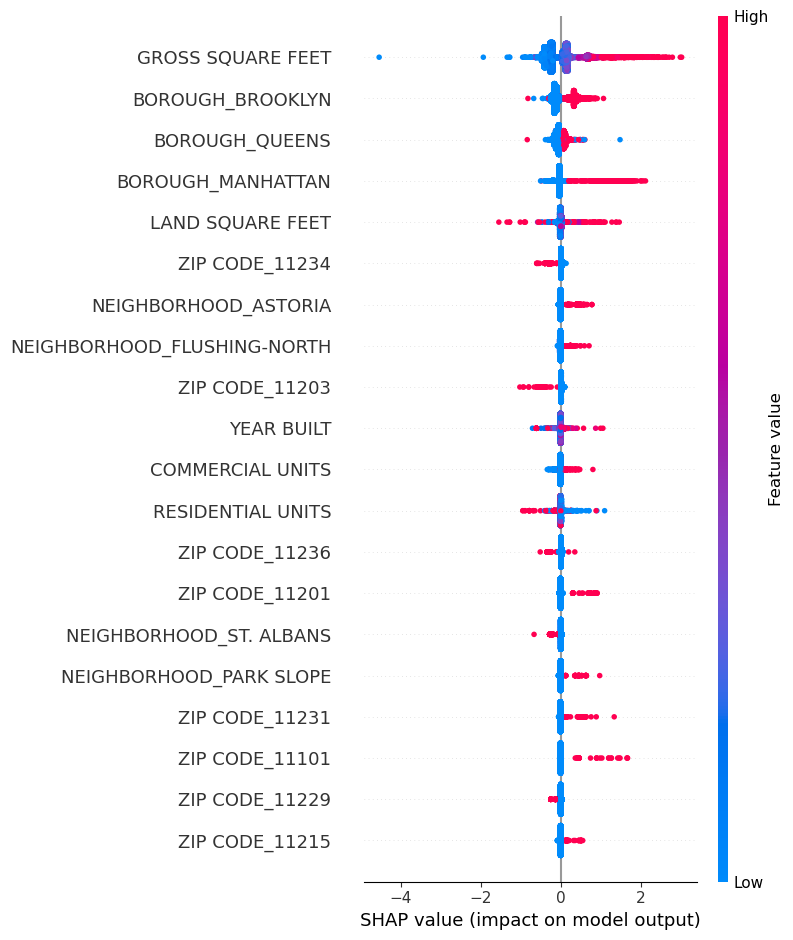

CPU times: total: 3.89 s
Wall time: 3.92 s


In [65]:
%%time
explainer = shap.TreeExplainer(dt_final)
shap_values = explainer.shap_values(x_test_stan)
shap.summary_plot(shap_values, x_test_stan)

## Random Forest

In [66]:
%%time
# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 600,
                                 min_samples_split = 4,
                                 min_impurity_decrease = 0.0,
                                 max_features = 'log2',
                                 max_depth = None,
                                 criterion = 'friedman_mse',
                                 bootstrap = True)

# Train the models using 80% of the original data
rf_final.fit(x_train_stan, y_train_stan)

CPU times: total: 1min 27s
Wall time: 1min 28s


RandomForestRegressor(criterion='friedman_mse', max_features='log2',
                      min_samples_split=4, n_estimators=600)

In [67]:
%%time
rf_scores =  final_comparison([rf_final], x_test_stan, y_test_stan)
rf_scores.columns  = [ 'Random Forest']
rf_scores

CPU times: total: 3.12 s
Wall time: 3.12 s


,Random Forest
Mean Absolute Error,0.385900
Mean Squared Error,0.403500
Root Mean Squared Error,0.635216
R^2,0.576300


In [ ]:
%%time
explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(x_test_stan)
shap.summary_plot(shap_values, x_test_stan)

## Extreme Gradient Booster

In [ ]:
%%time
# Create the fnal Extreme Gradient Booster
xgb_final = xgb.XGBRegressor(tree_method = 'hist',
                             objective = 'reg:squarederror',
                             n_estimators = 1800,
                             min_child_weight = 5,
                             max_depth = 2,
                             gamma = 0,
                             eta = 0.1)

# Train the models using 80% of the original data
xgb_final.fit(x_train_stan, y_train_stan)

In [ ]:
%%time
xgb_scores =  final_comparison([xgb_final], x_test_stan, y_test_stan)
xgb_scores.columns  = ['XGBoost']
xgb_scores

In [ ]:
%%time
# Create the explainer object
explainer = shap.Explainer(xgb_final, x_test_stan)
# Calculate SHAP values for the test set
shap_values = explainer(x_test_stan)
# Plot the summary plot
shap.summary_plot(shap_values, x_test_stan)

## CatBoost

In [ ]:
%%time
cat_features=[0]
params = {'loss_function': 'RMSE',
          'random_state': 2022,
          'depth': 10,
          'iterations': 1200,
          'learning_rate': 0.03,
          'l2_leaf_reg': 0.3}
cbc_2 = catboost.CatBoostRegressor(**params)
cbc_2.fit(x_train_stan, y_train_stan, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(x_test_stan, y_test_stan), # data to validate on
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
         )

In [ ]:
%%time
cat_scores =  final_comparison([cbc_2], x_test_stan, y_test_stan)
cat_scores.columns  = ['cat_scores']

In [ ]:
%%time
# Create the explainer object
explainer = shap.Explainer(cbc_2, x_test_stan)
# Calculate SHAP values for the test set
shap_values = explainer(x_test_stan)
# Plot the summary plot
shap.summary_plot(shap_values, x_test_stan)

## LinearRegression

In [ ]:
%%time
# 创建线性回归模型对象
lr_final = LinearRegression()
# 拟合模型
lr_final.fit(x_train_stan, y_train_stan)
# 打印模型截距和系数
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

In [ ]:
%%time
lr_scores =  final_comparison([lr_final], x_test, y_test)
lr_scores.columns  = ['Linear Regression']

In [ ]:
coefs = pd.DataFrame({
    'Feature': x_train.columns,
    'Coef': model.coef_
})
coefs = coefs.sort_values('Coef', ascending=False)
print(coefs)

## AutoGluon

In [ ]:
Y_name = 'log_Sale_Price'
y = df2[Y_name]
X = df2.drop(['SALE PRICE','log_Sale_Price','ft_price','log_ft_price'], axis=1)

In [ ]:
SEED = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=SEED)
TRAIN = pd.concat([X_train, y_train], axis=1)
TEST = pd.concat([X_test, y_test], axis=1)

In [ ]:
label = 'log_Sale_Price'
TRAIN[label].describe()

In [ ]:
%%time
ag_final = TabularPredictor(label=label, problem_type='regression').fit(TRAIN, num_gpus=1)

In [ ]:
%%time
ag_final.leaderboard(TEST, silent=True)

In [ ]:
%%time
auto_scores =  final_comparison([ag_final], X_test, y_test)
auto_scores.columns  = ['AutoGluon']

In [ ]:
%%time
ag_final.feature_importance(TEST)

In [ ]:
%%time
# Call the comparison function with the three final models
final_scores = final_comparison([lr_final, dt_final, rf_final,cbc_2,xgb_final, ag_final], x_test_stan, y_test_stan)

# Adjust the column headers
final_scores.columns  = [ 'Linear Regression''Decision Tree', 'Random Forest','CatBoost','XGBoost','AutoGluon']

In [ ]:
all_scores = pd.DataFrame(index=dt_scores.index)
all_scores['Linear Regression'] = lr_scores
all_scores['Decision Tree'] = dt_scores
all_scores['Random Forest'] = rf_scores
all_scores['CatBoost'] = cat_scores
all_scores['XGBoost'] = xgb_scores
all_scores['AutoGluon'] = auto_scores
all_scores[]